# Construction and Mining Equipment Project

In [ ]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from typing import Dict, Any
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor
from IPython.display import Markdown
!pip install shap -q
import shap

!pip install xgboost shap optuna

import xgboost as xgb
import shap
import optuna
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 19.8 MB/s eta 0:00:00


# Objective #1: Predict future demand patterns

Notes:

1. When will demand wax and wane throughout the year?
2. What type of equipment will be in highest demand?
3. Where (geographically) will demand be strongest?
4. How much equipment inventory should we maintain?
5. What factors drive demand fluctuations?
6. How many units will customers want?
7. How much are customers willing to spend?

Types of Demand:
1. Sales/transactions - observed demand

  - Number of rental transactions per time period
  - Number of rental transactions by equipment type, geography, customer segment
  - Rental duration: how long are customers keeping equipment?
  - Inventory turnover and capacity planning

2. Unmet demand

  - How often are we unable to meet demand?
  - Per machine, time period

3. Market demand (across all competitors)

  - Total demand across all competitors in the market

4. Potential demand (Min-maxing)

  - If all barriers are removed (perfect availability, optimal pricing, full market awareness), what's the maximum possible demand?

5. Conditional vs. Unconditional

  - Demand given our current prices and service levels
  - Demand regardless of our business decisions

Data Requirements:

|Type of Data | Data| Specific Data| Why|
|-----|-----|-----|-----|
| Historical Data | Rental transaction history | Dates |  |
|  |  | Equipment Types |  |
|  |  | Duration |  |
|  |  | Location |  |
|  | Seasonal patterns | Summer, spring, fall, winter |  |
|  |  | Natural disasters |  |
|  | Cyclical trends (not seasonal) | Fiscal years |  |
|  |  | Holidays |  |
|  | Equipment utilization rates | Type |  |
|  |  | Region |  |
| External Factors | Construction spending index | Building permits |  |
|  | Economic Indicators | GDP growth |  |
|  |  | Unemployment |  |
|  | Infrastructure project announcements |  |  |
|  | Weather patterns |  | Probably coincides with construction season timing |
|  | Commodity prices | Oil |  |
|  |  | Steel |  |
|  |  | Copper |  |
| Market Intelligence | Competitor rental rates & availability |  |  |
|  | Regional construction activity forecasts |  |  |
|  | Major project pipelines |  |  |
|  |  |  |  |
|  |  |  |  |

Feature Engineering:
1. Lag features (demand 1-12 months prior)
2. Rolling averages and trends
3. External economic indicators as covariates
4. Holiday and construction season indicators

How to evaluate:
1. MAPE (Mean absolute percentage error)
2. RMSE - penalizes large forecast errors
3. Directional accuracy - for inventory planning

Methods & Implementation:

1. XGBoost
2. LightGBM
3. CatBoost
4. Neural Network with Mixed Precision
5. Ensemble Model

## Data Exploration

In [ ]:
train_df = pd.read_csv('/content/Train.csv', low_memory=False)
print(train_df.columns)
print(train_df.shape)
print(train_df.head)

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'saledate', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc',
       'fiModelSeries', 'fiModelDescriptor', 'ProductSize',
       'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc',
       'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
       'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
       'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
       'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
       'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
       'Travel_Controls', 'Differential_Type', 'Steering_Controls'],
      dtype='object')
(401125, 53)
<bound method NDFrame.head of         Sal

What is datasource?

In [ ]:
data_dictionary_df = pd.read_csv('/content/Data_Dictionary.csv', low_memory=False)
print(data_dictionary_df.columns)
print(data_dictionary_df.shape)
print(data_dictionary_df.head(53))

Index(['Variable', 'Description', 'Unnamed: 2'], dtype='object')
(53, 3)
                    Variable  \
0                    SalesID   
1                  MachineID   
2                    ModelID   
3                 datasource   
4               auctioneerID   
5                   YearMade   
6   MachineHoursCurrentMeter   
7                  UsageBand   
8                   Saledate   
9                  Saleprice   
10               fiModelDesc   
11               fiBaseModel   
12           fiSecondaryDesc   
13             fiModelSeries   
14         fiModelDescriptor   
15               ProductSize   
16          ProductClassDesc   
17                     State   
18              ProductGroup   
19          ProductGroupDesc   
20              Drive_System   
21                 Enclosure   
22                     Forks   
23                  Pad_Type   
24              Ride_Control   
25                     Stick   
26              Transmission   
27              Turbocharged   

In [ ]:
data_dictionary_df.iloc[3]

Variable                                              datasource
Description      source of the sale record;  some sources are...
Unnamed: 2                                                   NaN
Name: 3, dtype: object

In [ ]:
print(data_dictionary_df.iloc[3]['Description'])

  source of the sale record;  some sources are more diligent about reporting attributes of the machine than others.  Note that a particular datasource may report on multiple auctioneerIDs.


In [ ]:
print(train_df['datasource'].head(50))

0     121
1     121
2     121
3     121
4     121
5     121
6     121
7     121
8     121
9     121
10    121
11    121
12    121
13    121
14    121
15    121
16    121
17    121
18    121
19    121
20    121
21    121
22    121
23    121
24    121
25    121
26    121
27    121
28    121
29    121
30    121
31    121
32    121
33    121
34    121
35    121
36    121
37    121
38    121
39    121
40    121
41    121
42    121
43    121
44    121
45    121
46    121
47    121
48    121
49    121
Name: datasource, dtype: int64


In [ ]:
building_permits_df = pd.read_csv('/content/Building_Permits_Data.csv', low_memory=False)
building_permits_categories = pd.read_csv('/content/Building_Permits_Categories.csv', low_memory=False)
building_permits_data_types = pd.read_csv('/content/Building_Permits_Data_Types.csv', low_memory=False)
building_permits_error_types = pd.read_csv('/content/Building_Permits_Error_Types.csv', low_memory=False)
building_permits_geo_levels = pd.read_csv('/content/Building_Permits_Geo_Levels.csv', low_memory=False)
building_permits_time_periods = pd.read_csv('/content/Building_Permits_Time_Periods.csv', low_memory=False)

print('Building Permit Columns')
print(building_permits_df.columns)
print(building_permits_df.shape)
print(building_permits_df.head())


print('Building Permit Categories')
print(building_permits_categories.columns)
print(building_permits_categories.shape)
print(building_permits_categories.head())

print('Building Permit Data Types')
print(building_permits_data_types.columns)
print(building_permits_data_types.shape)
print(building_permits_data_types.head())

print('Building Permit Error Types')
print(building_permits_error_types.columns)
print(building_permits_error_types.shape)
print(building_permits_error_types.head())

print('Building Permit Geo Levels')
print(building_permits_geo_levels.columns)
print(building_permits_geo_levels.shape)
print(building_permits_geo_levels.head())

print('Building Permit Time Periods')
print(building_permits_time_periods.columns)
print(building_permits_time_periods.shape)
print(building_permits_time_periods.head())

Building Permit Columns
Index(['per_idx', 'cat_idx', 'dt_idx', 'et_idx', 'geo_idx', 'is_adj', 'val'], dtype='object')
(79872, 7)
   per_idx  cat_idx  dt_idx  et_idx  geo_idx  is_adj      val
0        1        1       1       0        1       0  59516.0
1        2        1       1       0        1       0  58588.0
2        3        1       1       0        1       0  63782.0
3        4        1       1       0        1       0  69504.0
4        5        1       1       0        1       0  73384.0
Building Permit Categories
Index(['cat_idx', 'cat_code', 'cat_desc', 'cat_indent'], dtype='object')
(38, 4)
   cat_idx cat_code            cat_desc  cat_indent
0        1     XXXX  Total Construction           0
1        2     00XX         Residential           0
2        3     NRXX      Nonresidential           0
3        4     01XX             Lodging           1
4        5     02XX              Office           1
Building Permit Data Types
Index(['dt_idx', 'dt_code', 'dt_desc', 'dt_unit'], d

In [ ]:
auction_volume_df = pd.read_csv('/content/Auction Volume.csv', low_memory=False)
print(auction_volume_df.columns)
print(auction_volume_df.shape)
print(auction_volume_df.head())

Index(['CUSIP', 'Security Type', 'Security Term', 'Auction Date', 'Issue Date',
       'Maturity Date', 'Price per $100', 'Download PDF - Announcement',
       'Download PDF - Competitive Results',
       'Download PDF - Noncompetitive Results', 'Download XML - Announcement',
       'Download XML - Competitive Results'],
      dtype='object')
(10565, 12)
       CUSIP Security Type     Security Term Auction Date  Issue Date  \
0  912797QA8          Bill            4-Week   2025-06-12  2025-06-17   
1  912797QJ9          Bill            8-Week   2025-06-12  2025-06-17   
2  912810UK2          Bond  29-Year 11-Month   2025-06-12  2025-06-16   
3  912797RC3          Bill           17-Week   2025-06-11  2025-06-17   
4  91282CNC1          Note   9-Year 11-Month   2025-06-11  2025-06-16   

  Maturity Date  Price per $100 Download PDF - Announcement  \
0    2025-07-15             NaN            A_20250610_3.pdf   
1    2025-08-12             NaN            A_20250610_2.pdf   
2    2055-05-15

In [ ]:
BCI_df = pd.read_csv('/content/Business Confidence Index.csv', low_memory=False)
print(BCI_df.columns)
print(BCI_df.shape)
print(BCI_df.head())

Index(['Category', 'OECD'], dtype='object')
(346, 2)
             Category       OECD
0  1985-10-01 0:00:00   99.96008
1  1985-11-01 0:00:00  100.00520
2  1985-12-01 0:00:00   99.96054
3  1986-01-01 0:00:00   99.88689
4  1986-02-01 0:00:00   99.84046


In [ ]:
construction_spending_df = pd.read_csv('/content/Construction_Spending_Index.csv', low_memory=False)
print(construction_spending_df.columns)
print(construction_spending_df.shape)
print(construction_spending_df.head())

Index(['observation_date', 'TTLCONS'], dtype='object')
(388, 2)
  observation_date  TTLCONS
0       1993-01-01   458080
1       1993-02-01   462967
2       1993-03-01   458399
3       1993-04-01   469425
4       1993-05-01   468998


In [ ]:
copper_price_df = pd.read_csv('/content/Copper Prices.csv', low_memory=False)
print(copper_price_df.columns)
print(copper_price_df.shape)
print(copper_price_df.head())

Index(['observation_date', 'PCOPPUSDM'], dtype='object')
(424, 2)
  observation_date    PCOPPUSDM
0       1990-01-01  2365.556991
1       1990-02-01  2358.943400
2       1990-03-01  2625.702723
3       1990-04-01  2685.226891
4       1990-05-01  2740.342391


In [ ]:
dealer_inventory_df = pd.read_csv('/content/Dealer Inventory Levels.csv', low_memory=False)
print(dealer_inventory_df.columns)
print(dealer_inventory_df.shape)
print(dealer_inventory_df.head())

Index(['observation_date', 'U33CTI'], dtype='object')
(400, 2)
  observation_date  U33CTI
0       1992-01-01    2923
1       1992-02-01    2891
2       1992-03-01    2856
3       1992-04-01    2805
4       1992-05-01    2789


In [ ]:
exchange_rate_df = pd.read_csv('/content/Exchange Rates.csv', low_memory=False)
print(exchange_rate_df.columns)
print(exchange_rate_df.shape)
print(exchange_rate_df.head())

Index(['observation_date', 'TWEXM'], dtype='object')
(2453, 2)
  observation_date     TWEXM
0       1973-01-03  108.2588
1       1973-01-10  108.3100
2       1973-01-17  108.3168
3       1973-01-24  108.2693
4       1973-01-31  107.8288


In [ ]:
gdp_df = pd.read_csv('/content/GDP.csv', low_memory=False)
print(gdp_df.columns)
print(gdp_df.shape)
print(gdp_df.head())

Index(['observation_date', 'GDPC1'], dtype='object')
(313, 2)
  observation_date     GDPC1
0       1947-01-01  2182.681
1       1947-04-01  2176.892
2       1947-07-01  2172.432
3       1947-10-01  2206.452
4       1948-01-01  2239.682


In [ ]:
housing_starts_df = pd.read_csv('/content/Housing_Starts_Data.csv', low_memory=False)
print(housing_starts_df.columns)
print(housing_starts_df.shape)
print(housing_starts_df.head())
housing_starts_categories = pd.read_csv('/content/Housing Starts_Categories.csv', low_memory=False)
print(housing_starts_categories.columns)
print(housing_starts_categories.shape)
print(housing_starts_categories.head())
housing_starts_data_types = pd.read_csv('/content/Housing_Starts_Data_Types.csv', low_memory=False)
print(housing_starts_data_types.columns)
print(housing_starts_data_types.shape)
print(housing_starts_data_types.head())
housing_starts_error_types = pd.read_csv('/content/Housing_Starts_Error_Types.csv', low_memory=False)
print(housing_starts_error_types.columns)
print(housing_starts_error_types.shape)
print(housing_starts_error_types.head())
housing_starts_geo_levels = pd.read_csv('/content/Housing_Starts_Geo_Levels.csv', low_memory=False)
print(housing_starts_geo_levels.columns)
print(housing_starts_geo_levels.shape)
print(housing_starts_geo_levels.head())
housing_starts_time_periods = pd.read_csv('/content/Housing_Starts_Time_Periods.csv', low_memory=False)
print(housing_starts_time_periods.columns)
print(housing_starts_time_periods.shape)
print(housing_starts_time_periods.head())

Index(['per_idx', 'cat_idx', 'dt_idx', 'et_idx', 'geo_idx', 'is_adj', 'val'], dtype='object')
(87721, 7)
   per_idx  cat_idx  dt_idx  et_idx  geo_idx  is_adj    val
0        1        2       1       0        1       0   75.7
1        2        2       1       0        1       0   79.0
2        3        2       1       0        1       0  119.0
3        4        2       1       0        1       0  127.9
4        5        2       1       0        1       0  120.8
Index(['cat_idx', 'cat_code', 'cat_desc', 'cat_indent'], dtype='object')
(8, 4)
   cat_idx    cat_code                                           cat_desc  \
0        1    APERMITS  Annual Rate for Housing Units Authorized in Pe...   
1        2     PERMITS  Housing Units Authorized in Permit-Issuing Places   
2        3  AUTHNOTSTD           Housing Units Authorized But Not Started   
3        4     ASTARTS              Annual Rate for Housing Units Started   
4        5      STARTS                              Housing Units Star

In [ ]:
interest_rates_df = pd.read_csv('/content/Interest Rates.csv', low_memory=False)
print(interest_rates_df.columns)
print(interest_rates_df.shape)
print(interest_rates_df.head())

Index(['observation_date', 'FEDFUNDS'], dtype='object')
(851, 2)
  observation_date  FEDFUNDS
0       1954-07-01      0.80
1       1954-08-01      1.22
2       1954-09-01      1.07
3       1954-10-01      0.85
4       1954-11-01      0.83


In [ ]:
iron_and_steel_price_df = pd.read_csv('/content/Iron and Steel.csv', low_memory=False)
print(iron_and_steel_price_df.columns)
print(iron_and_steel_price_df.shape)
print(iron_and_steel_price_df.head())

Index(['observation_date', 'WPU101'], dtype='object')
(1192, 2)
  observation_date  WPU101
0       1926-01-01    11.4
1       1926-02-01    11.4
2       1926-03-01    11.4
3       1926-04-01    11.3
4       1926-05-01    11.3


In [ ]:
machine_appendix_df = pd.read_csv('/content/Machine_Appendix.csv', low_memory=False)
print(machine_appendix_df.columns)
print(machine_appendix_df.shape)
print(machine_appendix_df.head())

Index(['MachineID', 'ModelID', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc',
       'fiModelSeries', 'fiModelDescriptor', 'fiProductClassDesc',
       'ProductGroup', 'ProductGroupDesc', 'MfgYear', 'fiManufacturerID',
       'fiManufacturerDesc', 'PrimarySizeBasis', 'PrimaryLower',
       'PrimaryUpper'],
      dtype='object')
(358593, 16)
   MachineID  ModelID fiModelDesc fiBaseModel fiSecondaryDesc fiModelSeries  \
0        113     1355        350L         350             NaN           NaN   
1        434     3538        416C         416               C           NaN   
2        534     3538        416C         416               C           NaN   
3        718     3538        416C         416               C           NaN   
4       1753     1580      D5GLGP          D5               G           NaN   

  fiModelDescriptor                                 fiProductClassDesc  \
0                 L  Hydraulic Excavator, Track - 50.0 to 66.0 Metr...   
1               NaN  Backhoe Loa

In [ ]:
oil_price_df = pd.read_csv('/content/Oil Prices.csv', low_memory=False)
print(oil_price_df.columns)
print(oil_price_df.shape)
print(oil_price_df.head())

Index(['DATE', 'DCOILWTICO'], dtype='object')
(9924, 2)
       DATE  DCOILWTICO
0  2-Jan-86       25.56
1  3-Jan-86       26.00
2  6-Jan-86       26.53
3  7-Jan-86       25.85
4  8-Jan-86       25.87


In [ ]:
test_df = pd.read_csv('/content/Test.csv', low_memory=False)
print(test_df.columns)
print(test_df.shape)
print(test_df.head())

Index(['SalesID', 'MachineID', 'ModelID', 'datasource', 'auctioneerID',
       'YearMade', 'MachineHoursCurrentMeter', 'UsageBand', 'saledate',
       'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc', 'fiModelSeries',
       'fiModelDescriptor', 'ProductSize', 'fiProductClassDesc', 'state',
       'ProductGroup', 'ProductGroupDesc', 'Drive_System', 'Enclosure',
       'Forks', 'Pad_Type', 'Ride_Control', 'Stick', 'Transmission',
       'Turbocharged', 'Blade_Extension', 'Blade_Width', 'Enclosure_Type',
       'Engine_Horsepower', 'Hydraulics', 'Pushblock', 'Ripper', 'Scarifier',
       'Tip_Control', 'Tire_Size', 'Coupler', 'Coupler_System',
       'Grouser_Tracks', 'Hydraulics_Flow', 'Track_Type',
       'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb', 'Pattern_Changer',
       'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type', 'Travel_Controls',
       'Differential_Type', 'Steering_Controls'],
      dtype='object')
(12457, 52)
   SalesID  MachineID  ModelID  datasource  auctioneerI

In [ ]:
unemployment_rate_df = pd.read_csv('/content/Unemployment Rate 1.csv', low_memory=False)
print(unemployment_rate_df.columns)
print(unemployment_rate_df.shape)
print(unemployment_rate_df.head())

Index(['DATE', 'VALUE'], dtype='object')
(929, 2)
       DATE  VALUE
0  1/1/1948    3.4
1  2/1/1948    3.8
2  3/1/1948    4.0
3  4/1/1948    3.9
4  5/1/1948    3.5


In [ ]:
valid_df = pd.read_csv('/content/Valid.csv', low_memory=False)
print(valid_df.columns)
print(valid_df.shape)
print(valid_df.head())

Index(['SalesID', 'MachineID', 'ModelID', 'datasource', 'auctioneerID',
       'YearMade', 'MachineHoursCurrentMeter', 'UsageBand', 'saledate',
       'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc', 'fiModelSeries',
       'fiModelDescriptor', 'ProductSize', 'fiProductClassDesc', 'state',
       'ProductGroup', 'ProductGroupDesc', 'Drive_System', 'Enclosure',
       'Forks', 'Pad_Type', 'Ride_Control', 'Stick', 'Transmission',
       'Turbocharged', 'Blade_Extension', 'Blade_Width', 'Enclosure_Type',
       'Engine_Horsepower', 'Hydraulics', 'Pushblock', 'Ripper', 'Scarifier',
       'Tip_Control', 'Tire_Size', 'Coupler', 'Coupler_System',
       'Grouser_Tracks', 'Hydraulics_Flow', 'Track_Type',
       'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb', 'Pattern_Changer',
       'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type', 'Travel_Controls',
       'Differential_Type', 'Steering_Controls'],
      dtype='object')
(11573, 52)
   SalesID  MachineID  ModelID  datasource  auctioneerI

In [ ]:
valid_solution_df = pd.read_csv('/content/ValidSolution.csv', low_memory=False)
print(valid_solution_df.columns)
print(valid_solution_df.shape)
print(valid_solution_df.head())

Index(['SalesID', 'SalePrice', 'Usage'], dtype='object')
(11573, 3)
   SalesID  SalePrice       Usage
0  1222837    31000.0  PublicTest
1  1222839    54000.0  PublicTest
2  1222841    26500.0  PublicTest
3  1222843    10000.0  PublicTest
4  1222845    35000.0  PublicTest


Data needed for this objective:

| Dataset | Column | Details
|-----|-----|-----|
| Train.csv | SalePrice |
|  | MachineID |
|  | ModelID |
|  | auctioneerID |
| | datasource | This contains more auctioneer data
|  | Year Made |
|  | MachineHoursCurrentMeter |
|  | UsageBand |
|  | saledate |
|  | ProductSize |
|  | state |
|  | ProductGroup |
| Building_Permits_Data.csv | per_idx | Month permits were issued|
| Auction Volume.csv | Auction Date |
|  | Price per $100 | Determines demand |
|  | Maturity Date | To calculate yield curve positioning |
| Business Confidence Index.csv | Category | Date|
|  | OECD | Confidence score |
| Construction_Spending_Index.csv | observation_date |
|  | TTLCONS | Total dollar amount is in millions of USD
| Copper Prices.csv | observation_date |
|  | PCOPPUSDM | if PCOPPUSDM is 2365.56 then 1 metric ton of copper cost 2,365.56 USD that month. |
| Dealer Inventory Levels.csv | observation_date |
|  | U33CTI | if U33CTI is 2923 then the dealer has 2.923 billion in inventory at dealer level
| Exchange Rates.csv | observation_date |
|  | TWEXM | if TWEXM is 108.26 then the dollar was 8.26% stronger than it was the base year 1997?|
| GDP.csv | observation_date |
|  | GDPC1 | if GDPC1 = 2182.68 then the US GDP  was 2.182 trillion (in 2012 dollars) in a specific quarter in a specific year.
| Housing_Starts_Data.csv | per_idx | time period|
|  | geo_idx | region
|  | val | if val = 75.7 then there were 75,700 new housing units started
| Interest Rates.csv | observation_date |
|  | FEDFUNDS | Banks lend to each other at an average rate of FEDFUNDS at the observation date.
| Iron and Steel.csv | observation_date |
|  | WPU101 | if WPU101 = 100 that means that the price of iron and steel were at the same level as the time period
|  |  | if WPU101 = 150, then the prices were 50% higher than as the time period
| Machine_Appendix.csv | MachineID |
|  | ModelID |
|  | fiBaseModel |
|  | fiModelSeries | Indicates generational upgrades or changes to a (base) model
| | ProductGroup | |
| | MfgYear | Helps calculate the machine age |
| | fiManufacturerID | Helps with indicating if there is a manufacturer preference |
| | PrimarySizeBasis | Helps indicate if demand is higher for larger/smaller machines that do the job |
| Oil Prices.csv | DATE | |
| | DCOILWTICO | Exact pricing. 25.56 means 25.56 dollars. |
| Test.csv | | clean and Mirror Test.csv to Train.csv after Train.csv has been cleaned |
| Unemployment rate 1.csv | DATE | |
| | VALUE | The national unemployment rate % for that month, seasonally adjusted. |
| Valid.csv | | clean and Mirror Valid.csv to Train.csv after Train.csv has been cleaned |
| ValidSolution.csv | | Combine with Valid.csv then clean and mirror to Train.csv |


## Cleaning and Transformation

General Cleaning Pipeline:
1. Drop duplicate rows
2. Identify metadata or embedded
3. Strip whitespace
4. Convert to lowercase
5. Replace spaces with underscores
6. Typos?
7. Check data types
8. Amputation
9. Imputation
10. Outliers
11. Standardize categorical data
12. Feature engineering

  Weather data integration

  Combine all dataframes according to modeling needs

  Equipment-specific features

  Market condition features

13. Inconsistencies
14. Validate time series (only use data from data time frame)
15. Data integrity
16. Create final cleaned train dataframe
17. Transform test_df, valid_df, validsolutions_df
18. Create new df by combining valid_df with valid solutions_df


| Dataset                           | Dataframe | Cleaned Dataframe | Column                   | Cleaning Efforts                                        | Cleaned? |
| --------------------------------- | --------- | ----------------- | ------------------------ | ------------------------------------------------------- | -------- |
| Train.csv                         |   train_df        |                   | SalePrice                | Handle missing values, outliers, normalize              |          |
|                                   |           |                   | MachineID                | Ensure consistency; join with appendix                  |          |
|                                   |           |                   | ModelID                  | Validate types and completeness                         |          |
|                                   |           |                   | auctioneerID             | Impute or drop missing; merge with `datasource`         |          |
|                                   |           |                   | datasource               | Standardize categorical codes                           |          |
|                                   |           |                   | Year Made                | Replace 1000s with NaN; convert to machine age          |          |
|                                   |           |                   | MachineHoursCurrentMeter | Impute or cap; assess skew                              |          |
|                                   |           |                   | UsageBand                | Fill missing; encode ordinally                          |          |
|                                   |           |                   | saledate                 | Convert to datetime; extract date features              |          |
|                                   |           |                   | ProductSize              | Normalize size categories                               |          |
|                                   |           |                   | state                    | One-hot or label encode                                 |          |
|                                   |           |                   | ProductGroup             | Cross-check with appendix                               |          |
| Building\_Permits\_Data.csv       | building_permits_df          |                   | per\_idx                 | Map to date or month string                             |          |
| Auction Volumne.csv               |   auction_volume_df        |                   | Auction Date             | Convert to datetime                                     |          |
|                                   |           |                   | Price per \$100          | Convert to float                                        |          |
|                                   |           |                   | Maturity Date            | Convert to datetime                                     |          |
| Business Confidence Index.csv     |   BCI_df        |                   | Category                 | Normalize column names                                  |          |
|                                   |           |                   | OECD                     | Convert to float; filter by geography                   |          |
| Construction\_Spending\_Index.csv |  construction_spending_df         |                   | observation\_date        | Convert to datetime                                     |          |
|                                   |           |                   | TTLCONS                  | Convert to numeric; scale to billions                   |          |
| Data_Dictionary.csv | data_dictionary_df |  |  | For reference only |
| Copper Prices.csv                 |    copper_price_df       |                   | observation\_date        | Convert to datetime                                     |          |
|                                   |           |                   | PCOPPUSDM                | Convert to float; no missing values expected            |          |
| Dealer Inventory Levels.csv       |   dealer_inventory_df        |                   | observation\_date        | Convert to datetime                                     |          |
|                                   |           |                   | U33CTI                   | Convert to float; verify unit consistency               |          |
| Exchange Rates.csv                |  exchange_rate_df         |                   | observation\_date        | Convert to datetime                                     |          |
|                                   |           |                   | TWEXM                    | Convert to float; filter time range                     |          |
| GDP.csv                           |  gdp_df         |                   | observation\_date        | Convert to datetime                                     |          |
|                                   |           |                   | GDPC1                    | Convert to float; align quarterly data                  |          |
| Housing\_Starts\_Data.csv         |     housing_starts_df      |                   | per\_idx                 | Map to date                                             |          |
|                                   |           |                   | geo\_idx                 | Map region codes                                        |          |
|                                   |           |                   | val                      | Scale to actual housing counts                          |          |
| Interest Rates.csv                |    interest_rates_df       |                   | observation\_date        | Convert to datetime                                     |          |
|                                   |           |                   | FEDFUNDS                 | Convert to float                                        |          |
| Iron and Steel.csv                |     iron_and_steel_price_df     |                   | observation\_date        | Convert to datetime                                     |          |
|                                   |           |                   | WPU101                   | Convert to float; normalize if needed                   |          |
| Machine\_Appendix.csv             |   machine_appendix_df        |                   | MachineID                | Join key; validate types                                |          |
|                                   |           |                   | ModelID                  | Use for joining; deduplicate if needed                  |          |
|                                   |           |                   | fiBaseModel              | Normalize text                                          |          |
|                                   |           |                   | fiModelSeries            | Standardize text entries                                |          |
|                                   |           |                   | ProductGroup             | Cross-check with other datasets                         |          |
|                                   |           |                   | MfgYear                  | Convert to int; check for errors                        |          |
|                                   |           |                   | fiManufacturerID         | Map to names if needed                                  |          |
|                                   |           |                   | PrimarySizeBasis         | Normalize basis (e.g., HP vs tons)                      |          |
| Oil Prices.csv                    |   oil_price_df         |                   | DATE                     | Convert to datetime                                     |          |
|                                   |           |                   | DCOILWTICO               | Convert to float                                        |          |
| Test.csv                          |     test_df      |                   | –                        | Apply all transformations from `train_df`               |          |
| Unemployment rate 1.csv           |    unemployment_rate_df       |                   | DATE                     | Convert to datetime                                     |          |
|                                   |           |                   | VALUE                    | Rename to `UnemploymentRate`; convert to float          |          |
| Valid.csv                         |    valid_df       |                   | –                        | Apply all transformations from `train_df`               |          |
| ValidSolution.csv                 |   valid_solution_df        |                   | –                        | Merge with `valid_df`, then clean and mirror `train_df` |          |


### Train.csv

In [ ]:
# Overall duplicates in the entire set
duplicate_rows_in_train_df = train_df.duplicated().sum()
print(f"Number of duplicate rows in train_df: {duplicate_rows_in_train_df}")

Number of duplicate rows in train_df: 0


In [ ]:
# Whitespace removed
def strip_whitespace_from_dataframe(df):
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = df[col].str.strip()
    return df

train_df_1_before_strip = train_df.copy()
train_df_2_whitespace_removed = strip_whitespace_from_dataframe(train_df)

total_whitespace_removed = 0
for col in train_df.columns:
    if train_df_1_before_strip[col].dtype == 'object':
        before_len = train_df_1_before_strip[col].astype(str).str.len().sum()
        after_len = train_df[col].astype(str).str.len().sum()
        total_whitespace_removed += (before_len - after_len)
print(f"Total number of whitespaces removed from train_df: {total_whitespace_removed}")

Total number of whitespaces removed from train_df: 653


In [ ]:
# Check data types
print(train_df_2_whitespace_removed.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401125 entries, 0 to 401124
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   401125 non-null  int64  
 1   SalePrice                 401125 non-null  int64  
 2   MachineID                 401125 non-null  int64  
 3   ModelID                   401125 non-null  int64  
 4   datasource                401125 non-null  int64  
 5   auctioneerID              380989 non-null  float64
 6   YearMade                  401125 non-null  int64  
 7   MachineHoursCurrentMeter  142765 non-null  float64
 8   UsageBand                 69639 non-null   object 
 9   saledate                  401125 non-null  object 
 10  fiModelDesc               401125 non-null  object 
 11  fiBaseModel               401125 non-null  object 
 12  fiSecondaryDesc           263934 non-null  object 
 13  fiModelSeries             56908 non-null   o

In [ ]:
# Convert SaleDate to datetime
train_df_3_datetime_converted = train_df_2_whitespace_removed.copy()
original_dtype = train_df_3_datetime_converted['saledate'].dtype
train_df_3_datetime_converted['saledate'] = pd.to_datetime(train_df_3_datetime_converted['saledate'])
converted_dtype = train_df_3_datetime_converted['saledate'].dtype
rows_converted_to_datetime = 0
if converted_dtype == 'datetime64[ns]' and original_dtype != 'datetime64[ns]':
    rows_converted_to_datetime = train_df_3_datetime_converted.shape[0]

print(f"Total number of rows with 'saledate' converted to datetime: {rows_converted_to_datetime}")
print(train_df_3_datetime_converted['saledate'].dtype)
print(train_df_2_whitespace_removed[['saledate']].head())
print(train_df_3_datetime_converted[['saledate']].head())

Total number of rows with 'saledate' converted to datetime: 401125
datetime64[ns]
          saledate
0  11/16/2006 0:00
1   3/26/2004 0:00
2   2/26/2004 0:00
3   5/19/2011 0:00
4   7/23/2009 0:00
    saledate
0 2006-11-16
1 2004-03-26
2 2004-02-26
3 2011-05-19
4 2009-07-23


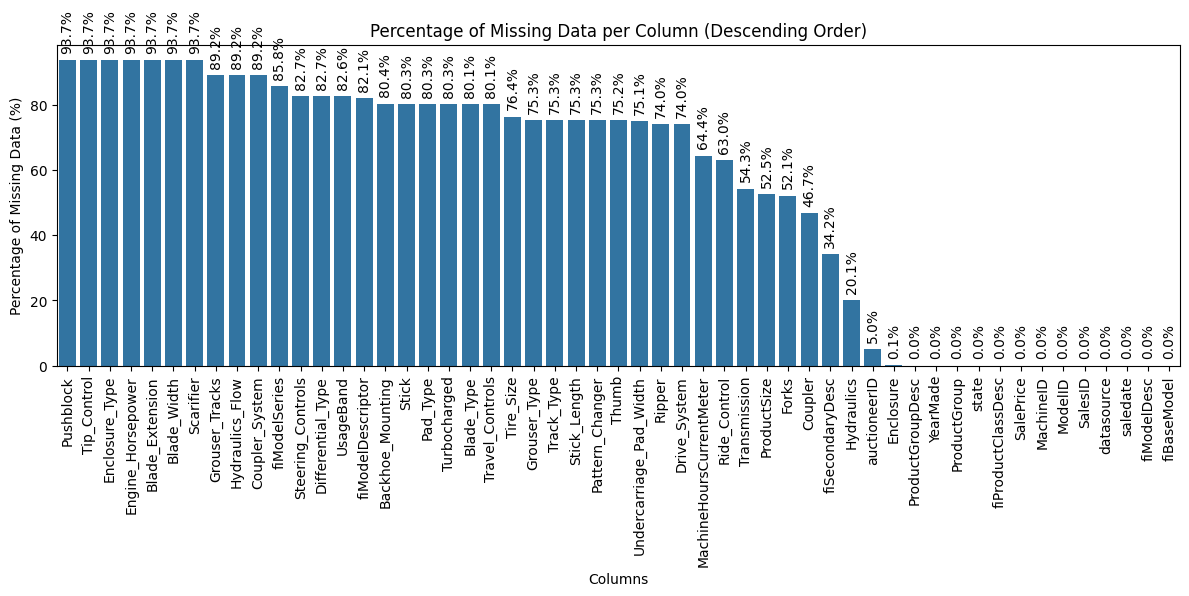

In [ ]:
# Percentage of missing values per column
missing_data = (train_df_3_datetime_converted.isnull().sum() / len(train_df_3_datetime_converted)) * 100
missing_data = missing_data.sort_values(ascending=False)

plt.figure(figsize=(12, 6))
ax = sns.barplot(x=missing_data.index, y=missing_data)
plt.xticks(rotation=90)
plt.xlabel('Columns')
plt.ylabel('Percentage of Missing Data (%)')
plt.title('Percentage of Missing Data per Column (Descending Order)')

for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', rotation=90, padding=5)

plt.tight_layout()
plt.show()

Missing Data To-Do List

|Column|Percentage Missing|What Do|
|---|---|---|
|fiModelSeries | 85.8% | Dropping |
|UsageBand | 82.6%| Create a new usage intensity proxy using MachineHoursCurrentMeter
| | | Create a a new feature 'equipment age'|
| | | Create a model to fill in the missing values using existing and created features.|
|MachineHoursCurrentMeter | 64.4% | Investigate further - Resolution below|
| ProductSize | 52.5% | create a new sizing category that is computed with existing data|
| |  | Small, Medium, Large |
| |  |Excavators = Stick_Length + Engine_Horsepower|
| |  | Create multi-feature size proxy (binary) |
| |  | Size_Known, Size_Estimated, Size_Confidence|
| AuctioneerID | 5% | Why is this missing? private sales? |
| | | Consider using tree-based models to handle this. |
| | | Will not remove, instead just fill it in with NaN/Unknown |
| | | |
| | | |
| | | |
| | | |
| | | |

In [ ]:
summary = train_df_7_estimated_hours.describe()
print(summary)

            SalesID      SalePrice     MachineID        ModelID  \
count  4.011250e+05  401125.000000  4.011250e+05  401125.000000   
mean   1.919713e+06   31099.712848  1.217903e+06    6889.702980   
min    1.139246e+06    4750.000000  0.000000e+00      28.000000   
25%    1.418371e+06   14500.000000  1.088697e+06    3259.000000   
50%    1.639422e+06   24000.000000  1.279490e+06    4604.000000   
75%    2.242707e+06   40000.000000  1.468067e+06    8724.000000   
max    6.333342e+06  142000.000000  2.486330e+06   37198.000000   
std    9.090215e+05   23036.898502  4.409920e+05    6221.777842   

          datasource   auctioneerID  MachineHoursCurrentMeter  \
count  401125.000000  380989.000000              1.427650e+05   
mean      134.665810       6.556040              3.457955e+03   
min       121.000000       0.000000              0.000000e+00   
25%       132.000000       1.000000              0.000000e+00   
50%       132.000000       2.000000              0.000000e+00   
75%   

In [ ]:
num_numerical_cols = train_df.select_dtypes(include=np.number).shape[1]
print(f"Number of numerical columns: {num_numerical_cols}")
num_numerical_cols_7 = train_df_7_estimated_hours.select_dtypes(include=np.number).shape[1]
print(f"Number of numerical columns in train_df_7_estimated_hours: {num_numerical_cols_7}")

Number of numerical columns: 8
Number of numerical columns in train_df_7_estimated_hours: 9


In [ ]:
for df_name in dir():
    if isinstance(eval(df_name), pd.DataFrame):
        print(f"\n--- Description of {df_name} ---")
        try:
            print(eval(df_name).describe())
        except Exception as e:
            print(f"Could not generate description for {df_name}: {e}")


--- Description of BCI_df ---
             OECD
count  346.000000
mean    99.952705
std      1.022192
min     95.281110
25%     99.425570
50%    100.013000
75%    100.709500
max    101.643800

--- Description of MHCM_Viz ---
            SalesID      SalePrice     MachineID        ModelID  \
count  4.011250e+05  401125.000000  4.011250e+05  401125.000000   
mean   1.919713e+06   31099.712848  1.217903e+06    6889.702980   
min    1.139246e+06    4750.000000  0.000000e+00      28.000000   
25%    1.418371e+06   14500.000000  1.088697e+06    3259.000000   
50%    1.639422e+06   24000.000000  1.279490e+06    4604.000000   
75%    2.242707e+06   40000.000000  1.468067e+06    8724.000000   
max    6.333342e+06  142000.000000  2.486330e+06   37198.000000   
std    9.090215e+05   23036.898502  4.409920e+05    6221.777842   

          datasource   auctioneerID       YearMade  MachineHoursCurrentMeter  \
count  401125.000000  380989.000000  401125.000000              1.427650e+05   
mean      

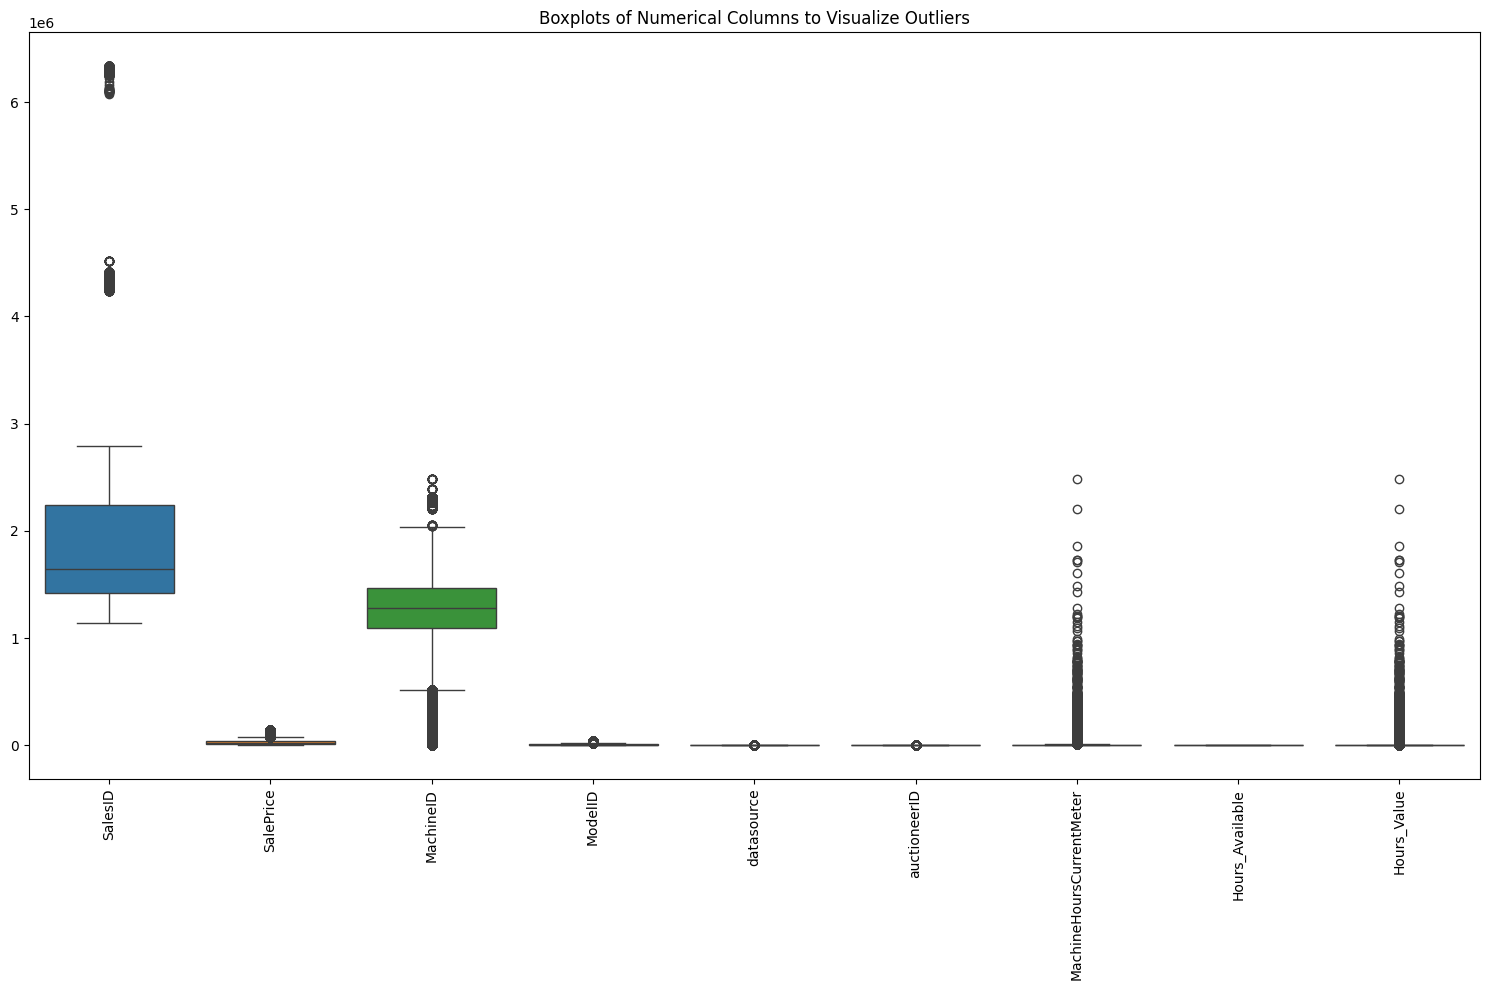

Column 'SalesID': 23468 outliers detected.
Column 'SalePrice': 22615 outliers detected.
Column 'MachineID': 47449 outliers detected.
Column 'ModelID': 37322 outliers detected.
Column 'datasource': 64882 outliers detected.
Column 'auctioneerID': 55281 outliers detected.
Column 'MachineHoursCurrentMeter': 13117 outliers detected.
Column 'Hours_Value': 69639 outliers detected.

Summary of Outlier Counts per Numerical Column:
- SalesID: 23468 outliers
- SalePrice: 22615 outliers
- MachineID: 47449 outliers
- ModelID: 37322 outliers
- datasource: 64882 outliers
- auctioneerID: 55281 outliers
- MachineHoursCurrentMeter: 13117 outliers
- Hours_Available: 0 outliers
- Hours_Value: 69639 outliers


In [ ]:
def detect_outliers_iqr(df, column):
  Q1 = df[column].quantile(0.25)
  Q3 = df[column].quantile(0.75)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR
  outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
  return outliers

numerical_cols = train_df_7_estimated_hours.select_dtypes(include=np.number).columns

plt.figure(figsize=(15, 10))
sns.boxplot(data=train_df_7_estimated_hours[numerical_cols])
plt.xticks(rotation=90)
plt.title('Boxplots of Numerical Columns to Visualize Outliers')
plt.tight_layout()
plt.show()

outliers_count = {}
for col in numerical_cols:
  outliers = detect_outliers_iqr(train_df_7_estimated_hours, col)
  outliers_count[col] = len(outliers)
  if len(outliers) > 0:
    print(f"Column '{col}': {len(outliers)} outliers detected.")

print("\nSummary of Outlier Counts per Numerical Column:")
for col, count in outliers_count.items():
    print(f"- {col}: {count} outliers")


Outlier To-Do List

| Column | Outliers | Action |
|---|---|---|
| SalePrice| 22,615 | Skewed with high value outliers. will cap at 99th percentile and transform. Either will use log or cube root transformations.
|MachineHoursCurrentMeter|13,117| Highly skewed. Will cap at 99th percentile, impute missing as "unknown" (or something more useful) then log-transform.


In [ ]:
categorical_cols = train_df_7_estimated_hours.select_dtypes(include='object').columns
print(train_df_7_estimated_hours[categorical_cols].describe())

        YearMade UsageBand fiModelDesc fiBaseModel fiSecondaryDesc  \
count     362940     69639      401125      401125          263934   
unique        71         3        4999        1950             170   
top         1998    Medium        310G         580               C   
freq       21221     33985        5039       19798           43245   

       fiModelSeries fiModelDescriptor ProductSize  \
count          56908             71919      190350   
unique           121               135           6   
top               II                 L      Medium   
freq           13202             15875       62274   

                                       fiProductClassDesc    state  ...  \
count                                              401125   401125  ...   
unique                                                 74       53  ...   
top     Backhoe Loader - 14.0 to 15.0 Ft Standard Digg...  Florida  ...   
freq                                                56166    63944  ...   

  

Encoding To-Do List ONE HOT

|Column| | Reason|
|----- |----- |----- |
| datasource |  | Investigate further |
| UsageBand |  |  |
| ProductSize |  |  |
| state |  |  |
| ProductGroup |  |  |
| ProductGroupDesc |  |  |
| ALL MACHINE PARTS |  |  |
|  |  |  |
|  |  |  |


Encoding To-Do List FREQUENCY/TARGET

|Column|Type of Encoding| Reason|
|----- |----- |----- |
| ModelID | Frequency encoding | Categorical-like numeric IDs, has many levels |
| fiModelDesc |  |  |
| fiBaseModel |  |  |
| fiSecondaryDesc |  |  |
| fiModelSeries |  |  |
| fiModelDescriptor |  |  |
|  |  |  |


Encoding To-Do List LABEL

|Column|Type of Encoding| Reason|
|----- |----- |----- |
| AuctioneerID | Label or frequency encoding + missing flag | This is also categorical bc of IDs but has missing/zeros. Will decide later. |
|  |  |  |
|  |  |  |


In [ ]:
# List numerical and categorical columns
numerical_cols = train_df_7_estimated_hours.select_dtypes(include=np.number).columns.tolist()
categorical_cols = train_df_7_estimated_hours.select_dtypes(include='object').columns.tolist()

print("Numerical Columns:")
print(numerical_cols)
print("\nCategorical Columns:")
categorical_cols

Numerical Columns:
['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource', 'auctioneerID', 'MachineHoursCurrentMeter', 'Hours_Available', 'Hours_Value']

Categorical Columns:


['YearMade',
 'UsageBand',
 'fiModelDesc',
 'fiBaseModel',
 'fiSecondaryDesc',
 'fiModelSeries',
 'fiModelDescriptor',
 'ProductSize',
 'fiProductClassDesc',
 'state',
 'ProductGroup',
 'ProductGroupDesc',
 'Drive_System',
 'Enclosure',
 'Forks',
 'Pad_Type',
 'Ride_Control',
 'Stick',
 'Transmission',
 'Turbocharged',
 'Blade_Extension',
 'Blade_Width',
 'Enclosure_Type',
 'Engine_Horsepower',
 'Hydraulics',
 'Pushblock',
 'Ripper',
 'Scarifier',
 'Tip_Control',
 'Tire_Size',
 'Coupler',
 'Coupler_System',
 'Grouser_Tracks',
 'Hydraulics_Flow',
 'Track_Type',
 'Undercarriage_Pad_Width',
 'Stick_Length',
 'Thumb',
 'Pattern_Changer',
 'Grouser_Type',
 'Backhoe_Mounting',
 'Blade_Type',
 'Travel_Controls',
 'Differential_Type',
 'Steering_Controls',
 'Equipment_Age',
 'Estimated_Hours']

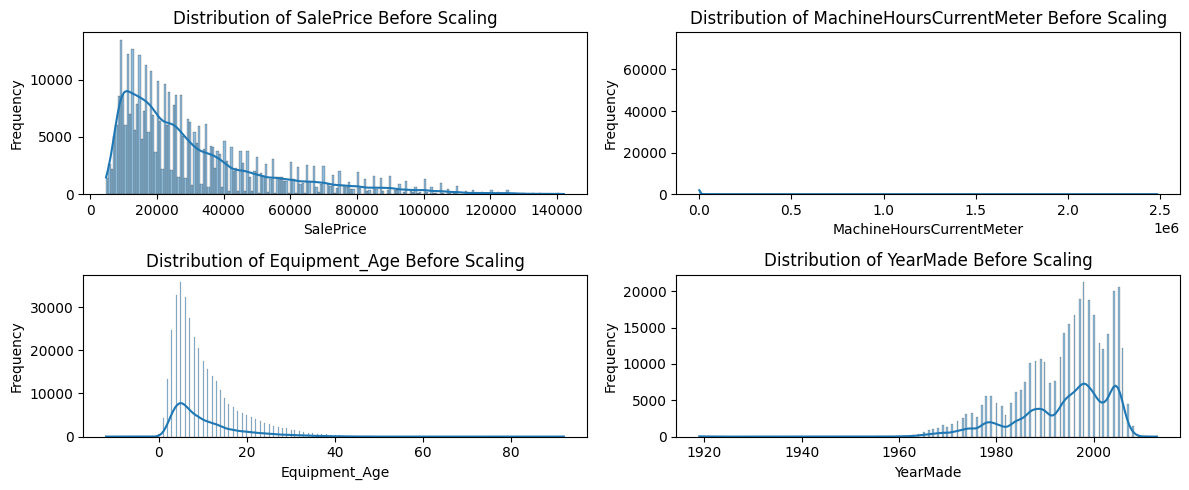

In [ ]:
# Visualization of distributions for scaling purposes (standardization, normalization, scaleing, etc..)
numerical_cols_for_scaling = ['SalePrice', 'MachineHoursCurrentMeter', 'Equipment_Age', 'YearMade']

plt.figure(figsize=(12, 5))

plt.subplot(2, 2, 1)
sns.histplot(train_df_7_estimated_hours[numerical_cols_for_scaling[0]].dropna(), kde=True)
plt.title(f'Distribution of {numerical_cols_for_scaling[0]} Before Scaling')
plt.xlabel(numerical_cols_for_scaling[0])
plt.ylabel('Frequency')

plt.subplot(2, 2, 2)
sns.histplot(train_df_7_estimated_hours[numerical_cols_for_scaling[1]].dropna(), kde=True)
plt.title(f'Distribution of {numerical_cols_for_scaling[1]} Before Scaling')
plt.xlabel(numerical_cols_for_scaling[1])
plt.ylabel('Frequency')

plt.subplot(2, 2, 3)
sns.histplot(train_df_7_estimated_hours[numerical_cols_for_scaling[2]].dropna(), kde=True)
plt.title(f'Distribution of {numerical_cols_for_scaling[2]} Before Scaling')
plt.xlabel(numerical_cols_for_scaling[2])
plt.ylabel('Frequency')

plt.subplot(2,2,4)
sns.histplot(train_df_7_estimated_hours[numerical_cols_for_scaling[3]].dropna(), kde=True)
plt.title(f'Distribution of {numerical_cols_for_scaling[3]} Before Scaling')
plt.xlabel(numerical_cols_for_scaling[3])
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [ ]:
from scipy.stats import skew, kurtosis

numerical_cols = train_df_7_estimated_hours.select_dtypes(include=np.number).columns

skewness = train_df_7_estimated_hours[numerical_cols].apply(lambda x: skew(x.dropna()))
kurt = train_df_7_estimated_hours[numerical_cols].apply(lambda x: kurtosis(x.dropna()))

print("\nSkewness of Numerical Columns:")
print(skewness)

print("\nKurtosis of Numerical Columns:")
kurt


Skewness of Numerical Columns:
SalesID                      3.045803
SalePrice                    1.525127
MachineID                   -0.738634
ModelID                      1.771632
datasource                   2.670841
auctioneerID                 4.851790
MachineHoursCurrentMeter    36.681729
Hours_Available              0.601888
Hours_Value                 60.965345
dtype: float64

Kurtosis of Numerical Columns:


SalesID                       10.616381
SalePrice                      2.197848
MachineID                      1.021108
ModelID                        3.179215
datasource                     8.717367
auctioneerID                  23.365757
MachineHoursCurrentMeter    1908.717743
Hours_Available               -1.637731
Hours_Value                 5293.991092
dtype: float64

Scaling To-Do List:

|Column|Decision|
|---|---|
| MachineHoursCurrentMeter | log transform and normalize [0 to 1] |
| Hours_Value | log transform and Normalize [0 to 1] |
| SalePrice | MAYBE log transform and standardize [Has rough normal / even dist]|
| Equpment_Age | Log or square root transform and standardize |
|  |  |
|  |  |
|  |  |
|  |  |

#### MachineHoursCurrentMeter Exploration


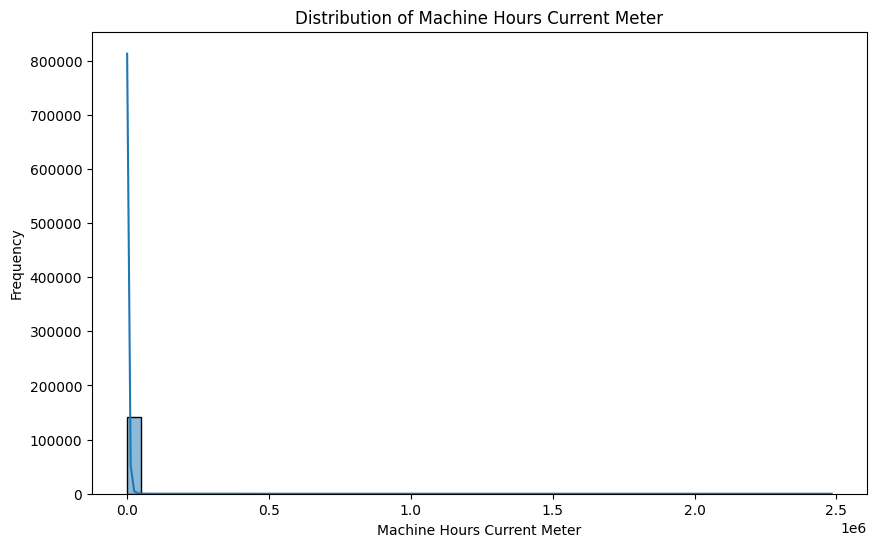

In [ ]:
MHCM_Viz = train_df_3_datetime_converted.copy()
plt.figure(figsize=(10, 6))
sns.histplot(MHCM_Viz['MachineHoursCurrentMeter'].dropna(), bins=50, kde=True)
plt.xlabel('Machine Hours Current Meter')
plt.ylabel('Frequency')
plt.title('Distribution of Machine Hours Current Meter')
plt.show()

In [ ]:
print(MHCM_Viz['MachineHoursCurrentMeter'].isna().sum())

258360


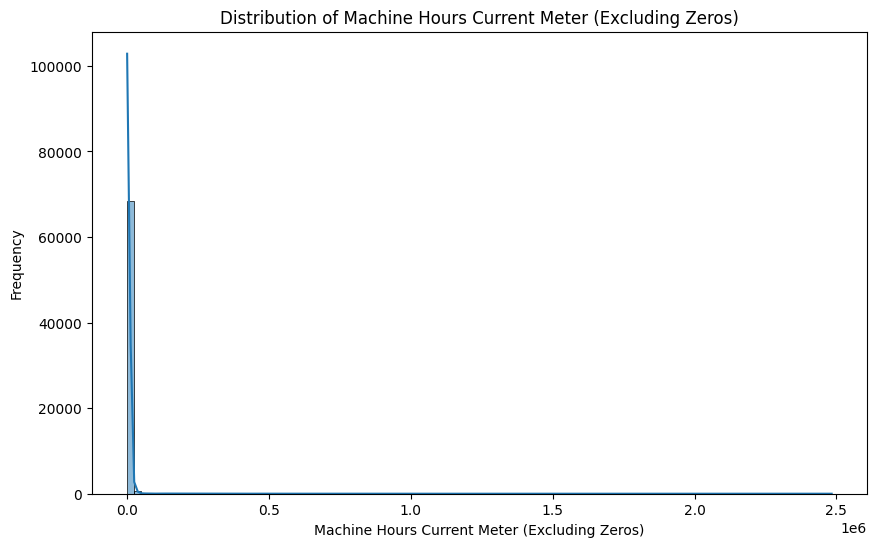

In [ ]:
MHCM_Viz_no_zeros = MHCM_Viz[MHCM_Viz['MachineHoursCurrentMeter'] != 0].copy()

plt.figure(figsize=(10, 6))
sns.histplot(MHCM_Viz_no_zeros['MachineHoursCurrentMeter'].dropna(), bins=100, kde=True)
plt.xlabel('Machine Hours Current Meter (Excluding Zeros)')
plt.ylabel('Frequency')
plt.title('Distribution of Machine Hours Current Meter (Excluding Zeros)')
plt.show()

In [ ]:
print(MHCM_Viz_no_zeros['MachineHoursCurrentMeter'].mode()[0])

2000.0


In [ ]:
print("Unique values and counts in MHCM_Viz:")
print(MHCM_Viz['MachineHoursCurrentMeter'].value_counts().sort_index())

print("\nUnique values and counts in MHCM_Viz_no_zeros:")
print(MHCM_Viz_no_zeros['MachineHoursCurrentMeter'].value_counts().sort_index())

Unique values and counts in MHCM_Viz:
MachineHoursCurrentMeter
0.0          73126
2.0             18
3.0             21
4.0             35
5.0             44
             ...  
1728600.0        1
1729600.0        1
1857100.0        1
2202400.0        1
2483300.0        1
Name: count, Length: 15152, dtype: int64

Unique values and counts in MHCM_Viz_no_zeros:
MachineHoursCurrentMeter
2.0          18
3.0          21
4.0          35
5.0          44
6.0          20
             ..
1728600.0     1
1729600.0     1
1857100.0     1
2202400.0     1
2483300.0     1
Name: count, Length: 15151, dtype: int64


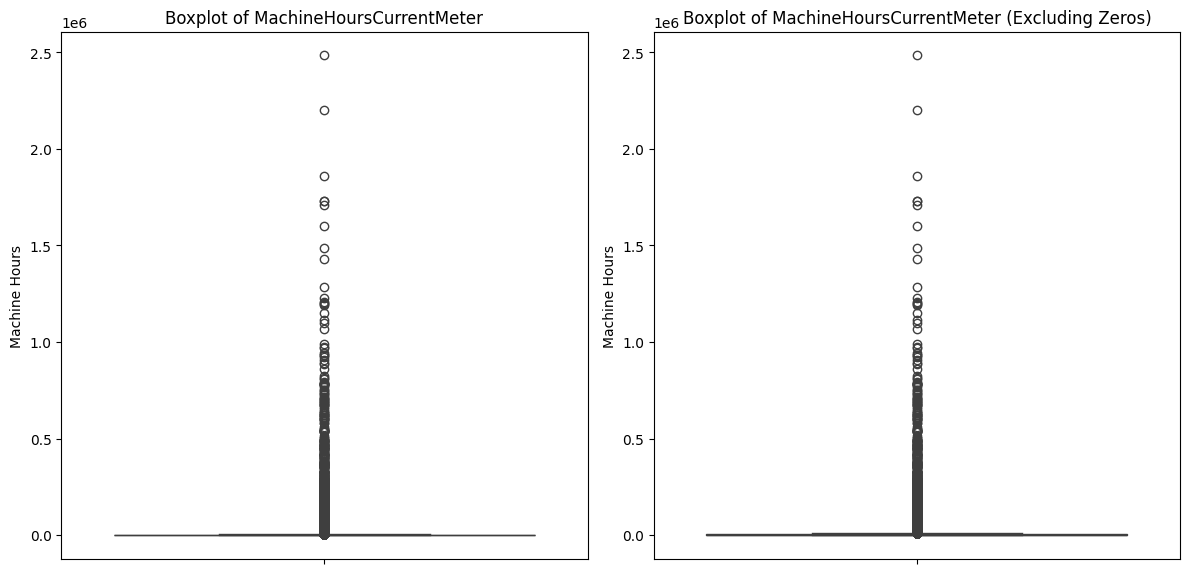

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.boxplot(y=MHCM_Viz['MachineHoursCurrentMeter'])
plt.title('Boxplot of MachineHoursCurrentMeter')
plt.ylabel('Machine Hours')

plt.subplot(1, 2, 2)
sns.boxplot(y=MHCM_Viz_no_zeros['MachineHoursCurrentMeter'])
plt.title('Boxplot of MachineHoursCurrentMeter (Excluding Zeros)')
plt.ylabel('Machine Hours')

plt.tight_layout()
plt.show()

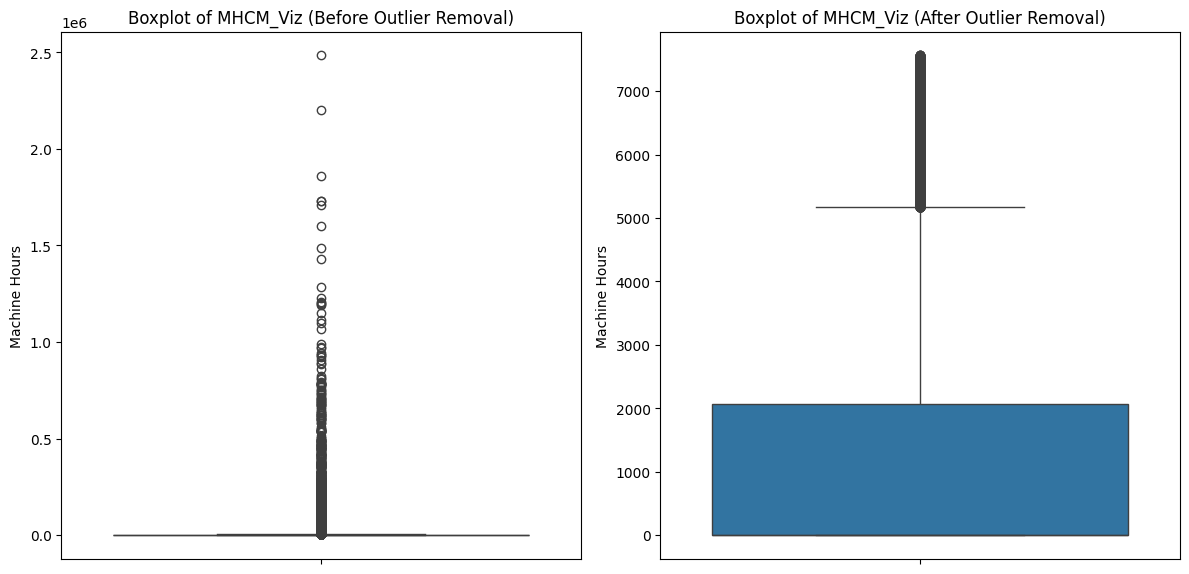

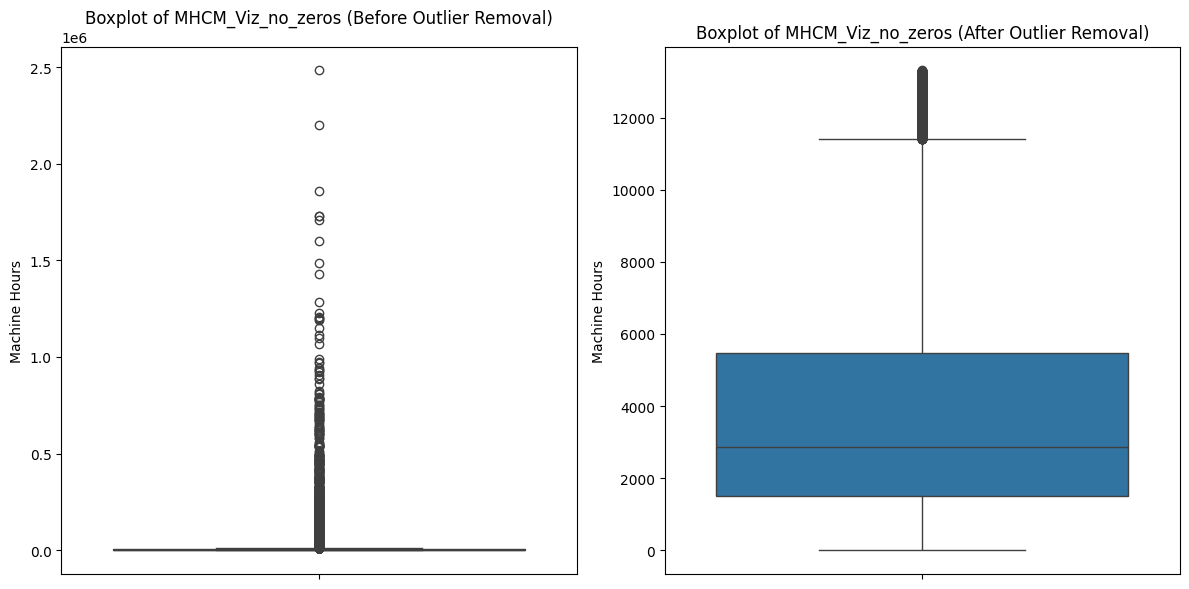

Original MHCM_Viz shape: (401125, 53)
MHCM_Viz after outlier removal shape: (129648, 53)
Original MHCM_Viz_no_zeros shape: (327999, 53)
MHCM_Viz_no_zeros after outlier removal shape: (65342, 53)


In [ ]:
# Remove outliers from  MHCM_Viz and MHCM_Viz_no_zeros and show the before and after boxplots

def remove_outliers_iqr(df, column):
  Q1 = df[column].quantile(0.25)
  Q3 = df[column].quantile(0.75)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR
  df_outliers_removed = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)].copy()
  return df_outliers_removed

MHCM_Viz_outliers_removed = remove_outliers_iqr(MHCM_Viz, 'MachineHoursCurrentMeter')
MHCM_Viz_no_zeros_outliers_removed = remove_outliers_iqr(MHCM_Viz_no_zeros, 'MachineHoursCurrentMeter')

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.boxplot(y=MHCM_Viz['MachineHoursCurrentMeter'])
plt.title('Boxplot of MHCM_Viz (Before Outlier Removal)')
plt.ylabel('Machine Hours')

plt.subplot(1, 2, 2)
sns.boxplot(y=MHCM_Viz_outliers_removed['MachineHoursCurrentMeter'])
plt.title('Boxplot of MHCM_Viz (After Outlier Removal)')
plt.ylabel('Machine Hours')

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.boxplot(y=MHCM_Viz_no_zeros['MachineHoursCurrentMeter'])
plt.title('Boxplot of MHCM_Viz_no_zeros (Before Outlier Removal)')
plt.ylabel('Machine Hours')

plt.subplot(1, 2, 2)
sns.boxplot(y=MHCM_Viz_no_zeros_outliers_removed['MachineHoursCurrentMeter'])
plt.title('Boxplot of MHCM_Viz_no_zeros (After Outlier Removal)')
plt.ylabel('Machine Hours')

plt.tight_layout()
plt.show()

print(f"Original MHCM_Viz shape: {MHCM_Viz.shape}")
print(f"MHCM_Viz after outlier removal shape: {MHCM_Viz_outliers_removed.shape}")
print(f"Original MHCM_Viz_no_zeros shape: {MHCM_Viz_no_zeros.shape}")
print(f"MHCM_Viz_no_zeros after outlier removal shape: {MHCM_Viz_no_zeros_outliers_removed.shape}")

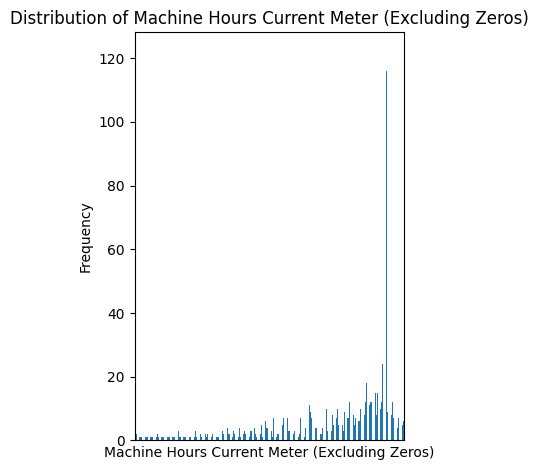

In [ ]:
plt.subplot(1, 2, 2)
MHCM_Viz_no_zeros['MachineHoursCurrentMeter'].value_counts().sort_index(ascending=False).plot(kind='bar')
plt.xlabel('Machine Hours Current Meter (Excluding Zeros)')
plt.ylabel('Frequency')
plt.title('Distribution of Machine Hours Current Meter (Excluding Zeros)')
plt.xticks([])

plt.tight_layout()
plt.show()

#### MachineHoursCurrentMeter Decision

Capping and removing missing values is not the way to go. I was also considering imputing via median but that's not going to help either. Why? If I was to impute, that would imply randomess. BUT THE DATA ISN'T RANDOM. Median imputation will also create equipment type blindness.

**New Strategy**

The equipment hours aren't randomly missing bc they are likely based on equipment age, type and datasource.

Step 1: Create new features

 - Hours_Available
 - Hours_Value
 - Estimated_Hours

Step 2: Train a model

 - Create a model that learns patters for the new features
 - Train 80%, Validate 20%

Step 3: Impute



---
Alternatively, I can cap at 99th percentile, log transform, then Impute zeros or missing values w/ .fillna(0)

**NEVERMIND** the new strategy did not work. I'll be attempting the alternative strategy.



In [ ]:
train_df_4_hours_available_feature = train_df_3_datetime_converted.copy()
train_df_4_hours_available_feature['Hours_Available'] = train_df_4_hours_available_feature['MachineHoursCurrentMeter'].notna().astype(int)

print(train_df_4_hours_available_feature[['MachineHoursCurrentMeter', 'Hours_Available']].head())
print(train_df_4_hours_available_feature['Hours_Available'].value_counts())

   MachineHoursCurrentMeter  Hours_Available
0                      68.0                1
1                    4640.0                1
2                    2838.0                1
3                    3486.0                1
4                     722.0                1
Hours_Available
0    258360
1    142765
Name: count, dtype: int64


In [ ]:
train_df_5_hours_value_feature = train_df_4_hours_available_feature.copy()
train_df_5_hours_value_feature['Hours_Value'] = train_df_5_hours_value_feature['MachineHoursCurrentMeter'].fillna(0)

print(train_df_5_hours_value_feature[['MachineHoursCurrentMeter', 'Hours_Available', 'Hours_Value']].head())
print(train_df_5_hours_value_feature[['MachineHoursCurrentMeter', 'Hours_Available', 'Hours_Value']].tail())
print(train_df_5_hours_value_feature['Hours_Value'].value_counts().head())
print(train_df_5_hours_value_feature['Hours_Value'].value_counts().sort_index().head())
print(train_df_5_hours_value_feature['Hours_Value'].value_counts().sort_index().tail())

   MachineHoursCurrentMeter  Hours_Available  Hours_Value
0                      68.0                1         68.0
1                    4640.0                1       4640.0
2                    2838.0                1       2838.0
3                    3486.0                1       3486.0
4                     722.0                1        722.0
        MachineHoursCurrentMeter  Hours_Available  Hours_Value
401120                       NaN                0          0.0
401121                       NaN                0          0.0
401122                       NaN                0          0.0
401123                       NaN                0          0.0
401124                       NaN                0          0.0
Hours_Value
0.0       331486
2000.0       122
1000.0       116
1500.0       101
500.0         97
Name: count, dtype: int64
Hours_Value
0.0    331486
2.0        18
3.0        21
4.0        35
5.0        44
Name: count, dtype: int64
Hours_Value
1728600.0    1
1729600.0    1
1

In [ ]:
train_df_6_equipment_age = train_df_5_hours_value_feature.copy()
train_df_6_equipment_age['SaleYear'] = train_df_6_equipment_age['saledate'].dt.year

# Replaced 'YearMade' values of 1000 with NaN (assuming 1000 is a placeholder for unknown)
train_df_6_equipment_age['YearMade'] = train_df_6_equipment_age['YearMade'].replace(1000, pd.NA)
train_df_6_equipment_age['Equipment_Age'] = train_df_6_equipment_age['SaleYear'] - train_df_6_equipment_age['YearMade']
train_df_6_equipment_age = train_df_6_equipment_age.drop(columns=['SaleYear'])

print(train_df_6_equipment_age[['saledate', 'YearMade', 'Equipment_Age']].head())
print(train_df_6_equipment_age[['saledate', 'YearMade', 'Equipment_Age']].tail())
print(train_df_6_equipment_age['Equipment_Age'].describe())
print(train_df_6_equipment_age['Equipment_Age'].isna().sum())

    saledate YearMade Equipment_Age
0 2006-11-16     2004             2
1 2004-03-26     1996             8
2 2004-02-26     2001             3
3 2011-05-19     2001            10
4 2009-07-23     2007             2
         saledate YearMade Equipment_Age
401120 2011-11-02     2005             6
401121 2011-11-02     2005             6
401122 2011-11-02     2005             6
401123 2011-10-25     2005             6
401124 2011-10-25     2005             6
count     362940
unique        86
top            5
freq       35716
Name: Equipment_Age, dtype: int64
38185


In [ ]:
train_df_7_estimated_hours = train_df_6_equipment_age.copy()

annual_usage_rates = train_df_7_estimated_hours[
    (train_df_7_estimated_hours['Hours_Available'] == 1) &
    (train_df_7_estimated_hours['Equipment_Age'].notna()) &
    (train_df_7_estimated_hours['Equipment_Age'] > 0)
].copy()

annual_usage_rates['Annual_Hours'] = annual_usage_rates['MachineHoursCurrentMeter'] / annual_usage_rates['Equipment_Age']

median_annual_hours_per_group = annual_usage_rates.groupby('ProductGroup')['Annual_Hours'].median().reset_index()
median_annual_hours_per_group.rename(columns={'Annual_Hours': 'Median_Annual_Hours_Per_Group'}, inplace=True)

train_df_7_estimated_hours = pd.merge(
    train_df_7_estimated_hours,
    median_annual_hours_per_group,
    on='ProductGroup',
    how='left'
)

# Impute 'Estimated_Hours' for rows where 'MachineHoursCurrentMeter' is missing,
# using Equipment_Age * Median_Annual_Hours_Per_Group
# Handle cases where Median_Annual_Hours_Per_Group might be NaN for a group
train_df_7_estimated_hours['Estimated_Hours'] = train_df_7_estimated_hours.apply(
    lambda row: row['MachineHoursCurrentMeter'] if row['Hours_Available'] == 1
    else (row['Equipment_Age'] * row['Median_Annual_Hours_Per_Group'] if pd.notna(row['Equipment_Age']) and pd.notna(row['Median_Annual_Hours_Per_Group']) else pd.NA),
    axis=1
)

train_df_7_estimated_hours = train_df_7_estimated_hours.drop(columns=['Median_Annual_Hours_Per_Group'])

print(train_df_7_estimated_hours[['ProductGroup', 'YearMade', 'saledate', 'Equipment_Age', 'MachineHoursCurrentMeter', 'Hours_Available', 'Hours_Value', 'Estimated_Hours']].head())
print(train_df_7_estimated_hours[['ProductGroup', 'YearMade', 'saledate', 'Equipment_Age', 'MachineHoursCurrentMeter', 'Hours_Available', 'Hours_Value', 'Estimated_Hours']].tail())

print(f"\nNumber of missing values in 'Estimated_Hours': {train_df_7_estimated_hours['Estimated_Hours'].isna().sum()}")

print("\nExamples where MachineHoursCurrentMeter was missing and Estimated_Hours was imputed:")
print(train_df_7_estimated_hours[
    (train_df_7_estimated_hours['Hours_Available'] == 0) &
    (train_df_7_estimated_hours['Equipment_Age'].notna())
][['ProductGroup', 'YearMade', 'saledate', 'Equipment_Age', 'MachineHoursCurrentMeter', 'Estimated_Hours']].head())

# Check examples where Estimated_Hours is still NaN (likely due to missing Equipment_Age or no data for that ProductGroup)
print("\nExamples where Estimated_Hours is still missing:")
print(train_df_7_estimated_hours[train_df_7_estimated_hours['Estimated_Hours'].isna()][[
    'ProductGroup', 'YearMade', 'saledate', 'Equipment_Age', 'MachineHoursCurrentMeter', 'Estimated_Hours'
]].head())

  ProductGroup YearMade   saledate Equipment_Age  MachineHoursCurrentMeter  \
0           WL     2004 2006-11-16             2                      68.0   
1           WL     1996 2004-03-26             8                    4640.0   
2          SSL     2001 2004-02-26             3                    2838.0   
3          TEX     2001 2011-05-19            10                    3486.0   
4          SSL     2007 2009-07-23             2                     722.0   

   Hours_Available  Hours_Value Estimated_Hours  
0                1         68.0            68.0  
1                1       4640.0          4640.0  
2                1       2838.0          2838.0  
3                1       3486.0          3486.0  
4                1        722.0           722.0  
       ProductGroup YearMade   saledate Equipment_Age  \
401120          TEX     2005 2011-11-02             6   
401121          TEX     2005 2011-11-02             6   
401122          TEX     2005 2011-11-02             6   
401

#### REGROUP
Compiling all to-do lists...

Drop these columns:

**All machine parts**. It's best that I focus on a smaller demand objective for this presentation.

I'll be keeping all the size and type measurements such as tire size, track type, drive system, etc.

**YearMade** - dropping this in favor of Equipment_Age

**SalesID**

**saledate** - dropping in favor of sale_year

**UsageBand** - dropping in favor of Equipment_Age.

Order of Operations:

1. Drop columns
2. Impute missing values
3. Cap outliers
4. feature engineering
5. Encoding
6. Scale/Normalize
7. Feature engineering

Next steps after cleaning:
1. Clean/convert secondary datasets
2. Combine secondary datasets to Train dataset
3. Run sanity check
4. Transform test and validation datasets

| Feature              | Recipe Steps                                                                 |
|----------------------|------------------------------------------------------------------------------|
| Estimated_Hours      | - Impute missing values (if any) <br> - Cap outliers (optional) <br> - Scale (Standard or Min-Max) |
| ProductGroup         | - One-Hot Encode                                                            |
| state                | - One-Hot Encode                                                            |
| UsageBand            | - Ordinal Encode (if meaningful order) <br> - Otherwise One-Hot Encode      |
| ProductSize          | - Ordinal Encode (if meaningful order) <br> - Otherwise One-Hot Encode      |
| Forks                | - One-Hot Encode                                                            |
| Enclosure            | - One-Hot Encode                                                            |
| Transmission         | - One-Hot Encode                                                            |
| Drive_System         | - One-Hot Encode                                                            |
| Hydraulics           | - One-Hot Encode                                                            |
| Tire_Size            | - One-Hot Encode                                                            |
| Coupler              | - One-Hot Encode                                                            |
| Coupler_System       | - One-Hot Encode                                                            |
| Thumb                | - One-Hot Encode                                                            |
| Stick                | - One-Hot Encode                                                            |
| Ride_Control         | - One-Hot Encode                                                            |
| Pad_Type             | - One-Hot Encode                                                            |
| Blade_Width          | - One-Hot Encode                                                            |
| Blade_Extension      | - One-Hot Encode                                                            |
| Tip_Control          | - One-Hot Encode                                                            |
| Pushblock            | - One-Hot Encode                                                            |
| Ripper               | - One-Hot Encode                                                            |
| Scarifier            | - One-Hot Encode                                                            |
| Backhoe_Mounting     | - One-Hot Encode                                                            |
| Pattern_Changer      | - One-Hot Encode                                                            |
| Grouser_Tracks       | - One-Hot Encode                                                            |
| Grouser_Type         | - One-Hot Encode                                                            |
| Track_Type           | - One-Hot Encode                                                            |
| Travel_Controls      | - One-Hot Encode                                                            |
| Differential_Type    | - One-Hot Encode                                                            |
| Steering_Controls    | - One-Hot Encode                                                            |
| fiBaseModel          | - Encode using frequency encoding                                           |
| fiModelDesc          | - Delay encoding until after train-test split <br> - Encode using frequency or target encoding |
| fiSecondaryDesc      | - Encode using frequency encoding                                           |
| fiModelSeries        | - Encode using frequency encoding                                           |
| fiModelDescriptor    | - Encode using frequency encoding                                           |


**EXCEPTION HANDLING**


| Feature                  | Recipie Steps                                                                 |
|--------------------------|-----------------------------------------------------------------------------------|
| MachineHoursCurrentMeter | - Cap outliers (e.g., 99th percentile) <br> - Log transform (`np.log1p`) <br> - Impute missing/zeros <br> - Add binary flag (`has_machine_hours`) <br> - Scale (Standard or Min-Max) |
| Hours_Value              | - Cap outliers <br> - Log transform <br> - Impute missing/zeros <br> - Add binary flag (`has_hours_value`) <br> - Scale (Standard or Min-Max) |
| auctioneerID             | - Impute 0s or missing values (e.g., -1) <br> - Add binary flag (`auctioneerID_missing`) <br> - Encode (One-Hot or Frequency) |
| ModelID                  | - Delay encoding until after train-test split <br> - Encode using frequency or target encoding <br> - Do **not** scale |
| Equipment_Age            | - Log or square-root transform <br> - Scale (StandardScaler preferred) |
| YearMade                 | - Derive `Equipment_Age` feature first <br> - Optionally drop or ordinal encode <br> - Do **not** scale as-is |
| SalePrice (target)       | - Log transform (`np.log1p`) <br> - Optionally scale (StandardScaler) if model needs scaled target |

In [ ]:
# Estimated_hours Step 1: Impute
# imputing using the overall median annual hours for the entire dataset
overall_median_annual_hours = annual_usage_rates['Annual_Hours'].median()

train_df_7_estimated_hours['Estimated_Hours'] = train_df_7_estimated_hours['Estimated_Hours'].fillna(overall_median_annual_hours * train_df_7_estimated_hours['Equipment_Age'])

# For remaining NaNs, I'm imputing with the median of the non-missing Estimated_Hours
median_estimated_hours = train_df_7_estimated_hours['Estimated_Hours'].median()
train_df_7_estimated_hours['Estimated_Hours'] = train_df_7_estimated_hours['Estimated_Hours'].fillna(median_estimated_hours)

print(f"\nNumber of missing values in 'Estimated_Hours' after final imputation: {train_df_7_estimated_hours['Estimated_Hours'].isna().sum()}")

print("\nExamples where Estimated_Hours was imputed with overall median (due to missing Equipment_Age):")
print(train_df_7_estimated_hours[
    (train_df_7_estimated_hours['Hours_Available'] == 0) &
    (train_df_7_estimated_hours['YearMade'].isna())
][['ProductGroup', 'YearMade', 'saledate', 'Equipment_Age', 'MachineHoursCurrentMeter', 'Estimated_Hours']].head())

print("\nInfo after imputation:")
print(train_df_7_estimated_hours[['MachineHoursCurrentMeter', 'Hours_Available', 'Hours_Value', 'Estimated_Hours']].info())


Number of missing values in 'Estimated_Hours' after final imputation: 0

Examples where Estimated_Hours was imputed with overall median (due to missing Equipment_Age):
      ProductGroup YearMade   saledate Equipment_Age  \
23997           BL     <NA> 2007-08-10          <NA>   
24001           BL     <NA> 2004-09-15          <NA>   
24006           BL     <NA> 2000-09-26          <NA>   
24007          TEX     <NA> 1994-02-11          <NA>   
24009          TEX     <NA> 1995-04-18          <NA>   

       MachineHoursCurrentMeter  Estimated_Hours  
23997                       NaN              0.0  
24001                       NaN              0.0  
24006                       NaN              0.0  
24007                       NaN              0.0  
24009                       NaN              0.0  

Info after imputation:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401125 entries, 0 to 401124
Data columns (total 4 columns):
 #   Column                    Non-Null Count   Dtype 

/tmp/ipython-input-50-742638409.py:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_df_7_estimated_hours['Estimated_Hours'] = train_df_7_estimated_hours['Estimated_Hours'].fillna(median_estimated_hours)


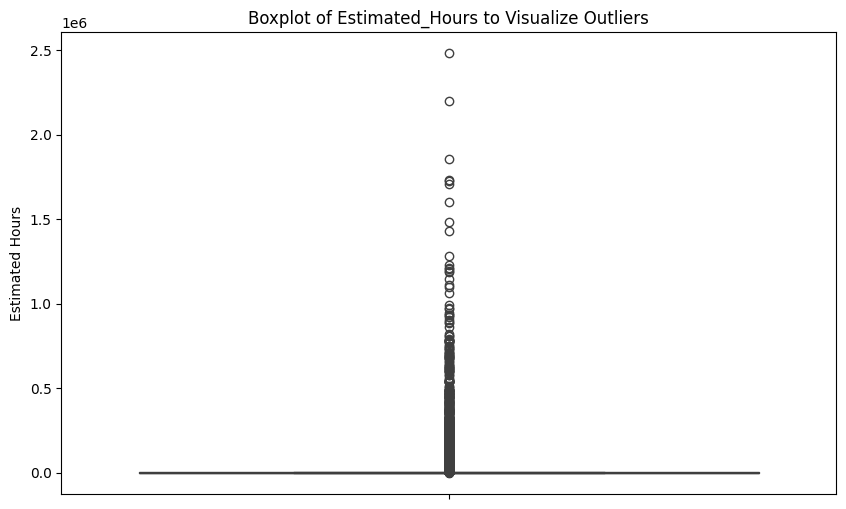

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(y=train_df_7_estimated_hours['Estimated_Hours'])
plt.title('Boxplot of Estimated_Hours to Visualize Outliers')
plt.ylabel('Estimated Hours')
plt.show()

Estimated_Hours capped at the 99th percentile: 13777.76000000001

Estimated_Hours describe after capping:
count    401125.000000
mean       1148.297101
std        2362.744966
min       -2624.285714
25%           0.000000
50%           0.000000
75%        1394.000000
max       13777.760000
Name: Estimated_Hours, dtype: float64


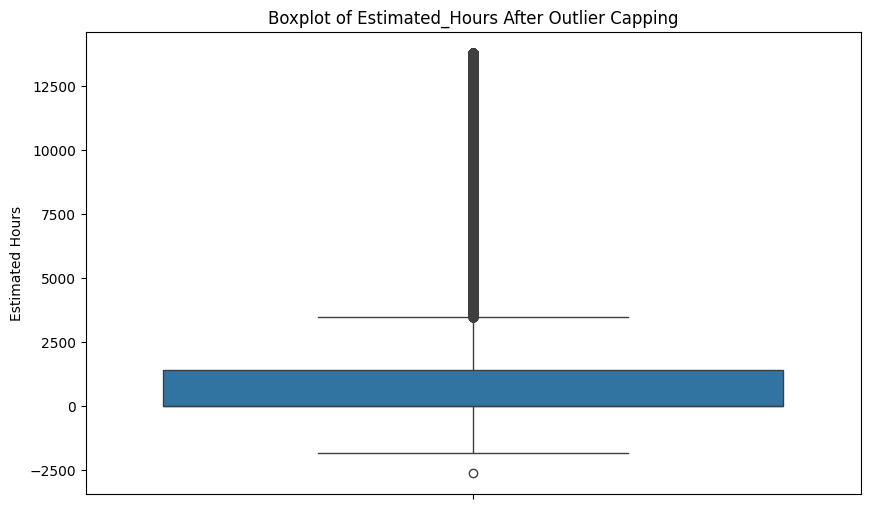

In [ ]:
# Estimated_Hours Step 2: Handling Outliers

# 99th percentile
q99_estimated_hours = train_df_7_estimated_hours['Estimated_Hours'].quantile(0.99)
train_df_8_outliers_removed = train_df_7_estimated_hours.copy()
train_df_8_outliers_removed['Estimated_Hours'] = train_df_8_outliers_removed['Estimated_Hours'].clip(upper=q99_estimated_hours)

print(f"Estimated_Hours capped at the 99th percentile: {q99_estimated_hours}")

print("\nEstimated_Hours describe after capping:")
print(train_df_8_outliers_removed['Estimated_Hours'].describe())

plt.figure(figsize=(10, 6))
sns.boxplot(y=train_df_8_outliers_removed['Estimated_Hours'])
plt.title('Boxplot of Estimated_Hours After Outlier Capping')
plt.ylabel('Estimated Hours')
plt.show()

train_df_8 = train_df_8_outliers_removed.copy()

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


Distribution of Estimated_Hours before log transformation:


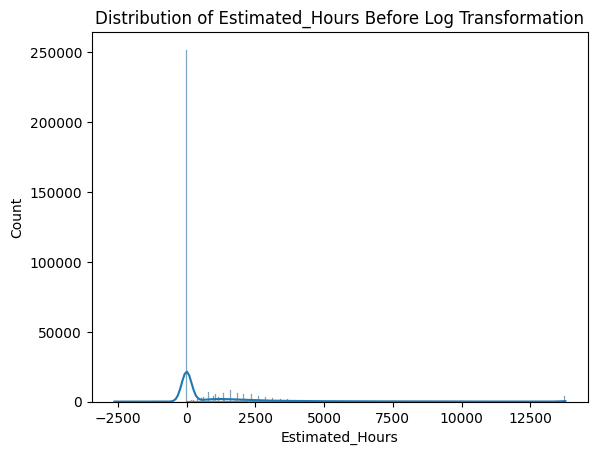


Distribution of Estimated_Hours after log transformation (log1p):


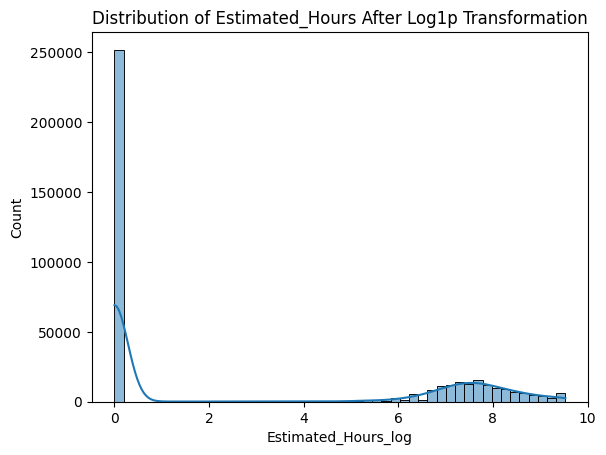


Distribution of Estimated_Hours after log transformation and standard scaling:


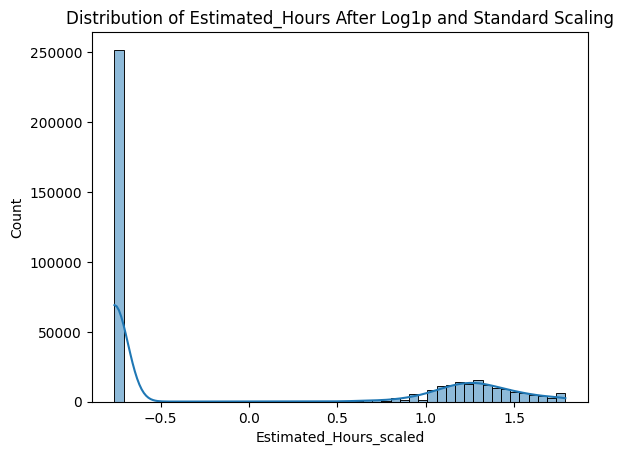


Estimated_Hours columns in train_df_9:
       Estimated_Hours  Estimated_Hours_log  Estimated_Hours_scaled
count    401125.000000        401120.000000            4.011200e+05
mean       1148.297101             2.842655           -6.292002e-17
std        2362.744966             3.735137            1.000001e+00
min       -2624.285714             0.000000           -7.610587e-01
25%           0.000000             0.000000           -7.610587e-01
50%           0.000000             0.000000           -7.610587e-01
75%        1394.000000             7.240650            1.177467e+00
max       13777.760000             9.530884            1.790627e+00


In [ ]:
# Estimated_Hours Step 3: Scale
from sklearn.preprocessing import StandardScaler

train_df_9 = train_df_8.copy()

train_df_9['Estimated_Hours_log'] = np.log1p(train_df_9['Estimated_Hours'])

print("Distribution of Estimated_Hours before log transformation:")
sns.histplot(train_df_9['Estimated_Hours'], kde=True)
plt.title('Distribution of Estimated_Hours Before Log Transformation')
plt.show()

print("\nDistribution of Estimated_Hours after log transformation (log1p):")
sns.histplot(train_df_9['Estimated_Hours_log'], kde=True)
plt.title('Distribution of Estimated_Hours After Log1p Transformation')
plt.show()


# Standard scale the nlog-transformed
scaler = StandardScaler()
train_df_9['Estimated_Hours_scaled'] = scaler.fit_transform(train_df_9[['Estimated_Hours_log']])

print("\nDistribution of Estimated_Hours after log transformation and standard scaling:")
sns.histplot(train_df_9['Estimated_Hours_scaled'], kde=True)
plt.title('Distribution of Estimated_Hours After Log1p and Standard Scaling')
plt.show()

print("\nEstimated_Hours columns in train_df_9:")
print(train_df_9[['Estimated_Hours', 'Estimated_Hours_log', 'Estimated_Hours_scaled']].describe())

In [ ]:
# One-Hot Encoding

categorical_cols_to_onehot = [
    'Pad_Type', 'Stick', 'Ride_Control', 'Transmission', 'Turbocharged',
    'Blade_Extension', 'Blade_Width', 'Tip_Control', 'Pushblock', 'Ripper',
    'Scarifier', 'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Grouser_Type',
    'Hydraulics', 'Hydraulics_Flow', 'Thumb', 'Pattern_Changer', 'Backhoe_Mounting',
    'Blade_Type', 'Travel_Controls', 'Differential_Type', 'Steering_Controls',
    'ProductGroup', 'ProductSize', 'Enclosure', 'Enclosure_Type', 'Drive_System',
    'Forks', 'Tire_Size', 'state', 'UsageBand'
]

categorical_cols_to_onehot = [col for col in categorical_cols_to_onehot if col in train_df_9.columns]
train_df_10_One_Hot = pd.get_dummies(train_df_9, columns=categorical_cols_to_onehot, dummy_na=False)

print("Original shape:", train_df_9.shape)
print("Shape after one-hot encoding:", train_df_10_One_Hot.shape)
print("\nFirst 5 rows of train_df_10_One_Hot:")
print(train_df_10_One_Hot.head())

Original shape: (401125, 59)
Shape after one-hot encoding: (401125, 223)

First 5 rows of train_df_10_One_Hot:
   SalesID  SalePrice  MachineID  ModelID  datasource  auctioneerID YearMade  \
0  1139246      66000     999089     3157         121           3.0     2004   
1  1139248      57000     117657       77         121           3.0     1996   
2  1139249      10000     434808     7009         121           3.0     2001   
3  1139251      38500    1026470      332         121           3.0     2001   
4  1139253      11000    1057373    17311         121           3.0     2007   

   MachineHoursCurrentMeter   saledate fiModelDesc  ... state_Vermont  \
0                      68.0 2006-11-16        521D  ...         False   
1                    4640.0 2004-03-26      950FII  ...         False   
2                    2838.0 2004-02-26         226  ...         False   
3                    3486.0 2011-05-19    PC120-6E  ...         False   
4                     722.0 2009-07-23     

In [ ]:
# Frequency Encoding

train_df_11_frequency = train_df_10_One_Hot.copy()

frequency_cols = ['fiBaseModel', 'fiSecondaryDesc', 'fiModelSeries', 'fiModelDescriptor']

for col in frequency_cols:
    if col in train_df_11_frequency.columns:
        freq_map = train_df_11_frequency[col].value_counts(dropna=False)
        train_df_11_frequency[f'{col}_freq'] = train_df_11_frequency[col].map(freq_map)
    else:
        print(f"Column '{col}' not found in the DataFrame.")

print("Original shape:", train_df_10_One_Hot.shape)
print("Shape after frequency encoding:", train_df_11_frequency.shape)
print("\nFirst 5 rows with frequency encoded columns:")
print(train_df_11_frequency[[col for col in train_df_11_frequency.columns if '_freq' in col] + frequency_cols].head())

Original shape: (401125, 223)
Shape after frequency encoding: (401125, 227)

First 5 rows with frequency encoded columns:
   fiBaseModel_freq  fiSecondaryDesc_freq  fiModelSeries_freq  \
0                68                 19457              344217   
1              7406                  9153               13202   
2              1399                137191              344217   
3               889                137191                  35   
4              1141                137191              344217   

   fiModelDescriptor_freq fiBaseModel fiSecondaryDesc fiModelSeries  \
0                  329206         521               D           NaN   
1                  329206         950               F            II   
2                  329206         226             NaN           NaN   
3                  329206       PC120             NaN           -6E   
4                  329206        S175             NaN           NaN   

  fiModelDescriptor  
0               NaN  
1               

MachineHoursCurrentMeter capped at the 99th percentile: 22394.239999999874

MachineHoursCurrentMeter describe after capping:
count    142765.000000
mean       2301.809937
std        4023.720186
min           0.000000
25%           0.000000
50%           0.000000
75%        3025.000000
max       22394.240000
Name: MachineHoursCurrentMeter_capped, dtype: float64


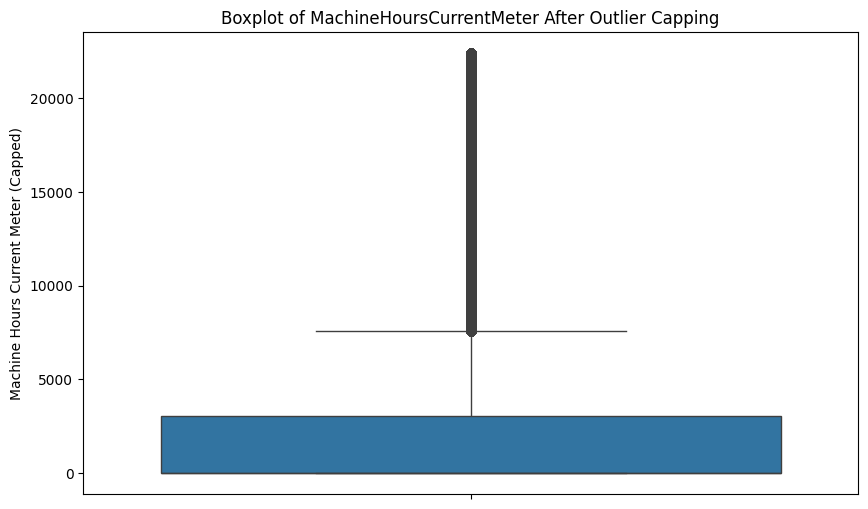

In [ ]:
# MHCM capping at 99th
train_df_12 = train_df_11_frequency.copy()

q99_mhcm = train_df_12['MachineHoursCurrentMeter'].quantile(0.99)
train_df_12['MachineHoursCurrentMeter_capped'] = train_df_12['MachineHoursCurrentMeter'].clip(upper=q99_mhcm)

print(f"MachineHoursCurrentMeter capped at the 99th percentile: {q99_mhcm}")

print("\nMachineHoursCurrentMeter describe after capping:")
print(train_df_12['MachineHoursCurrentMeter_capped'].describe())

plt.figure(figsize=(10, 6))
sns.boxplot(y=train_df_12['MachineHoursCurrentMeter_capped'])
plt.title('Boxplot of MachineHoursCurrentMeter After Outlier Capping')
plt.ylabel('Machine Hours Current Meter (Capped)')
plt.show()

Distribution of MachineHoursCurrentMeter_capped before log transformation:


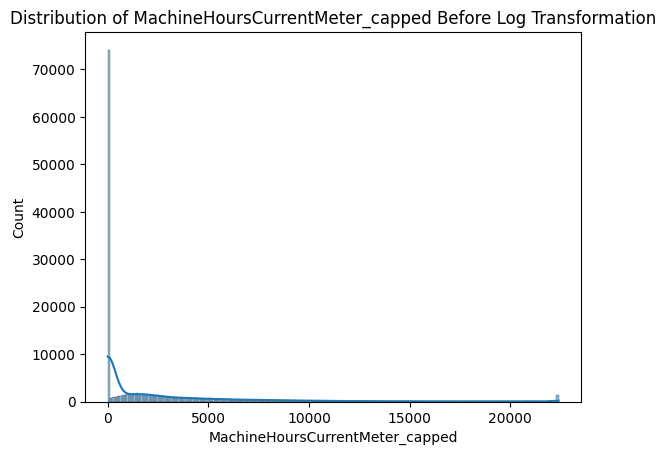


Distribution of MachineHoursCurrentMeter_capped after log transformation (log1p):


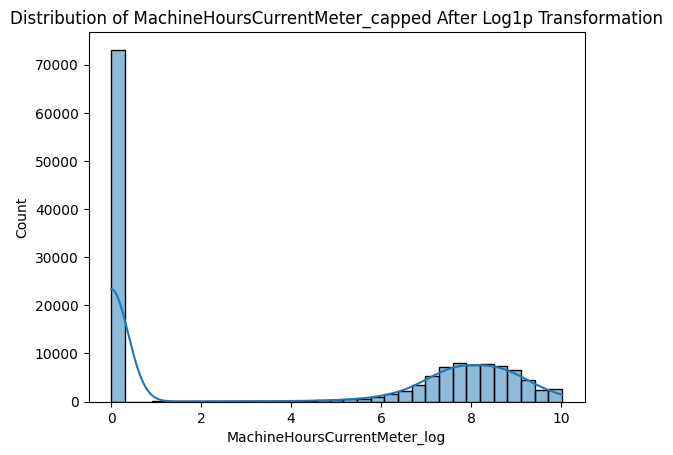


MachineHoursCurrentMeter columns in train_df_13:
       MachineHoursCurrentMeter  MachineHoursCurrentMeter_capped  \
count              1.427650e+05                    142765.000000   
mean               3.457955e+03                      2301.809937   
std                2.759026e+04                      4023.720186   
min                0.000000e+00                         0.000000   
25%                0.000000e+00                         0.000000   
50%                0.000000e+00                         0.000000   
75%                3.025000e+03                      3025.000000   
max                2.483300e+06                     22394.240000   

       MachineHoursCurrentMeter_log  
count                 142765.000000  
mean                       3.886952  
std                        4.061025  
min                        0.000000  
25%                        0.000000  
50%                        0.000000  
75%                        8.014997  
max                       10.0166

In [ ]:
# MHCM log transformation

train_df_13 = train_df_12.copy()

train_df_13['MachineHoursCurrentMeter_log'] = np.log1p(train_df_13['MachineHoursCurrentMeter_capped'])

print("Distribution of MachineHoursCurrentMeter_capped before log transformation:")
sns.histplot(train_df_13['MachineHoursCurrentMeter_capped'], kde=True)
plt.title('Distribution of MachineHoursCurrentMeter_capped Before Log Transformation')
plt.show()

print("\nDistribution of MachineHoursCurrentMeter_capped after log transformation (log1p):")
sns.histplot(train_df_13['MachineHoursCurrentMeter_log'].dropna(), kde=True) # Dropping NaNs for plot
plt.title('Distribution of MachineHoursCurrentMeter_capped After Log1p Transformation')
plt.show()

print("\nMachineHoursCurrentMeter columns in train_df_13:")
print(train_df_13[['MachineHoursCurrentMeter', 'MachineHoursCurrentMeter_capped', 'MachineHoursCurrentMeter_log']].describe())


Number of missing values in 'MachineHoursCurrentMeter_imputed': 0

MachineHoursCurrentMeter columns in train_df_14 after imputation:
       MachineHoursCurrentMeter  MachineHoursCurrentMeter_log  \
count              1.427650e+05                 142765.000000   
mean               3.457955e+03                      3.886952   
std                2.759026e+04                      4.061025   
min                0.000000e+00                      0.000000   
25%                0.000000e+00                      0.000000   
50%                0.000000e+00                      0.000000   
75%                3.025000e+03                      8.014997   
max                2.483300e+06                     10.016604   

       MachineHoursCurrentMeter_imputed  Hours_Available  
count                     401125.000000    401125.000000  
mean                           1.383411         0.355911  
std                            3.055008         0.478789  
min                            0.000000     

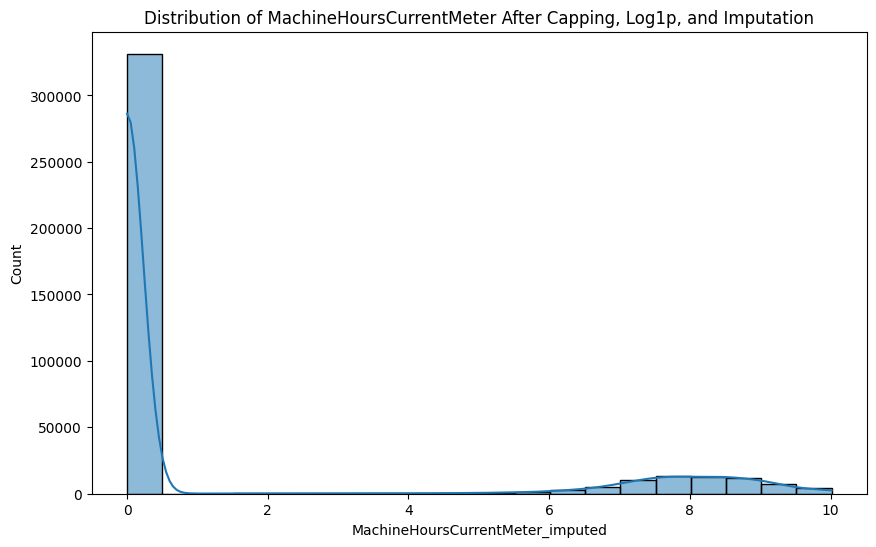


Info after imputation:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401125 entries, 0 to 401124
Data columns (total 4 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   MachineHoursCurrentMeter          142765 non-null  float64
 1   MachineHoursCurrentMeter_log      142765 non-null  float64
 2   MachineHoursCurrentMeter_imputed  401125 non-null  float64
 3   Hours_Available                   401125 non-null  int64  
dtypes: float64(3), int64(1)
memory usage: 12.2 MB
None


In [ ]:
# MHCM Imputation of missing/zeros
train_df_14 = train_df_13.copy()

# for this one, i'm choosing to impute based on the hours available. if there exists a zero in hours, then it will get a zero. but if hours available indicates 1 (as in it's missing), then it will have a 1.

median_log_mhcm_available = train_df_14[train_df_14['Hours_Available'] == 1]['MachineHoursCurrentMeter_log'].median()

# Hours_Available = 1 -> median log
# Hours_Available = 0 -> log(1)=0 -> 0
train_df_14['MachineHoursCurrentMeter_imputed'] = train_df_14.apply(
    lambda row: 0 if row['Hours_Available'] == 0
    else (row['MachineHoursCurrentMeter_log'] if pd.notna(row['MachineHoursCurrentMeter_log']) else median_log_mhcm_available),
    axis=1
)

# Verification
print(f"\nNumber of missing values in 'MachineHoursCurrentMeter_imputed': {train_df_14['MachineHoursCurrentMeter_imputed'].isna().sum()}")

print("\nMachineHoursCurrentMeter columns in train_df_14 after imputation:")
print(train_df_14[['MachineHoursCurrentMeter', 'MachineHoursCurrentMeter_log', 'MachineHoursCurrentMeter_imputed', 'Hours_Available']].describe())

plt.figure(figsize=(10, 6))
sns.histplot(train_df_14['MachineHoursCurrentMeter_imputed'], kde=True)
plt.title('Distribution of MachineHoursCurrentMeter After Capping, Log1p, and Imputation')
plt.show()

print("\nInfo after imputation:")
print(train_df_14[['MachineHoursCurrentMeter', 'MachineHoursCurrentMeter_log', 'MachineHoursCurrentMeter_imputed', 'Hours_Available']].info())

Hours_Value capped at the 99th percentile: 13735.0

Hours_Value describe after capping:
count    401125.000000
mean        767.611715
std        2295.714946
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       13735.000000
Name: Hours_Value_capped, dtype: float64


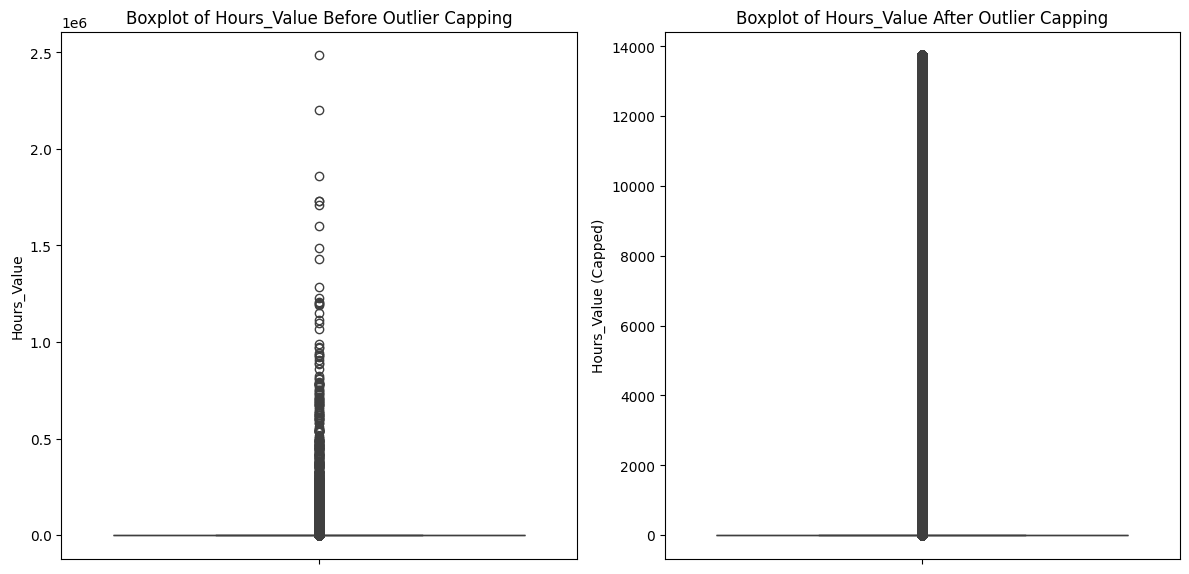

In [ ]:
# Hours_value capping
train_df_15 = train_df_14.copy()

q99_hours_value = train_df_15['Hours_Value'].quantile(0.99)
train_df_15['Hours_Value_capped'] = train_df_15['Hours_Value'].clip(upper=q99_hours_value)

print(f"Hours_Value capped at the 99th percentile: {q99_hours_value}")

print("\nHours_Value describe after capping:")
print(train_df_15['Hours_Value_capped'].describe())

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.boxplot(y=train_df_15['Hours_Value'])
plt.title('Boxplot of Hours_Value Before Outlier Capping')
plt.ylabel('Hours_Value')

plt.subplot(1, 2, 2)
sns.boxplot(y=train_df_15['Hours_Value_capped'])
plt.title('Boxplot of Hours_Value After Outlier Capping')
plt.ylabel('Hours_Value (Capped)')

plt.tight_layout()
plt.show()

Distribution of Hours_Value_capped before log transformation:


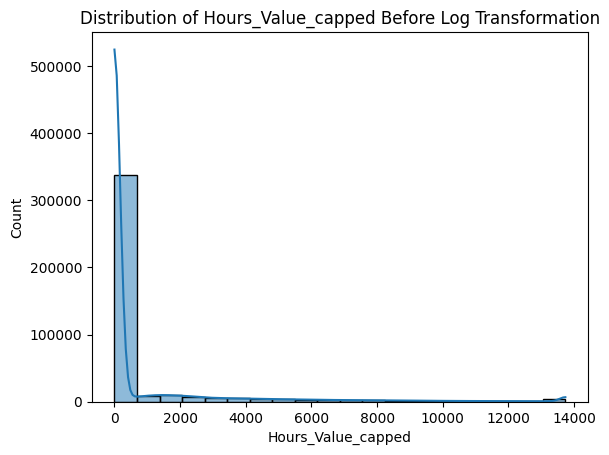


Distribution of Hours_Value_capped after log transformation (log1p):


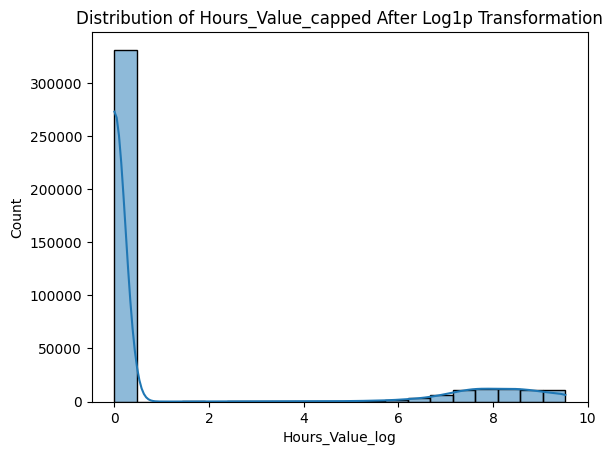


Number of missing values in 'Hours_Value_imputed': 0


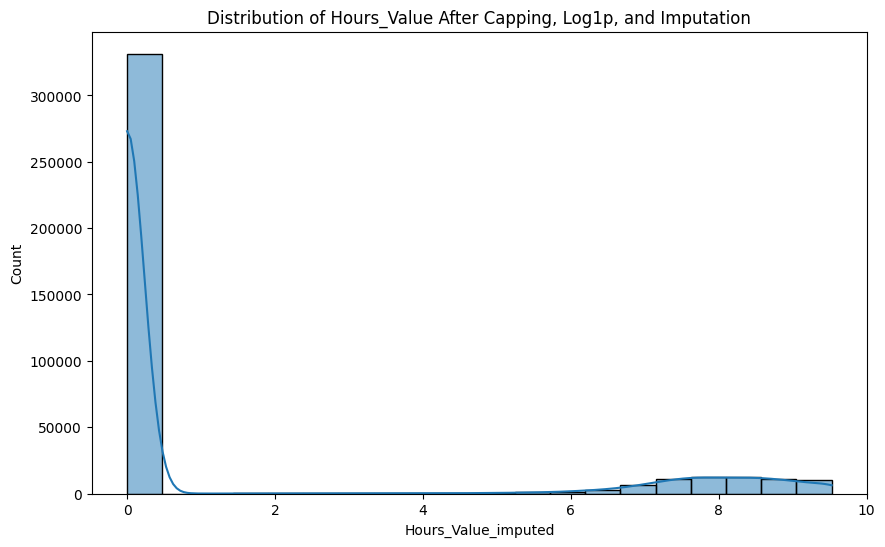


Distribution of Hours_Value after capping, log1p, imputation, and standard scaling:


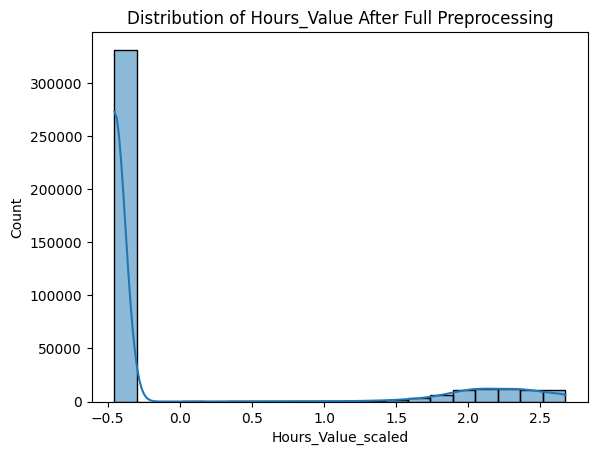

In [ ]:
# Hours_Value log transform + impute missing/zeros + Scale
train_df_16 = train_df_15.copy()

# 1. Log transform
train_df_16['Hours_Value_log'] = np.log1p(train_df_16['Hours_Value_capped'])

print("Distribution of Hours_Value_capped before log transformation:")
sns.histplot(train_df_16['Hours_Value_capped'], kde=True)
plt.title('Distribution of Hours_Value_capped Before Log Transformation')
plt.show()

print("\nDistribution of Hours_Value_capped after log transformation (log1p):")
sns.histplot(train_df_16['Hours_Value_log'], kde=True)
plt.title('Distribution of Hours_Value_capped After Log1p Transformation')
plt.show()

# 2. Imputation missing/zeros
# Filling with median OF THE LOG TRANSFORMED DATA (to avoid div/0)
median_log_hours_value = train_df_16['Hours_Value_log'].median()
train_df_16['Hours_Value_imputed'] = train_df_16['Hours_Value_log'].fillna(median_log_hours_value)

print(f"\nNumber of missing values in 'Hours_Value_imputed': {train_df_16['Hours_Value_imputed'].isna().sum()}")

plt.figure(figsize=(10, 6))
sns.histplot(train_df_16['Hours_Value_imputed'], kde=True)
plt.title('Distribution of Hours_Value After Capping, Log1p, and Imputation')
plt.show()


# 3. Standard scaling
scaler_hours_value = StandardScaler()
train_df_16['Hours_Value_scaled'] = scaler_hours_value.fit_transform(train_df_16[['Hours_Value_imputed']])

print("\nDistribution of Hours_Value after capping, log1p, imputation, and standard scaling:")
sns.histplot(train_df_16['Hours_Value_scaled'], kde=True)
plt.title('Distribution of Hours_Value After Full Preprocessing')
plt.show()

In [ ]:
# AuctioneerID impute + binary flag + frequency encoding
train_df_17 = train_df_16.copy()

train_df_17['auctioneerID'] = train_df_17['auctioneerID'].fillna(-1)
train_df_17['auctioneerID_missing'] = (train_df_17['auctioneerID'] == -1).astype(int)
auctioneer_freq_map = train_df_17['auctioneerID'].value_counts(dropna=False)
train_df_17['auctioneerID_freq'] = train_df_17['auctioneerID'].map(auctioneer_freq_map)

print("Shape after auctioneerID processing:", train_df_17.shape)
print("\nFirst 5 rows showing auctioneerID features:")
print(train_df_17[['auctioneerID', 'auctioneerID_missing', 'auctioneerID_freq']].head())
print("\nDescription of auctioneerID features:")
print(train_df_17[['auctioneerID', 'auctioneerID_missing', 'auctioneerID_freq']].describe())

Shape after auctioneerID processing: (401125, 236)

First 5 rows showing auctioneerID features:
   auctioneerID  auctioneerID_missing  auctioneerID_freq
0           3.0                     0              29076
1           3.0                     0              29076
2           3.0                     0              29076
3           3.0                     0              29076
4           3.0                     0              29076

Description of auctioneerID features:
        auctioneerID  auctioneerID_missing  auctioneerID_freq
count  401125.000000         401125.000000      401125.000000
mean        6.176735              0.050199       99126.006913
std        16.627246              0.218355       81250.419865
min        -1.000000              0.000000         407.000000
25%         1.000000              0.000000       20136.000000
50%         1.000000              0.000000       56440.000000
75%         4.000000              0.000000      185310.000000
max        99.000000       

/tmp/ipython-input-74-481510863.py:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_df_18['Equipment_Age_sqrt'] = np.sqrt(train_df_18['Equipment_Age'].fillna(0))
/tmp/ipython-input-74-481510863.py:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_df_18['Equipment_Age_log'] = np.log1p(train_df_18['Equipment_Age'].fillna(0))


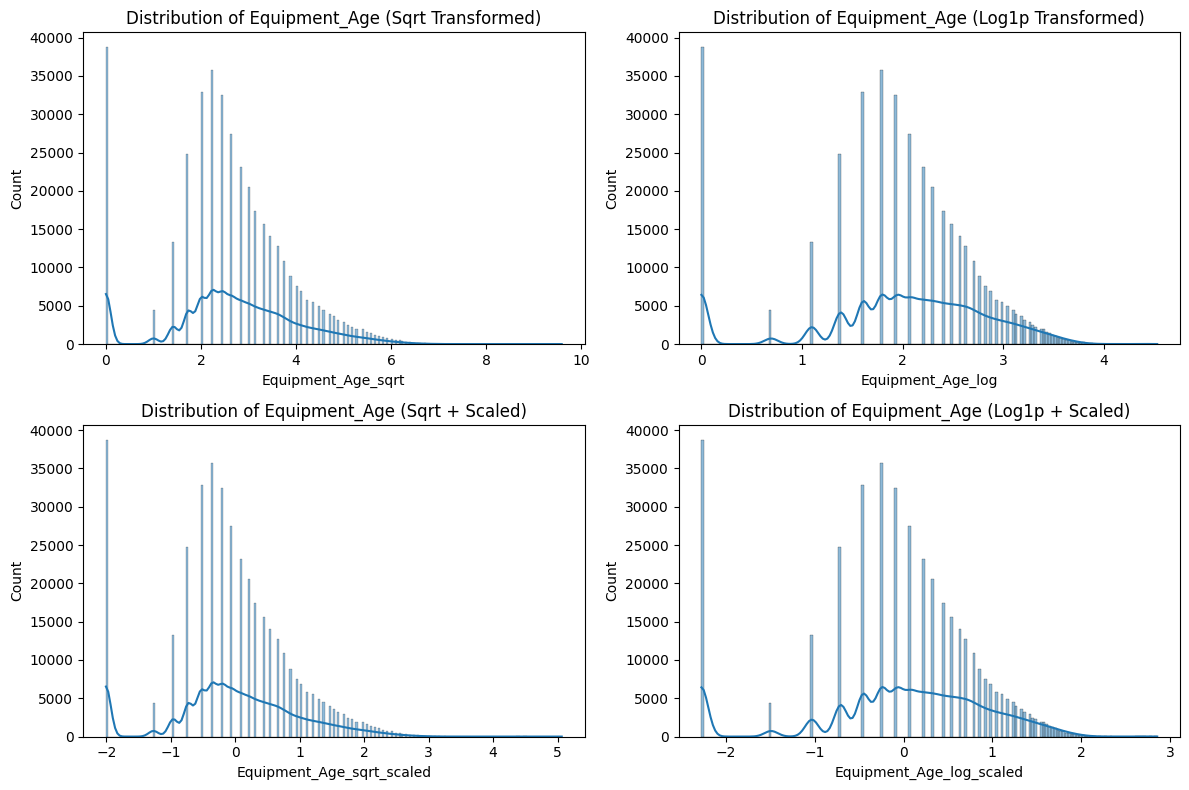


Equipment_Age features in train_df_18:
       Equipment_Age_sqrt  Equipment_Age_log  Equipment_Age_sqrt_scaled  \
count       401125.000000      401125.000000               4.011250e+05   
mean             2.721708           2.009627              -2.023619e-16   
std              1.356465           0.883290               1.000001e+00   
min              0.000000           0.000000              -2.006473e+00   
25%              2.000000           1.609438              -5.320508e-01   
50%              2.645751           2.079442              -5.599582e-02   
75%              3.605551           2.639057               6.515793e-01   
max              9.591663           4.532599               5.064607e+00   

       Equipment_Age_log_scaled  
count              4.011250e+05  
mean               1.456779e-15  
std                1.000001e+00  
min               -2.275163e+00  
25%               -4.530674e-01  
50%                7.903870e-02  
75%                7.125975e-01  
max         

In [ ]:
# Equipment_Age log + squared then scaled each (IMPORTANT: fill nas and remove neg vals)
train_df_18 = train_df_17.copy()

# Replace negative Equipment_Age values with pd.NA
train_df_18.loc[train_df_18['Equipment_Age'] < 0, 'Equipment_Age'] = pd.NA

# Fill NaN values (from original missing and replaced negative ages) with 0 *before* transformation
# The log1p(0) is log(1)=0, sqrt(0)=0, so filling with 0 for both transformations is consistent.
# Applying fillna(0) *before* the transformation is necessary for np.sqrt and np.log1p to work correctly.
train_df_18['Equipment_Age_sqrt'] = np.sqrt(train_df_18['Equipment_Age'].fillna(0))
train_df_18['Equipment_Age_log'] = np.log1p(train_df_18['Equipment_Age'].fillna(0))


scaler_sqrt = StandardScaler()
train_df_18['Equipment_Age_sqrt_scaled'] = scaler_sqrt.fit_transform(train_df_18[['Equipment_Age_sqrt']])

scaler_log = StandardScaler()
train_df_18['Equipment_Age_log_scaled'] = scaler_log.fit_transform(train_df_18[['Equipment_Age_log']])

plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
sns.histplot(train_df_18['Equipment_Age_sqrt'], kde=True)
plt.title('Distribution of Equipment_Age (Sqrt Transformed)')

plt.subplot(2, 2, 2)
sns.histplot(train_df_18['Equipment_Age_log'], kde=True)
plt.title('Distribution of Equipment_Age (Log1p Transformed)')

plt.subplot(2, 2, 3)
sns.histplot(train_df_18['Equipment_Age_sqrt_scaled'], kde=True)
plt.title('Distribution of Equipment_Age (Sqrt + Scaled)')

plt.subplot(2, 2, 4)
sns.histplot(train_df_18['Equipment_Age_log_scaled'], kde=True)
plt.title('Distribution of Equipment_Age (Log1p + Scaled)')

plt.tight_layout()
plt.show()

print("\nEquipment_Age features in train_df_18:")
print(train_df_18[['Equipment_Age', 'Equipment_Age_sqrt', 'Equipment_Age_log', 'Equipment_Age_sqrt_scaled', 'Equipment_Age_log_scaled']].describe())

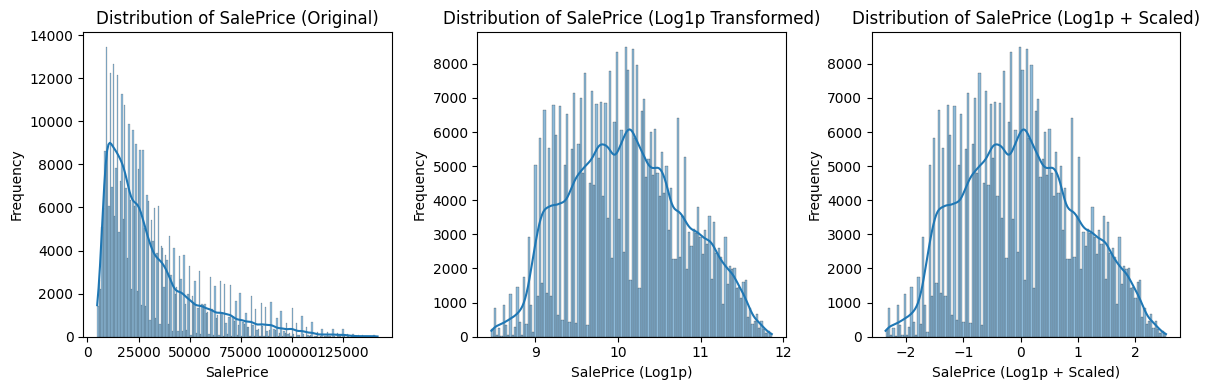


SalePrice columns in train_df_19:
           SalePrice  SalePrice_log  SalePrice_scaled
count  401125.000000  401125.000000      4.011250e+05
mean    31099.712848      10.103147     -3.244025e-15
std     23036.898502       0.693589      1.000001e+00
min      4750.000000       8.466110     -2.360245e+00
25%     14500.000000       9.581973     -7.514182e-01
50%     24000.000000      10.085851     -2.493788e-02
75%     40000.000000      10.596660      7.115355e-01
max    142000.000000      11.863589      2.538168e+00


In [ ]:
# SalePrice log + scale

train_df_19 = train_df_18.copy()

train_df_19['SalePrice_log'] = np.log1p(train_df_19['SalePrice'])
scaler_salesprice = StandardScaler()
train_df_19['SalePrice_scaled'] = scaler_salesprice.fit_transform(train_df_19[['SalePrice_log']])

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
sns.histplot(train_df_19['SalePrice'], kde=True)
plt.title('Distribution of SalePrice (Original)')
plt.xlabel('SalePrice')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
sns.histplot(train_df_19['SalePrice_log'], kde=True)
plt.title('Distribution of SalePrice (Log1p Transformed)')
plt.xlabel('SalePrice (Log1p)')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
sns.histplot(train_df_19['SalePrice_scaled'], kde=True)
plt.title('Distribution of SalePrice (Log1p + Scaled)')
plt.xlabel('SalePrice (Log1p + Scaled)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

print("\nSalePrice columns in train_df_19:")
print(train_df_19[['SalePrice', 'SalePrice_log', 'SalePrice_scaled']].describe())

In [ ]:
# Inverse transform
# predicted_dollars = np.expm1(predicted_scaled_log_saleprice)

In [ ]:
print(f"Initial train_df shape: {train_df.shape}")
print(f"train_df_19 shape: {train_df_19.shape}")

Initial train_df shape: (401125, 53)
train_df_19 shape: (401125, 242)


In [ ]:
new_features_train_df_19 = [col for col in train_df_19.columns if col not in train_df.columns]
print("New features added to train_df_19:")
new_features_train_df_19

New features added to train_df_19:


['Hours_Available',
 'Hours_Value',
 'Equipment_Age',
 'Estimated_Hours',
 'Estimated_Hours_log',
 'Estimated_Hours_scaled',
 'Pad_Type_Grouser',
 'Pad_Type_None or Unspecified',
 'Pad_Type_Reversible',
 'Pad_Type_Street',
 'Stick_Extended',
 'Stick_Standard',
 'Ride_Control_No',
 'Ride_Control_None or Unspecified',
 'Ride_Control_Yes',
 'Transmission_AutoShift',
 'Transmission_Autoshift',
 'Transmission_Direct Drive',
 'Transmission_Hydrostatic',
 'Transmission_None or Unspecified',
 'Transmission_Powershift',
 'Transmission_Powershuttle',
 'Transmission_Standard',
 'Turbocharged_None or Unspecified',
 'Turbocharged_Yes',
 'Blade_Extension_None or Unspecified',
 'Blade_Extension_Yes',
 "Blade_Width_12'",
 "Blade_Width_13'",
 "Blade_Width_14'",
 "Blade_Width_16'",
 "Blade_Width_<12'",
 'Blade_Width_None or Unspecified',
 'Tip_Control_None or Unspecified',
 'Tip_Control_Sideshift & Tip',
 'Tip_Control_Tip',
 'Pushblock_None or Unspecified',
 'Pushblock_Yes',
 'Ripper_Multi Shank',
 'Rip

### Secondary Datasets


#### Prep and merge

In [ ]:
# Map building permit data

train_df_20_permits = train_df_19.copy()

month_map = {
    1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
    7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'
}
building_permits_df['per_month'] = building_permits_df['per_idx'].map(month_map)
train_df_20_permits['sale_month'] = train_df_20_permits['saledate'].dt.strftime('%b')
building_permits_monthly_avg = building_permits_df.groupby('per_month')['val'].mean().reset_index()
building_permits_monthly_avg.rename(columns={'per_month': 'sale_month', 'val': 'avg_building_permits_val'}, inplace=True)

# The merge (left join)
train_df_20_permits = pd.merge(
    train_df_20_permits,
    building_permits_monthly_avg,
    on='sale_month',
    how='left'
)

print(train_df_20_permits[['saledate', 'sale_month', 'avg_building_permits_val']].head())
print(train_df_20_permits[['saledate', 'sale_month', 'avg_building_permits_val']].tail())

# Check for any months in train_df that didn't match building_permits_df
print("\nMissing avg_building_permits_val after merge:")
print(train_df_20_permits[train_df_20_permits['avg_building_permits_val'].isna()]['sale_month'].value_counts())

# If there are missing values, impute them or handle them based with regression.

print("\nInfo after merging building permits data:")
print(train_df_20_permits[['saledate', 'sale_month', 'avg_building_permits_val']].info())

    saledate sale_month  avg_building_permits_val
0 2006-11-16        Nov              16012.064236
1 2004-03-26        Mar              31988.743750
2 2004-02-26        Feb              32567.803472
3 2011-05-19        May              32471.103472
4 2009-07-23        Jul              16170.215625
         saledate sale_month  avg_building_permits_val
401120 2011-11-02        Nov              16012.064236
401121 2011-11-02        Nov              16012.064236
401122 2011-11-02        Nov              16012.064236
401123 2011-10-25        Oct              16022.502431
401124 2011-10-25        Oct              16022.502431

Missing avg_building_permits_val after merge:
Series([], Name: count, dtype: int64)

Info after merging building permits data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401125 entries, 0 to 401124
Data columns (total 3 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   s

**CHECKPOINT**

In [ ]:
train_df_20_permits.to_csv('train_df_20_permits.csv', index=False)

In [ ]:
train_df_20_permits = pd.read_csv('train_df_20.csv')

/tmp/ipython-input-4-643776891.py:1: DtypeWarning: Columns (10,12,13,16,17,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df_20_permits = pd.read_csv('train_df_20.csv')


In [ ]:
train_df_20_permits.shape

(401125, 244)

In [ ]:
# Auction Volume prep
auction_volume_df_1 = auction_volume_df.copy()

auction_volume_df_1['Auction Date'] = pd.to_datetime(auction_volume_df_1['Auction Date'])
auction_volume_df_1['Price per $100'] = auction_volume_df_1['Price per $100'].astype(str).str.replace('$', '', regex=False).str.replace(',', '', regex=False)
auction_volume_df_1['Price per $100'] = pd.to_numeric(auction_volume_df_1['Price per $100'], errors='coerce')
auction_volume_df_1['Maturity Date'] = pd.to_datetime(auction_volume_df_1['Maturity Date'], errors='coerce')

print("Info after conversions:")
print(auction_volume_df_1.info())

Info after conversions:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10565 entries, 0 to 10564
Data columns (total 12 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   CUSIP                                  10565 non-null  object        
 1   Security Type                          10565 non-null  object        
 2   Security Term                          10565 non-null  object        
 3   Auction Date                           10565 non-null  datetime64[ns]
 4   Issue Date                             10565 non-null  object        
 5   Maturity Date                          10565 non-null  datetime64[ns]
 6   Price per $100                         7644 non-null   float64       
 7   Download PDF - Announcement            7545 non-null   object        
 8   Download PDF - Competitive Results     7539 non-null   object        
 9   Download PDF - Noncompetitive Results

In [ ]:
# Auction volume join
train_df_21_aucvol = train_df_20_permits.copy()

train_df_21_aucvol['saledate'] = pd.to_datetime(train_df_21_aucvol['saledate'])
auction_volume_df_1['Auction Date'] = pd.to_datetime(auction_volume_df_1['Auction Date'])

train_df_21_aucvol = pd.merge(
    train_df_21_aucvol,
    auction_volume_df_1[['Auction Date', 'Price per $100', 'Maturity Date']],
    left_on='saledate',
    right_on='Auction Date',
    how='left'
)

train_df_21_aucvol = train_df_21_aucvol.drop(columns=['Auction Date'])

print("Info after merging Auction Volume data:")
print(train_df_21_aucvol[['saledate', 'Price per $100', 'Maturity Date']].info())

print("\nFirst 5 rows after merging Auction Volume data:")
print(train_df_21_aucvol[['saledate', 'Price per $100', 'Maturity Date']].head())

print("\nNumber of missing values in merged columns:")
print(train_df_21_aucvol[['Price per $100', 'Maturity Date']].isna().sum())

Info after merging Auction Volume data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 469663 entries, 0 to 469662
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   saledate        469663 non-null  datetime64[ns]
 1   Price per $100  219137 non-null  float64       
 2   Maturity Date   241358 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(1)
memory usage: 10.7 MB
None

First 5 rows after merging Auction Volume data:
    saledate  Price per $100 Maturity Date
0 2006-11-16             NaN           NaT
1 2004-03-26             NaN           NaT
2 2004-02-26             NaN           NaT
3 2011-05-19      104.359972    2021-01-15
4 2009-07-23             NaN           NaT

Number of missing values in merged columns:
Price per $100    250526
Maturity Date     228305
dtype: int64


In [ ]:
# Business confidence prep

BCI_df_1 = BCI_df.copy()


BCI_df_1['Category'] = pd.to_datetime(BCI_df_1['Category'])
BCI_df_1['OECD'] = pd.to_numeric(BCI_df_1['OECD'], errors='coerce')

print("Info after conversions:")
print(BCI_df_1.info())

print("\nFirst 5 rows after conversions:")
print(BCI_df_1.head())


Info after conversions:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346 entries, 0 to 345
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Category  346 non-null    datetime64[ns]
 1   OECD      346 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 5.5 KB
None

First 5 rows after conversions:
    Category       OECD
0 1985-10-01   99.96008
1 1985-11-01  100.00520
2 1985-12-01   99.96054
3 1986-01-01   99.88689
4 1986-02-01   99.84046


Info after merging Business Confidence Index (OECD) data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 469663 entries, 0 to 469662
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   saledate  469663 non-null  datetime64[ns]
 1   OECD      11312 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 7.2 MB
None

First 5 rows after merging BCI (OECD) data:
    saledate  OECD
0 2006-11-16   NaN
1 2004-03-26   NaN
2 2004-02-26   NaN
3 2011-05-19   NaN
4 2009-07-23   NaN

Number of missing values in OECD column after merge:
458351


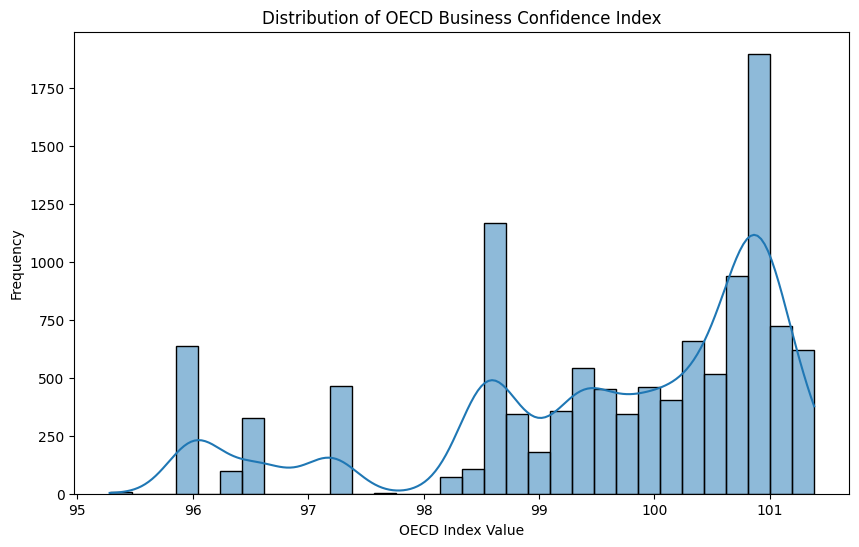


Number of missing values in OECD column after imputation:
30

Info after merging and imputing BCI (OECD) data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 469663 entries, 0 to 469662
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   saledate  469663 non-null  datetime64[ns]
 1   OECD      469633 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 7.2 MB
None


/tmp/ipython-input-86-1607734883.py:36: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_df_22['OECD'] = train_df_22['OECD'].fillna(method='ffill')


In [ ]:
# Merging business confidence index to train

train_df_22 = train_df_21_aucvol.copy()

train_df_22['saledate'] = pd.to_datetime(train_df_22['saledate'])
BCI_df_1['Category'] = pd.to_datetime(BCI_df_1['Category'])

train_df_22 = pd.merge(
    train_df_22,
    BCI_df_1[['Category', 'OECD']],
    left_on='saledate',
    right_on='Category',
    how='left'
)

train_df_22 = train_df_22.drop(columns=['Category'])

print("Info after merging Business Confidence Index (OECD) data:")
print(train_df_22[['saledate', 'OECD']].info())

print("\nFirst 5 rows after merging BCI (OECD) data:")
print(train_df_22[['saledate', 'OECD']].head())

print("\nNumber of missing values in OECD column after merge:")
print(train_df_22['OECD'].isna().sum())


plt.figure(figsize=(10, 6))
sns.histplot(train_df_22['OECD'].dropna(), kde=True)
plt.title('Distribution of OECD Business Confidence Index')
plt.xlabel('OECD Index Value')
plt.ylabel('Frequency')
plt.show()

# Decision: Impute missing OECD values using forward fill
train_df_22['OECD'] = train_df_22['OECD'].fillna(method='ffill')

print("\nNumber of missing values in OECD column after imputation:")
print(train_df_22['OECD'].isna().sum())

print("\nInfo after merging and imputing BCI (OECD) data:")
print(train_df_22[['saledate', 'OECD']].info())

In [ ]:
# Construction spending prep. I have to scale this bc TTLCONS is in the millions (converting to billions)

construction_spending_df_1 = construction_spending_df.copy()

construction_spending_df_1['observation_date'] = pd.to_datetime(construction_spending_df_1['observation_date'])

construction_spending_df_1['TTLCONS'] = pd.to_numeric(construction_spending_df_1['TTLCONS'], errors='coerce')

construction_spending_df_1['TTLCONS_scaled_billions'] = construction_spending_df_1['TTLCONS'] / 1000

print("Info after converting 'observation_date' and converting/scaling 'TTLCONS':")
print(construction_spending_df_1.info())

print("\nFirst 5 rows after conversions/scaling:")
print(construction_spending_df_1.head())

print("\nDescription of TTLCONS and scaled TTLCONS:")
print(construction_spending_df_1[['TTLCONS', 'TTLCONS_scaled_billions']].describe())


Info after converting 'observation_date' and converting/scaling 'TTLCONS':
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388 entries, 0 to 387
Data columns (total 3 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   observation_date         388 non-null    datetime64[ns]
 1   TTLCONS                  388 non-null    int64         
 2   TTLCONS_scaled_billions  388 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 9.2 KB
None

First 5 rows after conversions/scaling:
  observation_date  TTLCONS  TTLCONS_scaled_billions
0       1993-01-01   458080                  458.080
1       1993-02-01   462967                  462.967
2       1993-03-01   458399                  458.399
3       1993-04-01   469425                  469.425
4       1993-05-01   468998                  468.998

Description of TTLCONS and scaled TTLCONS:
            TTLCONS  TTLCONS_scaled_bil

Info after merging Construction Spending Index (TTLCONS) data:
<class 'pandas.core.frame.DataFrame'>
Index: 469663 entries, 234056 to 460760
Data columns (total 2 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   saledate                 469663 non-null  datetime64[ns]
 1   TTLCONS_scaled_billions  448290 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 10.7 MB
None

First 5 rows after merging TTLCONS data:
         saledate  TTLCONS_scaled_billions
234056 2006-11-16                 1121.749
173360 2004-03-26                  961.159
171050 2004-02-26                  937.813
440973 2011-05-19                  775.251
360895 2009-07-23                  911.438

Number of missing values in TTLCONS_scaled_billions after merge:
21373


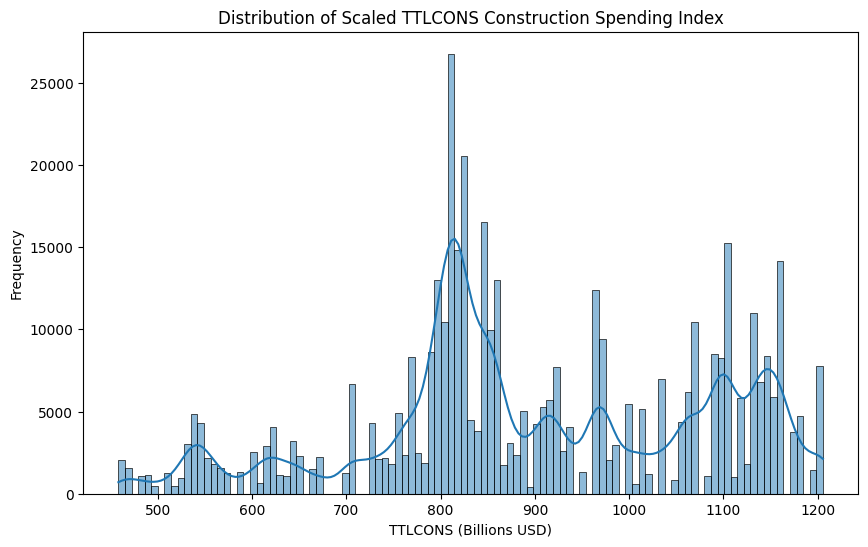


Number of missing values in TTLCONS_scaled_billions column after imputation:
0


/tmp/ipython-input-90-2077007535.py:37: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_df_23['TTLCONS_scaled_billions'] = train_df_23['TTLCONS_scaled_billions'].fillna(method='ffill')


In [ ]:
# Construction spending merge

!pip install pandas>=0.19.0
train_df_23 = train_df_22.copy()

train_df_23['saledate'] = pd.to_datetime(train_df_23['saledate'])
construction_spending_df_1['observation_date'] = pd.to_datetime(construction_spending_df_1['observation_date'])

# Merge based on the closest preceding date
train_df_23 = pd.merge_asof(
    train_df_23.sort_values('saledate'),
    construction_spending_df_1.sort_values('observation_date')[['observation_date', 'TTLCONS_scaled_billions']],
    left_on='saledate',
    right_on='observation_date',
    direction='backward' # Using the observation date that is closest to the saledate but no later than the saledate. AKA backward
)

train_df_23 = train_df_23.drop(columns=['observation_date']).sort_values('SalesID')

print("Info after merging Construction Spending Index (TTLCONS) data:")
print(train_df_23[['saledate', 'TTLCONS_scaled_billions']].info())

print("\nFirst 5 rows after merging TTLCONS data:")
print(train_df_23[['saledate', 'TTLCONS_scaled_billions']].head())

print("\nNumber of missing values in TTLCONS_scaled_billions after merge:")
print(train_df_23['TTLCONS_scaled_billions'].isna().sum())

plt.figure(figsize=(10, 6))
sns.histplot(train_df_23['TTLCONS_scaled_billions'].dropna(), kde=True)
plt.title('Distribution of Scaled TTLCONS Construction Spending Index')
plt.xlabel('TTLCONS (Billions USD)')
plt.ylabel('Frequency')
plt.show()

# Imputing missing values w/ forward fill
train_df_23['TTLCONS_scaled_billions'] = train_df_23['TTLCONS_scaled_billions'].fillna(method='ffill')

print("\nNumber of missing values in TTLCONS_scaled_billions column after imputation:")
print(train_df_23['TTLCONS_scaled_billions'].isna().sum())

In [ ]:
# Copper price prep

copper_price_df_1 = copper_price_df.copy()

copper_price_df_1['observation_date'] = pd.to_datetime(copper_price_df_1['observation_date'])
copper_price_df_1['PCOPPUSDM'] = pd.to_numeric(copper_price_df_1['PCOPPUSDM'], errors='coerce')

print("Info after conversions:")
print(copper_price_df_1.info())

print("\nFirst 5 rows after conversions:")
print(copper_price_df_1.head())

Info after conversions:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 424 entries, 0 to 423
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   observation_date  424 non-null    datetime64[ns]
 1   PCOPPUSDM         424 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 6.8 KB
None

First 5 rows after conversions:
  observation_date    PCOPPUSDM
0       1990-01-01  2365.556991
1       1990-02-01  2358.943400
2       1990-03-01  2625.702723
3       1990-04-01  2685.226891
4       1990-05-01  2740.342391


Info after merging Copper Prices (PCOPPUSDM) data:
<class 'pandas.core.frame.DataFrame'>
Index: 469663 entries, 234056 to 460760
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   saledate   469663 non-null  datetime64[ns]
 1   PCOPPUSDM  464564 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 10.7 MB
None

First 5 rows after merging Copper Prices data:
         saledate    PCOPPUSDM
234056 2006-11-16  7029.295455
173360 2004-03-26  3000.282609
171050 2004-02-26  2751.717500
440973 2011-05-19  8931.675000
360895 2009-07-23  5228.413043

Number of missing values in PCOPPUSDM after merge:
5099


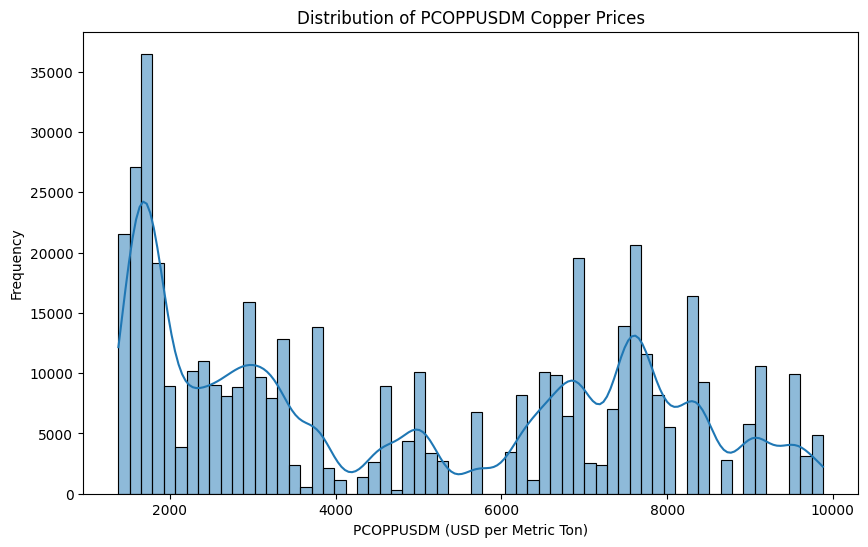


Number of missing values in PCOPPUSDM column after imputation:
0

Info after merging and imputing Copper Prices data:
<class 'pandas.core.frame.DataFrame'>
Index: 469663 entries, 234056 to 460760
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   saledate   469663 non-null  datetime64[ns]
 1   PCOPPUSDM  469663 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 10.7 MB
None


/tmp/ipython-input-92-4002778981.py:36: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_df_24['PCOPPUSDM'] = train_df_24['PCOPPUSDM'].fillna(method='ffill')


In [ ]:
# Copper prices merged

train_df_24 = train_df_23.copy()

train_df_24['saledate'] = pd.to_datetime(train_df_24['saledate'])
copper_price_df_1['observation_date'] = pd.to_datetime(copper_price_df_1['observation_date'])

# Merged based on the closest preceding date
train_df_24 = pd.merge_asof(
    train_df_24.sort_values('saledate'),
    copper_price_df_1.sort_values('observation_date')[['observation_date', 'PCOPPUSDM']],
    left_on='saledate',
    right_on='observation_date',
    direction='backward'
)

train_df_24 = train_df_24.drop(columns=['observation_date']).sort_values('SalesID')

print("Info after merging Copper Prices (PCOPPUSDM) data:")
print(train_df_24[['saledate', 'PCOPPUSDM']].info())

print("\nFirst 5 rows after merging Copper Prices data:")
print(train_df_24[['saledate', 'PCOPPUSDM']].head())

print("\nNumber of missing values in PCOPPUSDM after merge:")
print(train_df_24['PCOPPUSDM'].isna().sum())

plt.figure(figsize=(10, 6))
sns.histplot(train_df_24['PCOPPUSDM'].dropna(), kde=True)
plt.title('Distribution of PCOPPUSDM Copper Prices')
plt.xlabel('PCOPPUSDM (USD per Metric Ton)')
plt.ylabel('Frequency')
plt.show()

# Imputing missing values w/ forward fill
train_df_24['PCOPPUSDM'] = train_df_24['PCOPPUSDM'].fillna(method='ffill')

print("\nNumber of missing values in PCOPPUSDM column after imputation:")
print(train_df_24['PCOPPUSDM'].isna().sum())

print("\nInfo after merging and imputing Copper Prices data:")
print(train_df_24[['saledate', 'PCOPPUSDM']].info())

In [ ]:
# Dealer inventory prep
dealer_inventory_df_1 = dealer_inventory_df.copy()

dealer_inventory_df_1['observation_date'] = pd.to_datetime(dealer_inventory_df_1['observation_date'])
dealer_inventory_df_1['U33CTI'] = pd.to_numeric(dealer_inventory_df_1['U33CTI'], errors='coerce')

print("Info after conversions:")
print(dealer_inventory_df_1.info())

print("\nFirst 5 rows after conversions:")
print(dealer_inventory_df_1.head())


Info after conversions:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   observation_date  400 non-null    datetime64[ns]
 1   U33CTI            400 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 6.4 KB
None

First 5 rows after conversions:
  observation_date  U33CTI
0       1992-01-01    2923
1       1992-02-01    2891
2       1992-03-01    2856
3       1992-04-01    2805
4       1992-05-01    2789



Description of U33CTI:
count      400.000000
mean      4961.500000
std       1903.326608
min       2677.000000
25%       3507.000000
50%       4767.000000
75%       5799.000000
max      10452.000000
Name: U33CTI, dtype: float64


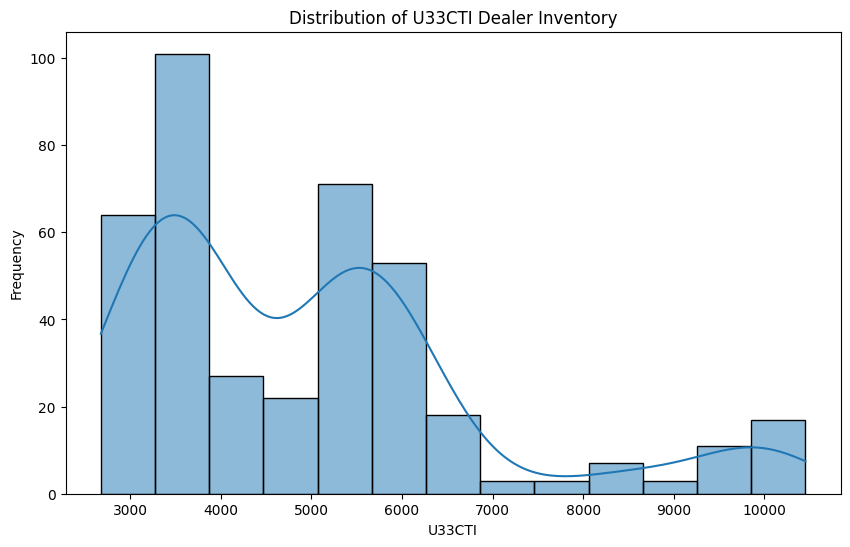


Value counts for U33CTI:
U33CTI
5556    3
3822    3
2989    2
2911    2
3842    2
Name: count, dtype: int64

Checking for negative U33CTI values:
0

Missing values in U33CTI:
0


In [ ]:
# verifying consistency...

print("\nDescription of U33CTI:")
print(dealer_inventory_df_1['U33CTI'].describe())

plt.figure(figsize=(10, 6))
sns.histplot(dealer_inventory_df_1['U33CTI'].dropna(), kde=True)
plt.title('Distribution of U33CTI Dealer Inventory')
plt.xlabel('U33CTI')
plt.ylabel('Frequency')
plt.show()

print("\nValue counts for U33CTI:")
print(dealer_inventory_df_1['U33CTI'].value_counts(dropna=False).head())

print("\nChecking for negative U33CTI values:")
print(dealer_inventory_df_1[dealer_inventory_df_1['U33CTI'] < 0]['U33CTI'].count())

# Check for missing values
print("\nMissing values in U33CTI:")
print(dealer_inventory_df_1['U33CTI'].isna().sum())

Info after merging Dealer Inventory Levels (U33CTI) data:
<class 'pandas.core.frame.DataFrame'>
Index: 469663 entries, 234056 to 460760
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   saledate  469663 non-null  datetime64[ns]
 1   U33CTI    453896 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 10.7 MB
None

First 5 rows after merging U33CTI data:
         saledate  U33CTI
234056 2006-11-16  5102.0
173360 2004-03-26  3024.0
171050 2004-02-26  3023.0
440973 2011-05-19  4686.0
360895 2009-07-23  4339.0

Number of missing values in U33CTI after merge:
15767


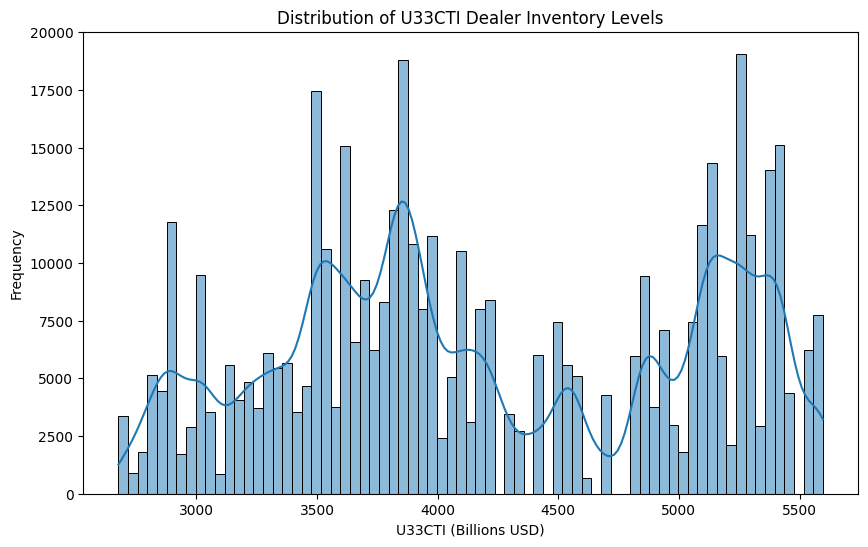


Number of missing values in U33CTI column after imputation:
15767

Info after merging and imputing Dealer Inventory Levels data:
<class 'pandas.core.frame.DataFrame'>
Index: 469663 entries, 234056 to 460760
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   saledate  469663 non-null  datetime64[ns]
 1   U33CTI    453896 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 10.7 MB
None


In [ ]:
# Merging dealer inventory

train_df_25 = train_df_24.copy()

dealer_inventory_df_1['observation_date'] = pd.to_datetime(dealer_inventory_df_1['observation_date'])

# Merge is based on the closest preceding date
train_df_25 = pd.merge_asof(
    train_df_25.sort_values('saledate'),
    dealer_inventory_df_1.sort_values('observation_date')[['observation_date', 'U33CTI']],
    left_on='saledate',
    right_on='observation_date',
    direction='backward'
)

train_df_25 = train_df_25.drop(columns=['observation_date']).sort_values('SalesID')

print("Info after merging Dealer Inventory Levels (U33CTI) data:")
print(train_df_25[['saledate', 'U33CTI']].info())

print("\nFirst 5 rows after merging U33CTI data:")
print(train_df_25[['saledate', 'U33CTI']].head())

print("\nNumber of missing values in U33CTI after merge:")
print(train_df_25['U33CTI'].isna().sum())

plt.figure(figsize=(10, 6))
sns.histplot(train_df_25['U33CTI'].dropna(), kde=True)
plt.title('Distribution of U33CTI Dealer Inventory Levels')
plt.xlabel('U33CTI (Billions USD)')
plt.ylabel('Frequency')
plt.show()

print("\nNumber of missing values in U33CTI column after imputation:")
print(train_df_25['U33CTI'].isna().sum())

print("\nInfo after merging and imputing Dealer Inventory Levels data:")
print(train_df_25[['saledate', 'U33CTI']].info())

**CHECKPOINT**

In [ ]:
train_df_25.to_csv('train_df_25.csv', index=False)

In [ ]:
# Exchange rate prep

exchange_rate_df_1 = exchange_rate_df.copy()

exchange_rate_df_1['observation_date'] = pd.to_datetime(exchange_rate_df_1['observation_date'])
exchange_rate_df_1['TWEXM'] = pd.to_numeric(exchange_rate_df_1['TWEXM'], errors='coerce')

Info after merging Exchange Rates (TWEXM) data:
<class 'pandas.core.frame.DataFrame'>
Index: 469663 entries, 234056 to 460760
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   saledate  469663 non-null  datetime64[ns]
 1   TWEXM     469663 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 10.7 MB
None

First 5 rows after merging TWEXM data:
         saledate    TWEXM
234056 2006-11-16  81.8702
173360 2004-03-26  86.1738
171050 2004-02-26  85.4826
440973 2011-05-19  70.0060
360895 2009-07-23  76.0748

Number of missing values in TWEXM after merge:
0


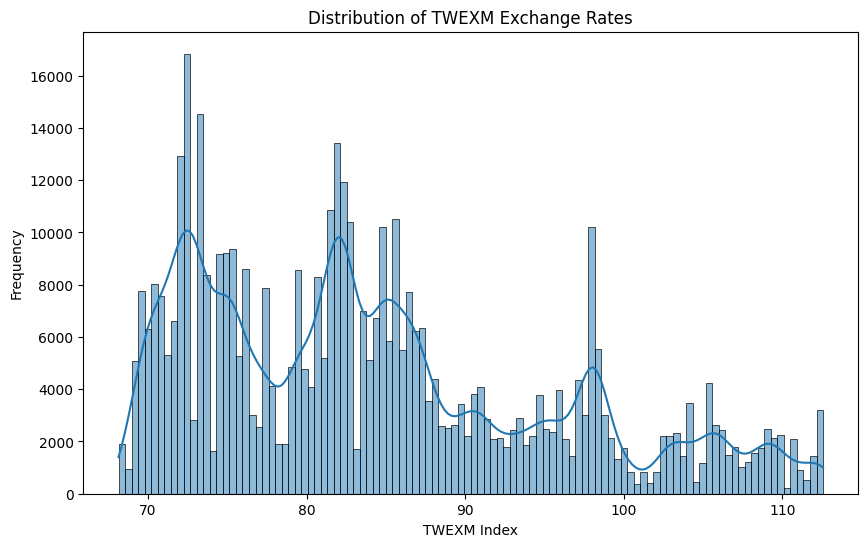


Number of missing values in TWEXM column after imputation:
0

Info after merging and imputing Exchange Rates data:
<class 'pandas.core.frame.DataFrame'>
Index: 469663 entries, 234056 to 460760
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   saledate  469663 non-null  datetime64[ns]
 1   TWEXM     469663 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 10.7 MB
None


In [ ]:
# Exchange rate join
train_df_26 = train_df_25.copy()

exchange_rate_df_1['observation_date'] = pd.to_datetime(exchange_rate_df_1['observation_date'])

# Merge based on the closest preceding date
train_df_26 = pd.merge_asof(
    train_df_26.sort_values('saledate'),
    exchange_rate_df_1.sort_values('observation_date')[['observation_date', 'TWEXM']],
    left_on='saledate',
    right_on='observation_date',
    direction='backward'
)

train_df_26 = train_df_26.drop(columns=['observation_date']).sort_values('SalesID')

print("Info after merging Exchange Rates (TWEXM) data:")
print(train_df_26[['saledate', 'TWEXM']].info())

print("\nFirst 5 rows after merging TWEXM data:")
print(train_df_26[['saledate', 'TWEXM']].head())

print("\nNumber of missing values in TWEXM after merge:")
print(train_df_26['TWEXM'].isna().sum())

plt.figure(figsize=(10, 6))
sns.histplot(train_df_26['TWEXM'].dropna(), kde=True)
plt.title('Distribution of TWEXM Exchange Rates')
plt.xlabel('TWEXM Index')
plt.ylabel('Frequency')
plt.show()


print("\nNumber of missing values in TWEXM column after imputation:")
print(train_df_26['TWEXM'].isna().sum())

print("\nInfo after merging and imputing Exchange Rates data:")
print(train_df_26[['saledate', 'TWEXM']].info())


Number of missing values in GDPC1 after merge:
0


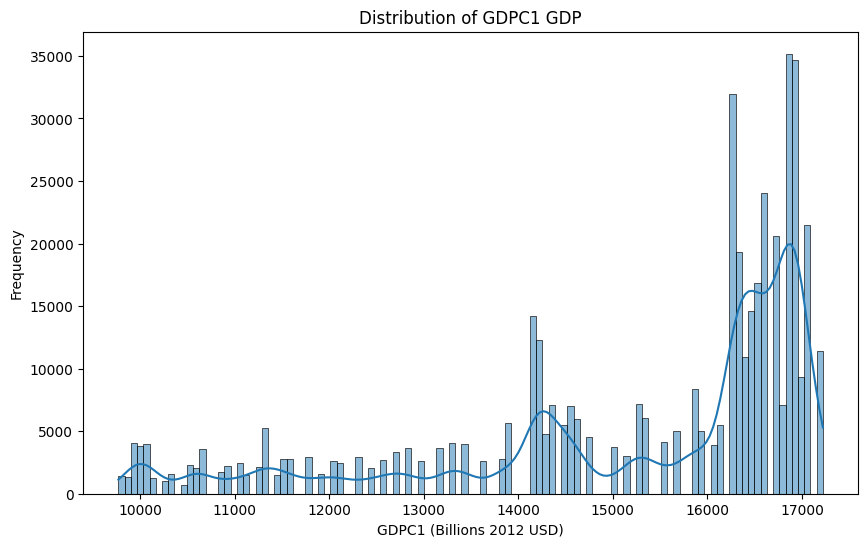

In [ ]:
# GDP

train_df_27 = train_df_26.copy()
gdp_df_1 = gdp_df.copy()

gdp_df_1['observation_date'] = pd.to_datetime(gdp_df_1['observation_date'])
gdp_df_1['GDPC1'] = pd.to_numeric(gdp_df_1['GDPC1'], errors='coerce')

train_df_27['saledate'] = pd.to_datetime(train_df_27['saledate'])

# Merge is based on the closest preceding date, aligning quarterly data. This will find the latest GDP observation_date on or before the saledate
train_df_27 = pd.merge_asof(
    train_df_27.sort_values('saledate'),
    gdp_df_1.sort_values('observation_date')[['observation_date', 'GDPC1']],
    left_on='saledate',
    right_on='observation_date',
    direction='backward'
)

train_df_27 = train_df_27.drop(columns=['observation_date']).sort_values('SalesID')

print("\nNumber of missing values in GDPC1 after merge:")
print(train_df_27['GDPC1'].isna().sum())

plt.figure(figsize=(10, 6))
sns.histplot(train_df_27['GDPC1'].dropna(), kde=True)
plt.title('Distribution of GDPC1 GDP')
plt.xlabel('GDPC1 (Billions 2012 USD)')
plt.ylabel('Frequency')
plt.show()

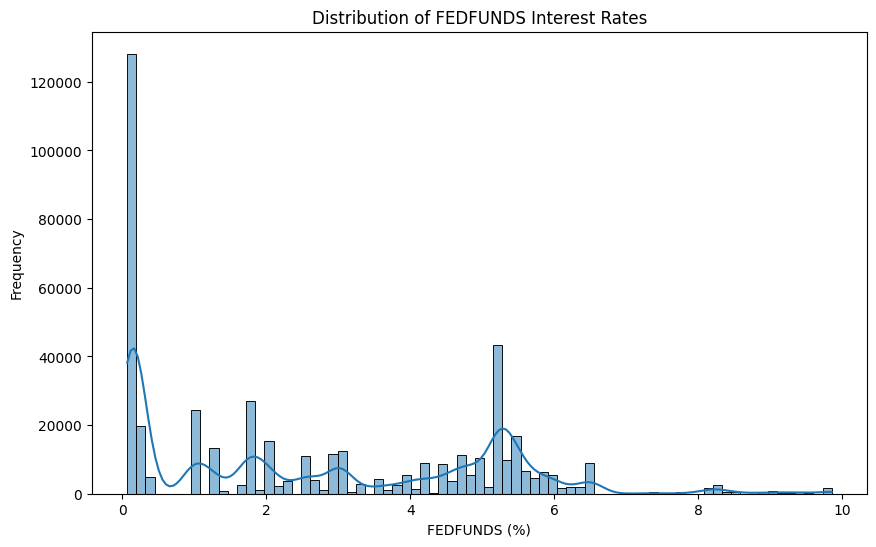

In [ ]:
# Interest rates

train_df_28 = train_df_27.copy()
interest_rates_df_1 = interest_rates_df.copy()

interest_rates_df_1['observation_date'] = pd.to_datetime(interest_rates_df_1['observation_date'])
interest_rates_df_1['FEDFUNDS'] = pd.to_numeric(interest_rates_df_1['FEDFUNDS'], errors='coerce')

train_df_28['saledate'] = pd.to_datetime(train_df_28['saledate'])

train_df_28 = pd.merge_asof(
    train_df_28.sort_values('saledate'),
    interest_rates_df_1.sort_values('observation_date')[['observation_date', 'FEDFUNDS']],
    left_on='saledate',
    right_on='observation_date',
    direction='backward'
)

train_df_28 = train_df_28.drop(columns=['observation_date']).sort_values('SalesID')


plt.figure(figsize=(10, 6))
sns.histplot(train_df_28['FEDFUNDS'].dropna(), kde=True)
plt.title('Distribution of FEDFUNDS Interest Rates')
plt.xlabel('FEDFUNDS (%)')
plt.ylabel('Frequency')
plt.show()



Number of missing values in WPU101 after merge:
0


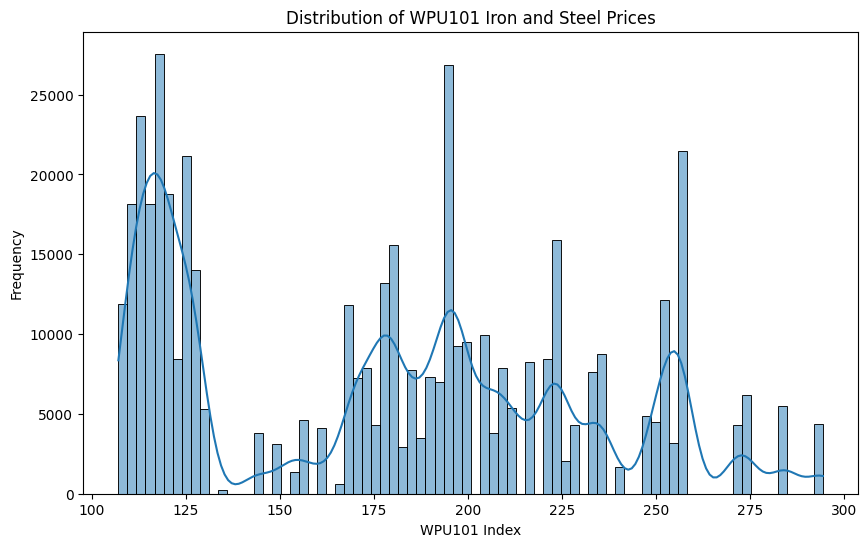

In [ ]:
#Iron and steel prices

train_df_29 = train_df_28.copy()
iron_and_steel_price_df_1 = iron_and_steel_price_df.copy()

iron_and_steel_price_df_1['observation_date'] = pd.to_datetime(iron_and_steel_price_df_1['observation_date'])
iron_and_steel_price_df_1['WPU101'] = pd.to_numeric(iron_and_steel_price_df_1['WPU101'], errors='coerce')

train_df_29['saledate'] = pd.to_datetime(train_df_29['saledate'])

train_df_29 = pd.merge_asof(
    train_df_29.sort_values('saledate'),
    iron_and_steel_price_df_1.sort_values('observation_date')[['observation_date', 'WPU101']],
    left_on='saledate',
    right_on='observation_date',
    direction='backward'
)

train_df_29 = train_df_29.drop(columns=['observation_date']).sort_values('SalesID')

print("\nNumber of missing values in WPU101 after merge:")
print(train_df_29['WPU101'].isna().sum())

plt.figure(figsize=(10, 6))
sns.histplot(train_df_29['WPU101'].dropna(), kde=True)
plt.title('Distribution of WPU101 Iron and Steel Prices')
plt.xlabel('WPU101 Index')
plt.ylabel('Frequency')
plt.show()

/tmp/ipython-input-106-3061368074.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  oil_price_df_1['DATE'] = pd.to_datetime(oil_price_df_1['DATE'])


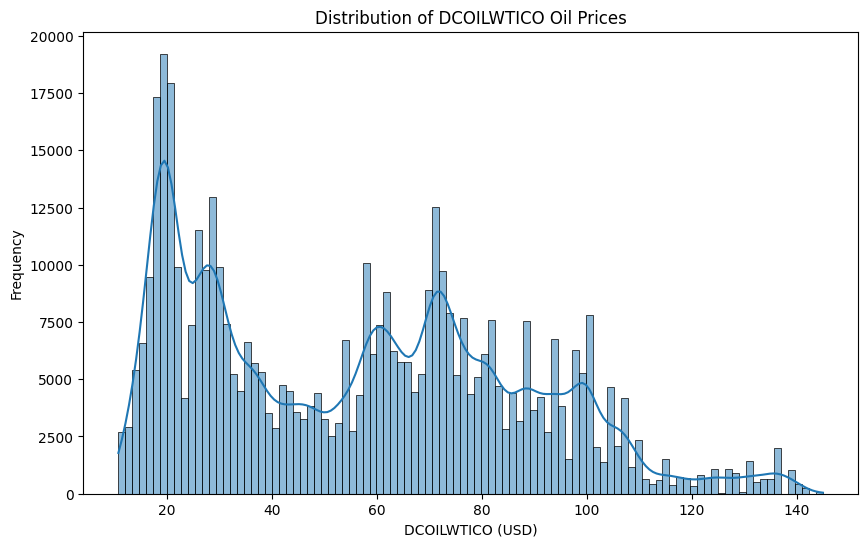

In [ ]:
# Oil prices

train_df_30 = train_df_29.copy()
oil_price_df_1 = oil_price_df.copy()

oil_price_df_1['DATE'] = pd.to_datetime(oil_price_df_1['DATE'])
oil_price_df_1['DCOILWTICO'] = pd.to_numeric(oil_price_df_1['DCOILWTICO'], errors='coerce')

train_df_30['saledate'] = pd.to_datetime(train_df_30['saledate'])

train_df_30 = pd.merge_asof(
    train_df_30.sort_values('saledate'),
    oil_price_df_1.sort_values('DATE')[['DATE', 'DCOILWTICO']],
    left_on='saledate',
    right_on='DATE',
    direction='backward'
)

train_df_30 = train_df_30.drop(columns=['DATE']).sort_values('SalesID')

plt.figure(figsize=(10, 6))
sns.histplot(train_df_30['DCOILWTICO'].dropna(), kde=True)
plt.title('Distribution of DCOILWTICO Oil Prices')
plt.xlabel('DCOILWTICO (USD)')
plt.ylabel('Frequency')
plt.show()

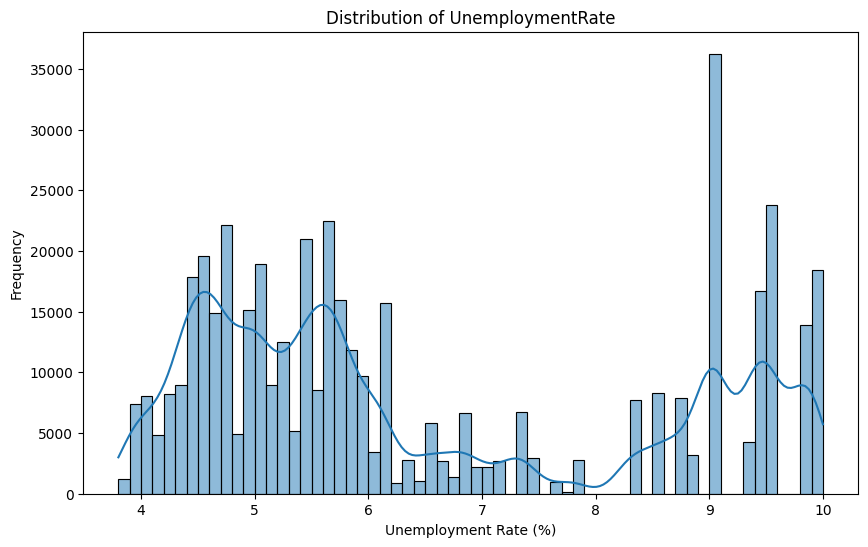

In [ ]:
# Unemployment Rate prep
unemployment_rate_df_1 = unemployment_rate_df.copy()

unemployment_rate_df_1['DATE'] = pd.to_datetime(unemployment_rate_df_1['DATE'])
unemployment_rate_df_1['VALUE'] = pd.to_numeric(unemployment_rate_df_1['VALUE'], errors='coerce')
unemployment_rate_df_1.rename(columns={'VALUE': 'UnemploymentRate'}, inplace=True)

# Unemployment Rate merge

train_df_31 = train_df_30.copy()

unemployment_rate_df_1['DATE'] = pd.to_datetime(unemployment_rate_df_1['DATE'])


train_df_31 = pd.merge_asof(
    train_df_31.sort_values('saledate'),
    unemployment_rate_df_1.sort_values('DATE')[['DATE', 'UnemploymentRate']],
    left_on='saledate',
    right_on='DATE',
    direction='backward'
)

train_df_31 = train_df_31.drop(columns=['DATE']).sort_values('SalesID')

plt.figure(figsize=(10, 6))
sns.histplot(train_df_31['UnemploymentRate'].dropna(), kde=True)
plt.title('Distribution of UnemploymentRate')
plt.xlabel('Unemployment Rate (%)')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# housing prep

housing_starts_df_1 = housing_starts_df.copy()

housing_starts_df_1['val'] = pd.to_numeric(housing_starts_df_1['val'], errors='coerce')

housing_starts_df_1['actual_housing_starts'] = housing_starts_df_1['val'] * 1000

# Sanity check the scaling
print("\nOriginal 'val' values:")
print(housing_starts_df_1['val'].head())
print("\nScaled 'actual_housing_starts' values:")
print(housing_starts_df_1['actual_housing_starts'].head())


Original 'val' values:
0     75.7
1     79.0
2    119.0
3    127.9
4    120.8
Name: val, dtype: float64

Scaled 'actual_housing_starts' values:
0     75700.0
1     79000.0
2    119000.0
3    127900.0
4    120800.0
Name: actual_housing_starts, dtype: float64


In [ ]:
print(housing_starts_geo_levels.columns)

Index(['geo_idx', 'geo_code', 'geo_desc'], dtype='object')


In [ ]:
# housing prep cont'd and join

train_df_32 = train_df_31.copy()

time_periods_map = housing_starts_time_periods.set_index('per_idx')['per_name'].to_dict()

geo_levels_map = housing_starts_geo_levels.set_index('geo_idx')['geo_desc'].to_dict()


print("\nHousing starts data after mapping:")
housing_starts_df_1['time_period_desc'] = housing_starts_df_1['per_idx'].map(time_periods_map)
housing_starts_df_1['geo_level_desc'] = housing_starts_df_1['geo_idx'].map(geo_levels_map)


print(housing_starts_df_1[['per_idx', 'time_period_desc', 'geo_idx', 'geo_level_desc', 'val', 'actual_housing_starts']].head())

print("\nValue counts for geo_level_desc:")
print(housing_starts_df_1['geo_level_desc'].value_counts(dropna=False))

print("\nValue counts for time_period_desc:")
print(housing_starts_df_1['time_period_desc'].value_counts(dropna=False))


Housing starts data after mapping:
   per_idx time_period_desc  geo_idx geo_level_desc    val  \
0        1           Jan-59        1  United States   75.7   
1        2           Feb-59        1  United States   79.0   
2        3           Mar-59        1  United States  119.0   
3        4           Apr-59        1  United States  127.9   
4        5           May-59        1  United States  120.8   

   actual_housing_starts  
0                75700.0  
1                79000.0  
2               119000.0  
3               127900.0  
4               120800.0  

Value counts for geo_level_desc:
geo_level_desc
United States    26005
Northeast        15429
Midwest          15429
South            15429
West             15429
Name: count, dtype: int64

Value counts for time_period_desc:
time_period_desc
Jan-00    176
Feb-00    176
May-00    176
Jun-00    176
Jul-00    176
         ... 
May-59     19
Apr-59     19
Mar-59     19
Feb-59     19
Jan-59     19
Name: count, Length: 796, dtype:

**CHECKPOINT**

In [ ]:
train_df_32.to_csv('train_df_32.csv', index=False)

In [ ]:
print(f"Number of columns in train_df_32: {train_df_32.shape[1]}")

Number of columns in train_df_32: 256


#### Additional Feature Engineering

In [ ]:
# Temporal features
train_df_33 = train_df_32.copy()

train_df_33['sale_year'] = train_df_33['saledate'].dt.year
train_df_33['sale_month'] = train_df_33['saledate'].dt.month
train_df_33['sale_day'] = train_df_33['saledate'].dt.day
train_df_33['sale_dayofweek'] = train_df_33['saledate'].dt.dayofweek
train_df_33['sale_dayofyear'] = train_df_33['saledate'].dt.dayofyear
train_df_33['sale_weekofyear'] = train_df_33['saledate'].dt.isocalendar().week.astype(int)
train_df_33['sale_quarter'] = train_df_33['saledate'].dt.quarter
train_df_33['sale_elapsed'] = (train_df_33['saledate'] - train_df_33['saledate'].min()).dt.days

print("\nTemporal features created:")
print(train_df_33[['saledate', 'sale_year', 'sale_month', 'sale_day', 'sale_dayofweek', 'sale_dayofyear', 'sale_weekofyear', 'sale_quarter', 'sale_elapsed']].head())

print("\nInfo on new temporal features:")
print(train_df_33[['sale_year', 'sale_month', 'sale_day', 'sale_dayofweek', 'sale_dayofyear', 'sale_weekofyear', 'sale_quarter', 'sale_elapsed']].info())


Temporal features created:
         saledate  sale_year  sale_month  sale_day  sale_dayofweek  \
234056 2006-11-16       2006          11        16               3   
173360 2004-03-26       2004           3        26               4   
171050 2004-02-26       2004           2        26               3   
440973 2011-05-19       2011           5        19               3   
360895 2009-07-23       2009           7        23               3   

        sale_dayofyear  sale_weekofyear  sale_quarter  sale_elapsed  
234056             320               46             4          6512  
173360              86               13             1          5547  
171050              57                9             1          5518  
440973             139               20             2          8157  
360895             204               30             3          7492  

Info on new temporal features:
<class 'pandas.core.frame.DataFrame'>
Index: 469663 entries, 234056 to 460760
Data columns (total 8

In [ ]:
# More temporal features
train_df_34 = train_df_33.copy()

train_df_34['is_q4'] = train_df_34['sale_quarter'] == 4
train_df_34['is_year_end'] = train_df_34['sale_month'] == 12
train_df_34['is_fiscal_season'] = ((train_df_34['sale_month'] >= 10) | (train_df_34['sale_month'] <= 3))

In [ ]:
# Machine Usage Features

train_df_35 = train_df_34.copy()

train_df_35['hours_per_year'] = train_df_35.apply(
    lambda row: row['Estimated_Hours'] / row['Equipment_Age'] if pd.notna(row['Equipment_Age']) and row['Equipment_Age'] > 0 else 0,
    axis=1
)

bins = [0, 500, 2000, 5000, np.inf]
labels = ['low', 'medium', 'high', 'very_high']
train_df_35['usage_bin'] = pd.cut(train_df_35['hours_per_year'], bins=bins, labels=labels, right=True, include_lowest=True)
train_df_35['has_usage_data'] = (train_df_35['Hours_Available'] == 1).astype(int)

print("\nMachine Usage features created:")
print(train_df_35[['Estimated_Hours', 'Equipment_Age', 'hours_per_year', 'usage_bin', 'has_usage_data']].head())

print("\nInfo on new machine usage features:")
print(train_df_35[['hours_per_year', 'usage_bin', 'has_usage_data']].info())


Machine Usage features created:
        Estimated_Hours Equipment_Age  hours_per_year usage_bin  \
234056             68.0             2            34.0       low   
173360           4640.0             8           580.0    medium   
171050           2838.0             3           946.0    medium   
440973           3486.0            10           348.6       low   
360895            722.0             2           361.0       low   

        has_usage_data  
234056               1  
173360               1  
171050               1  
440973               1  
360895               1  

Info on new machine usage features:
<class 'pandas.core.frame.DataFrame'>
Index: 469663 entries, 234056 to 460760
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype   
---  ------          --------------   -----   
 0   hours_per_year  469663 non-null  float64 
 1   usage_bin       469663 non-null  category
 2   has_usage_data  469663 non-null  int64   
dtypes: category(1), float64(1),

In [ ]:
# Economic conditions at the time of sale

train_df_36 = train_df_35.copy()


required_cols = ['FEDFUNDS', 'UnemploymentRate', 'WPU101', 'PCOPPUSDM', 'GDPC1', 'TTLCONS_scaled_billions', 'U33CTI']
for col in required_cols:
  if col not in train_df_36.columns:
    print(f"Warning: Required column '{col}' not found for economic feature creation.")


economic_cols_to_impute = ['FEDFUNDS', 'UnemploymentRate', 'WPU101', 'PCOPPUSDM', 'GDPC1', 'TTLCONS_scaled_billions', 'U33CTI']
for col in economic_cols_to_impute:
    if col in train_df_36.columns:
        median_val = train_df_36[col].median()
        train_df_36[col] = train_df_36[col].fillna(median_val)

train_df_36['real_interest_rate'] = train_df_36['FEDFUNDS'] - train_df_36['UnemploymentRate']
epsilon = 1e-9
train_df_36['commodity_pressure'] = train_df_36['WPU101'] / (train_df_36['PCOPPUSDM'] + epsilon)
train_df_36['growth_index'] = train_df_36['GDPC1'] / (train_df_36['TTLCONS_scaled_billions'] + epsilon)
train_df_36['demand_pressure_index'] = train_df_36['U33CTI'] / (train_df_36['UnemploymentRate'] + epsilon)

print("\nEconomic conditions features created:")
print(train_df_36[['saledate', 'real_interest_rate', 'commodity_pressure', 'growth_index', 'demand_pressure_index']].head())

print("\nInfo on new economic features:")
print(train_df_36[['real_interest_rate', 'commodity_pressure', 'growth_index', 'demand_pressure_index']].info())

print("\nDescribe new economic features:")
print(train_df_36[['real_interest_rate', 'commodity_pressure', 'growth_index', 'demand_pressure_index']].describe())


Economic conditions features created:
         saledate  real_interest_rate  commodity_pressure  growth_index  \
234056 2006-11-16                0.75            0.026887     14.764324   
173360 2004-03-26               -4.80            0.050095     15.864888   
171050 2004-02-26               -4.59            0.052186     16.259830   
440973 2011-05-19               -8.91            0.028729     21.973676   
360895 2009-07-23               -9.34            0.034083     17.912662   

        demand_pressure_index  
234056            1133.777778  
173360             521.379310  
171050             539.821428  
440973             520.666667  
360895             456.736842  

Info on new economic features:
<class 'pandas.core.frame.DataFrame'>
Index: 469663 entries, 234056 to 460760
Data columns (total 4 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   real_interest_rate     469663 non-null  float64
 1   commodity_pr

In [ ]:
# Interaction term (TWEXM*FEDFUNDS)

train_df_36['twexm_fedfunds_interaction'] = train_df_36['TWEXM'] * train_df_36['FEDFUNDS']

#### Advanced Feature Engineering

In [ ]:
# Lag Feature 1 - price model to capture recent pricing trends

train_df_37 = train_df_36.copy()

train_df_37['saledate'] = pd.to_datetime(train_df_37['saledate'])
train_df_37 = train_df_37.sort_values(['ModelID', 'saledate'])
train_df_37['lag1_price_model'] = train_df_37.groupby('ModelID')['SalePrice'].shift(1)

# imputing the first and last with median
train_df_37['lag1_price_model'] = train_df_37.groupby('ModelID')['lag1_price_model'].transform(lambda x: x.fillna(x.median()))

# Imputing remaining NaNs (from models with only one sale) with the overall median price. (if they exist)
overall_median_saleprice = train_df_37['SalePrice'].median()
train_df_37['lag1_price_model'] = train_df_37['lag1_price_model'].fillna(overall_median_saleprice)

In [ ]:
# Find state...apparently I removed it -_-
dataframes = [var for var in dir() if isinstance(eval(var), pd.DataFrame)]

print("Dataframes with 'state' column:")
for df_name in dataframes:
  df = eval(df_name)
  if 'state' in df.columns:
    print(f"- {df_name}")

Dataframes with 'state' column:
- MHCM_Viz
- MHCM_Viz_no_zeros
- MHCM_Viz_no_zeros_outliers_removed
- MHCM_Viz_outliers_removed
- annual_usage_rates
- outliers
- test_df
- train_df
- train_df_1_before_strip
- train_df_2_whitespace_removed
- train_df_3_datetime_converted
- train_df_4_hours_available_feature
- train_df_5_hours_value_feature
- train_df_6_equipment_age
- train_df_7_estimated_hours
- train_df_8
- train_df_8_outliers_removed
- train_df_9
- valid_df


In [ ]:
train_df_38 = train_df_37.copy()
state_info_df = train_df_9[['SalesID', 'state']].copy()
train_df_38 = pd.merge(train_df_38, state_info_df, on='SalesID', how='left')

In [ ]:
# Lag Feature 2 - Volume in a state to capture local activity.

train_df_38['saledate'] = pd.to_datetime(train_df_38['saledate'])
train_df_38 = train_df_38.sort_values(['state', 'saledate'])
daily_state_volume = train_df_38.groupby(['state', 'saledate']).size().reset_index(name='daily_sales_volume')

train_df_38 = pd.merge(
    train_df_38,
    daily_state_volume,
    on=['state', 'saledate'],
    how='left'
)

train_df_38 = train_df_38.sort_values(['state', 'saledate'])
train_df_38['lag1_volume_state'] = train_df_38.groupby('state')['daily_sales_volume'].shift(1)
train_df_38['lag1_volume_state'] = train_df_38['lag1_volume_state'].fillna(0)
train_df_38 = train_df_38.drop(columns=['daily_sales_volume'])

# Verify the lag logic for a specific state
print("\nVerification of lag feature for state 'Florida' (example):")
print(train_df_38[train_df_38['state'] == 'Florida'][['saledate', 'state', 'lag1_volume_state', 'SalesID']].head(10))


Verification of lag feature for state 'Florida' (example):
        saledate    state  lag1_volume_state  SalesID
84407 1989-01-31  Florida                0.0  1531383
84408 1989-01-31  Florida               89.0  1371616
84409 1989-01-31  Florida               89.0  1371695
84410 1989-01-31  Florida               89.0  1493165
84411 1989-01-31  Florida               89.0  1493279
84412 1989-01-31  Florida               89.0  1305336
84413 1989-01-31  Florida               89.0  1305337
84414 1989-01-31  Florida               89.0  1449549
84415 1989-01-31  Florida               89.0  1449555
84416 1989-01-31  Florida               89.0  1449641


In [ ]:
# Lag feature 3 - previous machine hours from teh same machine
train_df_39 = train_df_38.copy()

train_df_39 = train_df_39.sort_values(['MachineID', 'saledate'])
train_df_39['lag1_hours_machine'] = train_df_39.groupby('MachineID')['Estimated_Hours'].shift(1)
train_df_39['lag1_hours_machine'] = train_df_39['lag1_hours_machine'].fillna(0)

print("\nVerification of lag feature for a few MachineIDs:")
print(train_df_39[['MachineID', 'saledate', 'Estimated_Hours', 'lag1_hours_machine']].head(20))


Verification of lag feature for a few MachineIDs:
        MachineID   saledate  Estimated_Hours  lag1_hours_machine
335040          0 2005-11-17         0.000000                 0.0
68642           0 2007-09-25         0.000000                 0.0
428141          2 2010-12-01      9614.000000                 0.0
215857         13 2005-12-13         0.000000                 0.0
1219           17 2000-03-02         0.000000                 0.0
369404         52 2003-06-19         0.000000                 0.0
4141           63 2004-12-02         0.000000                 0.0
181478         66 2010-03-25         0.000000                 0.0
2764          102 2002-09-05         0.000000                 0.0
358435        102 2003-04-16         0.000000                 0.0
3020          113 2002-12-13      2099.428571                 0.0
263709        116 2007-01-24         0.000000                 0.0
157079        117 2010-02-08      3400.000000                 0.0
157080        117 2010-02

**CHECKPOINT**

In [ ]:
train_df_39.to_csv('train_df_39.csv', index=False)

In [ ]:
train_df_39 = pd.read_csv('/content/train_df_39.csv', low_memory=False)
train_df_39.shape

(469663, 278)

In [ ]:
# Save
secondary_dfs_to_save = [
    auction_volume_df_1,
    BCI_df_1,
    construction_spending_df_1,
    copper_price_df_1,
    dealer_inventory_df_1,
    exchange_rate_df_1,
    gdp_df_1,
    housing_starts_df_1,
    interest_rates_df_1,
    iron_and_steel_price_df_1,
    oil_price_df_1,
    unemployment_rate_df_1,
]

df_names = {id(df): name for name, df in locals().items() if isinstance(df, pd.DataFrame) and name.endswith('_1')}

for df in secondary_dfs_to_save:
    df_id = id(df)
    if df_id in df_names:
        filename = f"{df_names[df_id]}.csv"
        df.to_csv(filename, index=False)
        print(f"Saved {filename}")
    else:
        print(f"Could not find variable name for a dataframe ending in _1. Skipping save.")



Saved auction_volume_df_1.csv
Saved BCI_df_1.csv
Saved construction_spending_df_1.csv
Saved copper_price_df_1.csv
Saved dealer_inventory_df_1.csv
Saved exchange_rate_df_1.csv
Saved gdp_df_1.csv
Saved housing_starts_df_1.csv
Saved interest_rates_df_1.csv
Saved iron_and_steel_price_df_1.csv
Saved oil_price_df_1.csv
Saved unemployment_rate_df_1.csv


In [ ]:
# reloading cleaned dataframes

auction_volume_df_1 = pd.read_csv('/content/auction_volume_df_1.csv', low_memory=False)
BCI_df_1 = pd.read_csv('/content/BCI_df_1.csv', low_memory=False)
construction_spending_df_1 = pd.read_csv('/content/construction_spending_df_1.csv', low_memory=False)
copper_price_df_1 = pd.read_csv('/content/copper_price_df_1.csv', low_memory=False)
dealer_inventory_df_1 = pd.read_csv('/content/dealer_inventory_df_1.csv', low_memory=False)
exchange_rate_df_1 = pd.read_csv('/content/exchange_rate_df_1.csv', low_memory=False)
gdp_df_1 = pd.read_csv('/content/gdp_df_1.csv', low_memory=False)
housing_starts_df_1 = pd.read_csv('/content/housing_starts_df_1.csv', low_memory=False)
interest_rates_df_1 = pd.read_csv('/content/interest_rates_df_1.csv', low_memory=False)
iron_and_steel_price_df_1 = pd.read_csv('/content/iron_and_steel_price_df_1.csv', low_memory=False)
oil_price_df_1 = pd.read_csv('/content/oil_price_df_1.csv', low_memory=False)
unemployment_rate_df_1 = pd.read_csv('/content/unemployment_rate_df_1.csv', low_memory=False)

When I return, create the following:

Rolling/Momentum Indicators

| Feature Name                    | Definition                               | Grouped By | Window Size | Use For...       |
| ------------------------------- | ---------------------------------------- | ---------- | ----------- | ---------------- |
| `rolling_mean_price_model_3`    | 3-sale rolling mean sale price for model | `ModelID`  | 3 sales     | Price momentum   |
| `rolling_std_price_model_3`     | 3-sale rolling std dev of price          | `ModelID`  | 3 sales     | Price volatility |
| `rolling_median_hours_model_5`  | Median of usage hours over 5 sales       | `ModelID`  | 5 sales     | Condition trend  |
| ~~`rolling_sale_volume_state_30d`~~ | Total sales in state over last 30 days   | `state`    | 30 days     | Demand intensity |

Auctioneer Reputation Index

| Feature Name                  | Definition                                        |
| ----------------------------- | ------------------------------------------------- |
| `auctioneer_avg_price`        | Avg sale price of past listings                   |
| `auctioneer_sale_count`       | Total # of sales to date                          |
| `auctioneer_price_std`        | Std deviation of prices (volatility)              |
| `auctioneer_high_price_ratio` | % of sales above median price for that model      |
| `auctioneer_popularity_score` | # of unique ProductGroups sold by this auctioneer |

Other Ideas:
1. track how aging affects the resale of a model over time
2. ~~Economic pressure over past 90 days (not sure how useful this would be...)~~
3. ~~seasonal price index to compare current price to the average for the same quarter or month. This is supposed to help in the case that an entity feels that they are getting a 'deal' because the price is below average for the time period. I feel like I'm just shooting darts here, but you never know. Things like this could reveal a lot. ~~


In [ ]:
# Rolling feature 1 - price momentum over the past 3 sales
train_df_40 = train_df_39.copy()

train_df_40 = train_df_40.sort_values(['ModelID', 'saledate'])
train_df_40['rolling_mean_price_model_3'] = train_df_40.groupby('ModelID')['SalePrice'].transform(
    lambda x: x.rolling(window=3, min_periods=1).mean()
)

print("\nVerification of rolling_mean_price_model_3:")
print(train_df_40[['ModelID', 'saledate', 'SalePrice', 'rolling_mean_price_model_3']].head(10))
print(train_df_40[['ModelID', 'saledate', 'SalePrice', 'rolling_mean_price_model_3']].tail(10))

train_df_40.shape


Verification of rolling_mean_price_model_3:
       ModelID    saledate  SalePrice  rolling_mean_price_model_3
70473       28  2009-08-13      13500                13500.000000
70474       28  2009-08-13      13500                13500.000000
71887       28  2009-08-13      13000                13333.333333
71888       28  2009-08-13      13000                13166.666667
70475       28  2009-08-25      13500                13166.666667
70476       28  2009-08-25      13500                13333.333333
70477       28  2009-08-25      13500                13500.000000
68152       28  2009-10-01      12000                13000.000000
66790       28  2009-10-14      13000                12833.333333
53520       28  2009-10-22      12000                12333.333333
        ModelID    saledate  SalePrice  rolling_mean_price_model_3
434239    37197  2008-09-18      27500                33000.000000
434240    37197  2008-09-18      27500                30333.333333
409367    37197  2008-10-01 

(469663, 279)

In [ ]:
# Rolling feature 2 - price volatility over the last 3 price sales

train_df_41 = train_df_40.copy()

train_df_41 = train_df_41.sort_values(['ModelID', 'saledate'])
train_df_41['rolling_std_price_model_3'] = train_df_41.groupby('ModelID')['SalePrice'].transform(
    lambda x: x.rolling(window=3, min_periods=1).std()
)
train_df_41['rolling_std_price_model_3'] = train_df_41['rolling_std_price_model_3'].fillna(0)
train_df_41.shape

(469663, 280)

In [ ]:
# Rolling feature 3 - captures wear and tear patterns for each model over the past 5 sales
train_df_42 = train_df_41.copy()

train_df_42 = train_df_42.sort_values(['ModelID', 'saledate'])
train_df_42['rolling_median_hours_model_5'] = train_df_42.groupby('ModelID')['Estimated_Hours'].transform(
    lambda x: x.rolling(window=5, min_periods=1).median()
)
train_df_42.shape

(469663, 281)

In [ ]:
# Auctioneer's average price

train_df_43 = train_df_42.copy()

auctioneer_avg_price = train_df_43.groupby('auctioneerID')['SalePrice'].mean().reset_index()
auctioneer_avg_price.rename(columns={'SalePrice': 'auctioneer_avg_price'}, inplace=True)

train_df_43 = pd.merge(train_df_43, auctioneer_avg_price, on='auctioneerID', how='left')
train_df_43.shape

(469663, 282)

In [ ]:
# Auctioneer's total sale count

train_df_44 = train_df_43.copy()

auctioneer_sale_count = train_df_44.groupby('auctioneerID').size().reset_index(name='auctioneer_sale_count')

train_df_44 = pd.merge(train_df_44, auctioneer_sale_count, on='auctioneerID', how='left')
train_df_44.shape

(469663, 283)

In [ ]:
# Auctioneer's sales volatility
train_df_45 = train_df_44.copy()

auctioneer_price_std = train_df_45.groupby('auctioneerID')['SalePrice'].std().reset_index()
auctioneer_price_std.rename(columns={'SalePrice': 'auctioneer_price_std'}, inplace=True)
train_df_45 = pd.merge(train_df_45, auctioneer_price_std, on='auctioneerID', how='left')
train_df_45['auctioneer_price_std'] = train_df_45['auctioneer_price_std'].fillna(0)
train_df_45.shape

(469663, 284)

In [ ]:
# Auctioneer's above average (median) sales for each model (%)

train_df_46 = train_df_45.copy()

median_price_per_model = train_df_46.groupby('ModelID')['SalePrice'].median().reset_index()
median_price_per_model.rename(columns={'SalePrice': 'Model_Median_Price'}, inplace=True)
train_df_46 = pd.merge(train_df_46, median_price_per_model, on='ModelID', how='left')
train_df_46['above_model_median'] = (train_df_46['SalePrice'] > train_df_46['Model_Median_Price']).astype(int)
auctioneer_high_price_ratio = (
    train_df_46
    .groupby('auctioneerID')['above_model_median']
    .mean()
    .reset_index(name='auctioneer_high_price_ratio')
)
train_df_46 = pd.merge(train_df_46, auctioneer_high_price_ratio, on='auctioneerID', how='left')
train_df_46.drop(columns=['Model_Median_Price', 'above_model_median'], inplace=True)
train_df_46.shape

(469663, 285)

In [ ]:
train_df_46.to_csv('train_df_46.csv', index=False)

In [ ]:
# Number of unique ProductGroups sold by each auctioneer

train_df_47 = train_df_46.copy()

train_df = pd.read_csv('/content/Train.csv', low_memory=False)
productgroup_from_original = train_df[['SalesID', 'ProductGroup']].copy()

if 'SalesID' in train_df_47.columns:
    train_df_47 = pd.merge(
        train_df_47,
        productgroup_from_original,
        on='SalesID',
        how='left'
    )
    print("success.")
else:
    print("Error.")

if 'ProductGroup' in train_df_47.columns:
    auctioneer_popularity_score = train_df_47.groupby('auctioneerID')['ProductGroup'].nunique().reset_index(name='auctioneer_popularity_score')
    train_df_47 = pd.merge(train_df_47, auctioneer_popularity_score, on='auctioneerID', how='left')

    print(train_df_47[['auctioneerID', 'ProductGroup', 'auctioneer_popularity_score']].drop_duplicates(subset=['auctioneerID']).head())
else:
    print("fail.")
train_df_47.shape

success.
    auctioneerID ProductGroup  auctioneer_popularity_score
0            2.0          SSL                            6
7            3.0          SSL                            6
8            1.0          SSL                            6
9           99.0          SSL                            6
26          14.0          SSL                            6


(469663, 287)

In [ ]:
# A feature that tracks how aging affects the resale of a model over time

# Age vs Resale Price

train_df_48 = train_df_47.copy()

age_price_df = train_df_48[(train_df_48['Equipment_Age'].notna()) & (train_df_48['Equipment_Age'] >= 0)].copy()
avg_price_by_age_model = age_price_df.groupby(['ModelID', 'Equipment_Age'])['SalePrice'].mean().reset_index()
avg_price_by_age_model.rename(columns={'SalePrice': 'Avg_SalePrice_by_Age_Model'}, inplace=True)

train_df_48 = pd.merge(
    train_df_48,
    avg_price_by_age_model,
    on=['ModelID', 'Equipment_Age'],
    how='left'
)

epsilon = 1e-9 # just in case something goes wrong..and the first sale. BUT! since log(0) = 1, then i'm just going to fill na's with 1. its fine to indicate that it matches the avg.
train_df_48['price_vs_avg_by_age'] = train_df_48['SalePrice'] / (train_df_48['Avg_SalePrice_by_Age_Model'] + epsilon)
train_df_48['price_vs_avg_by_age'] = train_df_48['price_vs_avg_by_age'].fillna(1.0)
train_df_48.shape

(469663, 289)

In [ ]:
train_df_48.to_csv('train_df_48.csv', index=False)

In [ ]:
train_df_48.shape

(469663, 289)

THE DF ABOVE HAS ALL FEATURES



#### Selecting Features

~~rerun dfs and check shape. find out when i no longer had 400,000+ rows. it's alarming that i only have 18,000.~~

False alarm - I was looking at the sample set...lol

After I'm done creating features:

1. remove features that should not be in any models
2. remove features with no variability
3. remove features that are HIGHLY CORRELATED (not applicable with the saleprice)
4. remove features that are derived from saleprice
5. recognize feature importance (random forest)
6. do a final elimination based on RFE (recursive feature elimination) and/or dimensionality reduction
7. Find the features that contribute the most for predictions using SHAP or permutation importance.
8. Group and label features (machine specs, macroeconomic, dealer-based, engineered)
8. Revisit encoding or create more feature interactions based on findings
8. Create the final train_cleaned_engineered.csv dataframe
9. Create cleaned and engineered test and valid dataframes
10. Identify the best models to move forward with.
10. Identify my baseline models, advanced models and multi-level forecasting
10. Time-based train splits (not sure if this is additionally needed since all the data is already split this way)
11. Start training.



In [ ]:
# num / cat
numerical_cols_48 = train_df_48.select_dtypes(include=np.number).columns.tolist()
categorical_cols_48 = train_df_48.select_dtypes(include='object').columns.tolist()

print("Numerical Columns in train_df_48:")
print(pd.DataFrame(numerical_cols_48, columns=['Column Name']).to_markdown(index=False))
print(f"\nTotal count of numerical columns: {len(numerical_cols_48)}")

print("\nCategorical Columns in train_df_48:")
print(pd.DataFrame(categorical_cols_48, columns=['Column Name']).to_markdown(index=False))
print(f"\nTotal count of categorical columns: {len(categorical_cols_48)}")

Numerical Columns in train_df_48:
| Column Name                      |
|:---------------------------------|
| SalesID                          |
| SalePrice                        |
| MachineID                        |
| ModelID                          |
| datasource                       |
| auctioneerID                     |
| YearMade                         |
| MachineHoursCurrentMeter         |
| Hours_Available                  |
| Hours_Value                      |
| Equipment_Age                    |
| Estimated_Hours                  |
| Estimated_Hours_log              |
| Estimated_Hours_scaled           |
| fiBaseModel_freq                 |
| fiSecondaryDesc_freq             |
| fiModelSeries_freq               |
| fiModelDescriptor_freq           |
| MachineHoursCurrentMeter_capped  |
| MachineHoursCurrentMeter_log     |
| MachineHoursCurrentMeter_imputed |
| Hours_Value_capped               |
| Hours_Value_log                  |
| Hours_Value_imputed              |
| Ho

In [ ]:
# removing low variance / no variance columns (numerical)

low_variance_cols = []
for col in numerical_cols_48:
  if col in train_df_48.columns:
    if train_df_48[col].std() == 0 or train_df_48[col].nunique() <= 1:
      low_variance_cols.append(col)

print("\nLow variance group:")
print(low_variance_cols)


low_variance_group = low_variance_cols
train_df_49 = train_df_48.drop(columns=low_variance_group)

print(f"\nShape of original train_df_48: {train_df_48.shape}")
print(f"Shape of train_df_49: {train_df_49.shape}")


Low variance group:
['auctioneer_popularity_score']

Shape of original train_df_48: (469663, 289)
Shape of train_df_49: (469663, 288)


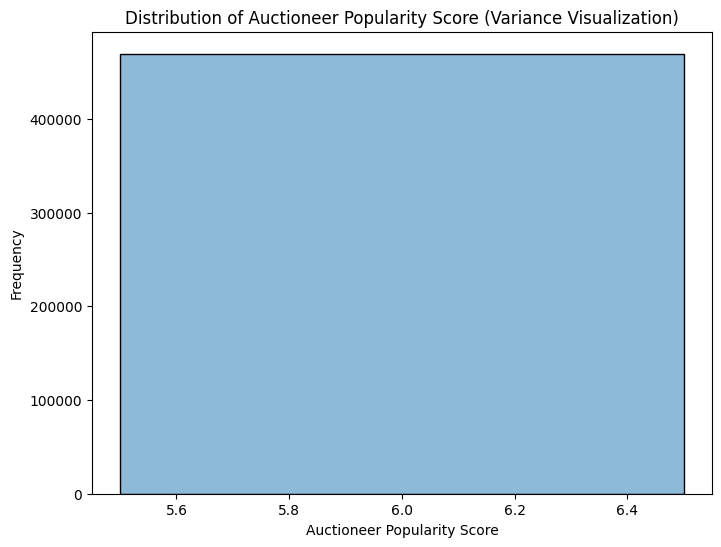


Variance of 'auctioneer_popularity_score':
0.0

Description of 'auctioneer_popularity_score':
count    469663.0
mean          6.0
std           0.0
min           6.0
25%           6.0
50%           6.0
75%           6.0
max           6.0
Name: auctioneer_popularity_score, dtype: float64


In [ ]:
# Visualize the variance of 'auctioneer_popularity_score'
plt.figure(figsize=(8, 6))
sns.histplot(train_df_48['auctioneer_popularity_score'], kde=True)
plt.title('Distribution of Auctioneer Popularity Score (Variance Visualization)')
plt.xlabel('Auctioneer Popularity Score')
plt.ylabel('Frequency')
plt.show()

print("\nVariance of 'auctioneer_popularity_score':")
print(train_df_48['auctioneer_popularity_score'].var())

print("\nDescription of 'auctioneer_popularity_score':")
print(train_df_48['auctioneer_popularity_score'].describe())


In [ ]:
train_df_49.to_csv('train_df_49_num_var_removed.csv', index=False)

In [ ]:
import numpy as np

categorical_cols_49 = train_df_49.select_dtypes(include='object').columns.tolist()

unique_cat_summary = []

for col in categorical_cols_49:
    if col in train_df_49.columns:
        unique_categories = train_df_49[col].unique().tolist()
        has_missing = any(pd.isna(x) for x in unique_categories)
        unique_categories_display = [str(x) for x in unique_categories]
        unique_categories_display = [item if pd.notna(item) else 'NaN' for item in unique_categories_display] # no need to include nas
        most_frequent_percent = train_df_49[col].value_counts(normalize=True, dropna=False).max() * 100
        unique_cat_summary.append({
            'Column Name': col,
            'Unique Categories (Sample)': ', '.join(unique_categories_display[:20]), # Display
            'Number of Unique Categories': train_df_49[col].nunique(dropna=False),
            'Percentage of Most Frequent Category': f"{most_frequent_percent:.2f}%"
        })

unique_cat_summary_df = pd.DataFrame(unique_cat_summary)
unique_cat_summary_df = unique_cat_summary_df.sort_values(by='Number of Unique Categories', ascending=False)
display(Markdown(unique_cat_summary_df.to_markdown(index=False)))

| Column Name             | Unique Categories (Sample)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                |   Number of Unique Categories | Percentage of Most Frequent Category   |
|:------------------------|:------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|------------------------------:|:---------------------------------------|
| fiModelDesc             | 226B2, 232B2, 242B2, 252B2, 416II, 426II, 428II, 436II, 438II, 938GII, 950FII, 962GII, 966FII, 980FII, D3CII, D3CIII, 80ZII, 90ZIII, 95ZII, KSS110ZII                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     |                          4999 | 1.35%                                  |
| saledate                | 2009-08-13, 2009-08-25, 2009-10-01, 2009-10-14, 2009-10-22, 2010-02-15, 2010-04-13, 2010-05-25, 2010-10-07, 2010-12-09, 2011-01-29, 2011-03-31, 2011-04-05, 2011-06-17, 2011-06-27, 2011-06-28, 2011-09-30, 2011-10-03, 2011-11-11, 2011-12-07                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            |                          3919 | 0.55%                                  |
| fiBaseModel             | 226, 232, 242, 252, 416, 426, 428, 436, 438, 938, 950, 962, 966, 980, D3, 80, 90, 95, KSS110, KSS85                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       |                          1950 | 4.80%                                  |
| Maturity Date           | 2010-06-17, 2039-08-15, 2011-08-31, 2009-09-24, 2010-08-26, nan, 2009-11-12, 2010-05-13, 2012-05-31, 2010-06-24, 2040-11-15, 2012-04-05, 2011-05-05, 2011-09-29, 2011-12-29, 2013-06-30, 2011-07-28, 2012-06-28, 2016-06-30, 2012-01-05                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   |                          1157 | 48.61%                                 |
| fiSecondaryDesc         | B, nan, G, F, C, Z, A, AX, P, PL, E, PX, EX, ESS, L, US, UU, R, MR, EL                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    |                           171 | 33.74%                                 |
| fiModelDescriptor       | nan, 6, 5, 3, E, LC, 7, 2, 1, LT, LGP, LL, XT, K, SA, CR, SR, SB, SSR, U                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  |                           136 | 81.57%                                 |
| fiModelSeries           | 2, II, III, -1, -2, -3, -5, -6, -7, -7E, -16, -18, -20, -17, -21, -8, -12, -15, -6E, LC                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   |                           122 | 85.67%                                 |
| fiProductClassDesc      | Skid Steer Loader - 1351.0 to 1601.0 Lb Operating Capacity, Skid Steer Loader - 1601.0 to 1751.0 Lb Operating Capacity, Skid Steer Loader - 1751.0 to 2201.0 Lb Operating Capacity, Skid Steer Loader - 2201.0 to 2701.0 Lb Operating Capacity, Backhoe Loader - 14.0 to 15.0 Ft Standard Digging Depth, Backhoe Loader - 15.0 to 16.0 Ft Standard Digging Depth, Backhoe Loader - 16.0 + Ft Standard Digging Depth, Wheel Loader - 150.0 to 175.0 Horsepower, Wheel Loader - 200.0 to 225.0 Horsepower, Wheel Loader - 275.0 to 350.0 Horsepower, Track Type Tractor, Dozer - 20.0 to 75.0 Horsepower, Wheel Loader - 175.0 to 200.0 Horsepower, Wheel Loader - 250.0 to 275.0 Horsepower, Wheel Loader - 350.0 to 500.0 Horsepower, Wheel Loader - 90.0 to 100.0 Horsepower, Wheel Loader - 100.0 to 110.0 Horsepower, Track Type Tractor, Dozer - 260.0 + Horsepower, Track Type Tractor, Dozer - 75.0 to 85.0 Horsepower, Track Type Tractor, Dozer - 85.0 to 105.0 Horsepower, Track Type Tractor, Dozer - 105.0 to 130.0 Horsepower |                            74 | 13.91%                                 |
| state                   | Florida, Texas, Idaho, California, New Jersey, Indiana, Arizona, Wyoming, Kansas, Minnesota, North Carolina, Nevada, Tennessee, Michigan, New York, Colorado, Georgia, Missouri, Nebraska, Oregon                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         |                            53 | 17.93%                                 |
| Stick_Length            | nan, None or Unspecified, 11' 0", 9' 6", 9' 7", 9' 10", 8' 6", 8' 2", 9' 8", 10' 6", 8' 4", 9' 5", 8' 10", 12' 10", 12' 4", 10' 2", 15' 9", 19' 8", 11' 10", 10' 10"                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      |                            30 | 75.30%                                 |
| Undercarriage_Pad_Width | nan, 27 inch, None or Unspecified, 20 inch, 28 inch, 24 inch, 22 inch, 34 inch, 30 inch, 16 inch, 32 inch, 18 inch, 15 inch, 14 inch, 36 inch, 26 inch, 25 inch, 31 inch, 33 inch, 31.5 inch                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              |                            20 | 75.14%                                 |
| ProductGroupDesc        | Skid Steer Loaders, Backhoe Loaders, Wheel Loader, Track Type Tractors, Motor Graders, Track Excavators                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   |                             6 | 25.17%                                 |
| ProductGroup            | SSL, BL, WL, TTT, MG, TEX                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 |                             6 | 25.17%                                 |
| usage_bin               | medium, low, high, very_high                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              |                             4 | 91.53%                                 |
| Engine_Horsepower       | nan, No, Variable                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         |                             3 | 93.70%                                 |
| Track_Type              | nan, Rubber, Steel                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        |                             3 | 75.32%                                 |

In [ ]:
# Removing columns

train_df_50 = train_df_49.drop(columns=[
    'ModelID',
    'datasource',
    'YearMade',
    'MachineHoursCurrentMeter_capped',
    'MachineHoursCurrentMeter_log',
    'Hours_Value_capped',
    'Hours_Value_log',
    'Hours_Value_imputed',
    'Equipment_Age_sqrt',
    'Equipment_Age_log'
])

print(f"Shape of train_df_50: {train_df_50.shape}")

Shape of train_df_50: (469663, 278)


In [ ]:
train_df_50.to_csv('train_df_50_non_model_cols_removed.csv', index=False)

In [ ]:
# removing saleprice-derived columns

train_df_51 = train_df_50.drop(columns=[
    'SalePrice_log',
    'SalePrice_scaled',
    'rolling_mean_price_model_3',
    'rolling_std_price_model_3',
    'auctioneer_avg_price',
    'auctioneer_price_std',
    'auctioneer_high_price_ratio',
    'Avg_SalePrice_by_Age_Model',
    'price_vs_avg_by_age'
])

print(f"Shape of train_df_51 after removing specified columns: {train_df_51.shape}")
train_df_51.to_csv('train_df_51_saleprice_derived_cols_removed.csv', index=False)

Shape of train_df_51 after removing specified columns: (469663, 269)


In [ ]:
# Correlation matrix

numerical_cols_51 = train_df_51.select_dtypes(include=np.number).columns.tolist()
features_for_correlation = [col for col in numerical_cols_51 if col != 'SalePrice']
correlation_matrix = train_df_51[features_for_correlation].corr()

plt.figure(figsize=(16, 14))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features (Excluding SalePrice)')
plt.tight_layout()
plt.show()

NameError: name 'train_df_51' is not defined

Features with correlation > 90.0%:
['WPU101', 'commodity_pressure', 'sale_weekofyear', 'Equipment_Age_log_scaled', 'auctioneerID_freq', 'Hours_Value', 'sale_dayofyear', 'Hours_Value_scaled', 'sale_year', 'auctioneer_sale_count', 'sale_elapsed', 'Equipment_Age', 'sale_quarter', 'twexm_fedfunds_interaction', 'MachineHoursCurrentMeter', 'PCOPPUSDM', 'UnemploymentRate', 'GDPC1', 'has_usage_data', 'sale_month', 'Estimated_Hours_log', 'FEDFUNDS', 'Equipment_Age_sqrt_scaled', 'MachineHoursCurrentMeter_imputed', 'DCOILWTICO', 'real_interest_rate', 'Hours_Available', 'Estimated_Hours_scaled']


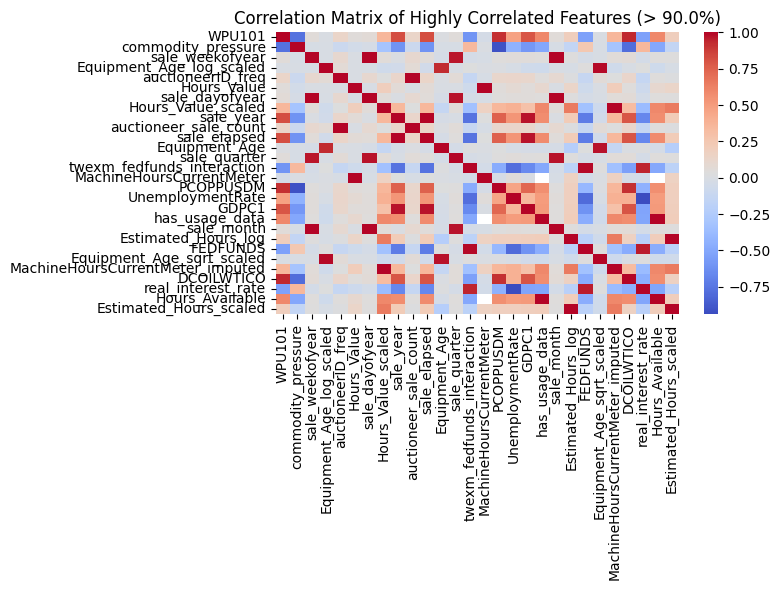

In [ ]:
# list of highly correlated features that are more than 90%

correlation_threshold = 0.90
highly_correlated_features = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > correlation_threshold:
            colname_i = correlation_matrix.columns[i]
            colname_j = correlation_matrix.columns[j]
            highly_correlated_features.add(colname_i)
            highly_correlated_features.add(colname_j)

highly_correlated_features = list(highly_correlated_features)

print(f"Features with correlation > {correlation_threshold * 100}%:")
print(highly_correlated_features)

if highly_correlated_features:
    plt.figure(figsize=(8, 6))
    sns.heatmap(train_df_51[highly_correlated_features].corr(), cmap='coolwarm', fmt=".2f")
    plt.title(f'Correlation Matrix of Highly Correlated Features (> {correlation_threshold * 100}%)')
    plt.tight_layout()
    plt.show()

In [ ]:
# list of highly correlated features that are more than 90%

correlation_threshold = 0.80
highly_correlated_features = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > correlation_threshold:
            colname_i = correlation_matrix.columns[i]
            colname_j = correlation_matrix.columns[j]
            highly_correlated_features.add(colname_i)
            highly_correlated_features.add(colname_j)

highly_correlated_features = list(highly_correlated_features)

print(f"Features with correlation > {correlation_threshold * 100}%:")
print(highly_correlated_features)

if highly_correlated_features:
    plt.figure(figsize=(8, 6))
    sns.heatmap(train_df_51[highly_correlated_features].corr(), cmap='coolwarm', fmt=".2f")
    plt.title(f'Correlation Matrix of Highly Correlated Features (> {correlation_threshold * 100}%)')
    plt.tight_layout()
    plt.show()

NameError: name 'correlation_matrix' is not defined

In [ ]:
# listing highly_correlated_features in desc order

highly_correlated_pairs = []
for i in range(len(highly_correlated_features)):
    for j in range(i + 1, len(highly_correlated_features)):
        colname_i = highly_correlated_features[i]
        colname_j = highly_correlated_features[j]
        correlation_value = correlation_matrix.loc[colname_i, colname_j]
        if abs(correlation_value) > correlation_threshold:
             highly_correlated_pairs.append({'Feature 1': colname_i, 'Feature 2': colname_j, 'Correlation': correlation_value})

highly_correlated_df = pd.DataFrame(highly_correlated_pairs)
highly_correlated_df['Abs_Correlation'] = highly_correlated_df['Correlation'].abs()
highly_correlated_df = highly_correlated_df.sort_values(by='Abs_Correlation', ascending=False).drop(columns='Abs_Correlation')

print(f"\nHighly correlated feature pairs (Absolute Correlation > {correlation_threshold * 100}%) in descending order:")
display(Markdown(highly_correlated_df.to_markdown(index=False)))


Highly correlated feature pairs (Absolute Correlation > 90.0%) in descending order:


| Feature 1                  | Feature 2                        |   Correlation |
|:---------------------------|:---------------------------------|--------------:|
| Hours_Value                | MachineHoursCurrentMeter         |      1        |
| has_usage_data             | Hours_Available                  |      1        |
| Estimated_Hours_log        | Estimated_Hours_scaled           |      1        |
| Hours_Value_scaled         | MachineHoursCurrentMeter_imputed |      0.99994  |
| auctioneerID_freq          | auctioneer_sale_count            |      0.999548 |
| sale_year                  | sale_elapsed                     |      0.99873  |
| sale_dayofyear             | sale_month                       |      0.996871 |
| sale_weekofyear            | sale_dayofyear                   |      0.996504 |
| sale_weekofyear            | sale_month                       |      0.993678 |
| twexm_fedfunds_interaction | FEDFUNDS                         |      0.987474 |
| Equipment_Age_log_scaled   | Equipment_Age_sqrt_scaled        |      0.984977 |
| sale_elapsed               | GDPC1                            |      0.976443 |
| Equipment_Age              | Equipment_Age_sqrt_scaled        |      0.976382 |
| sale_year                  | GDPC1                            |      0.975519 |
| sale_quarter               | sale_month                       |      0.975335 |
| sale_dayofyear             | sale_quarter                     |      0.972245 |
| sale_weekofyear            | sale_quarter                     |      0.969176 |
| FEDFUNDS                   | real_interest_rate               |      0.957557 |
| twexm_fedfunds_interaction | real_interest_rate               |      0.943492 |
| UnemploymentRate           | real_interest_rate               |     -0.939242 |
| WPU101                     | DCOILWTICO                       |      0.937338 |
| Equipment_Age_log_scaled   | Equipment_Age                    |      0.926198 |
| PCOPPUSDM                  | DCOILWTICO                       |      0.916093 |
| commodity_pressure         | PCOPPUSDM                        |     -0.912102 |
| WPU101                     | PCOPPUSDM                        |      0.910923 |

In [ ]:
# dropping highly correlated features (not all)

train_df_52 = train_df_51.drop(columns=[
    'MachineHoursCurrentMeter',
    'has_usage_data',
    'MachineHoursCurrentMeter_imputed',
    'auctioneerID_freq',
    'sale_elapsed',
    'FEDFUNDS'
])

print(f"Shape of train_df_52 after dropping specified columns: {train_df_52.shape}")
train_df_52.to_csv('train_df_52_correlation_based_removed.csv', index=False)

Shape of train_df_52 after dropping specified columns: (469663, 263)


In [ ]:
train_df_52 = pd.read_csv('/content/train_df_52_correlation_based_removed.csv', low_memory=False)

In [ ]:
!cat /proc/meminfo | grep MemTotal

MemTotal:       87530996 kB


In [ ]:
# find out which features are most important for modeling

X = train_df_52.drop('SalePrice', axis=1)
y = train_df_52['SalePrice']

categorical_cols = X.select_dtypes(include='object').columns
X = pd.get_dummies(X, columns=categorical_cols, dummy_na=False)

rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1, verbose=1)
rf.fit(X, y)

feature_importances = pd.Series(rf.feature_importances_, index=X.columns)
sorted_feature_importances = feature_importances.sort_values(ascending=False)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed: 13.5min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 38.6min finished


Top 50 Feature Importances:
lag1_price_model                                                            0.939726
Equipment_Age                                                               0.015016
Enclosure_EROPS w AC                                                        0.005205
fiSecondaryDesc_freq                                                        0.002882
fiBaseModel_freq                                                            0.002789
ProductSize_Large / Medium                                                  0.001854
Equipment_Age_sqrt_scaled                                                   0.001597
Equipment_Age_log_scaled                                                    0.001594
ProductSize_Medium                                                          0.001464
Enclosure_OROPS                                                             0.000983
Ripper_Yes                                                                  0.000976
DCOILWTICO                           

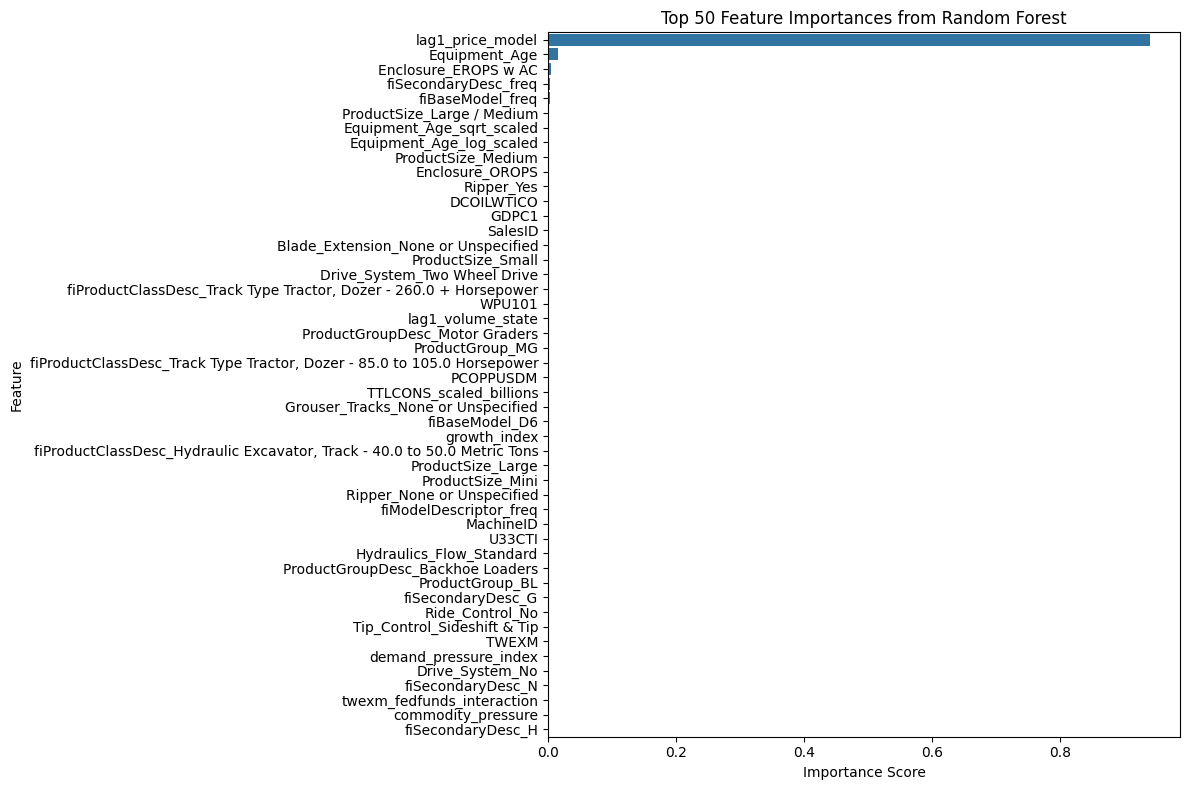

In [ ]:
top_n = 50
print(f"Top {top_n} Feature Importances:")
print(sorted_feature_importances.head(top_n))


plt.figure(figsize=(12, 8))
sns.barplot(x=sorted_feature_importances.head(top_n), y=sorted_feature_importances.head(top_n).index)
plt.title(f'Top {top_n} Feature Importances from Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [ ]:
# removing lag1_price_model

train_df_53 = train_df_52.drop(columns=['lag1_price_model'])
train_df_53.to_csv('train_df_53_lag1_price_model_removed.csv', index=False)
train_df_53.shape

(469663, 262)

In [ ]:
train_df_53 = pd.read_csv('/content/train_df_53_lag1_price_model_removed.csv', low_memory=False)

In [ ]:
train_df_53.shape

(469663, 262)

In [ ]:
# Removed more highly correlated features

train_df_54 = train_df_53.drop(columns=[
    'fiBaseModel_freq',
    'Hours_Value',
    'Equipment_Age',
    'Equipment_Age_sqrt_scaled',
    'Estimated_Hours_scaled',
    'sale_dayofyear',
    'state_Wyoming',
    'Coupler_None or Unspecified',
    'Hydraulics_Standard',
    'Equipment_Age_log_scaled',
    'sale_weekofyear',
    'sale_quarter',
    'TTLCONS_scaled_billions'
])

train_df_54.shape
train_df_54.to_csv('train_df_54_thirteen_highly_correlated_feats_removed.csv', index=False)

In [ ]:
train_df_54.shape

(469663, 249)

In [ ]:
# TAKE 2 find out which features are most important for modeling

X = train_df_54.drop('SalePrice', axis=1)
y = train_df_54['SalePrice']

categorical_cols = X.select_dtypes(include='object').columns
X = pd.get_dummies(X, columns=categorical_cols, dummy_na=False)

rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1, verbose=1)
rf.fit(X, y)

feature_importances = pd.Series(rf.feature_importances_, index=X.columns)
sorted_feature_importances = feature_importances.sort_values(ascending=False)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed: 11.7min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 33.2min finished


Top 50 Feature Importances:
Enclosure_EROPS w AC                                                      0.335762
fiSecondaryDesc_freq                                                      0.085795
fiModelDescriptor_freq                                                    0.046138
ProductSize_Large / Medium                                                0.038242
ProductSize_Medium                                                        0.037852
ProductGroup_SSL                                                          0.025753
ProductGroupDesc_Skid Steer Loaders                                       0.025657
fiSecondaryDesc_H                                                         0.025015
ProductGroup_SSL                                                          0.024260
ProductSize_Large                                                         0.021368
fiSecondaryDesc_G                                                         0.020819
ProductGroup_MG                                            

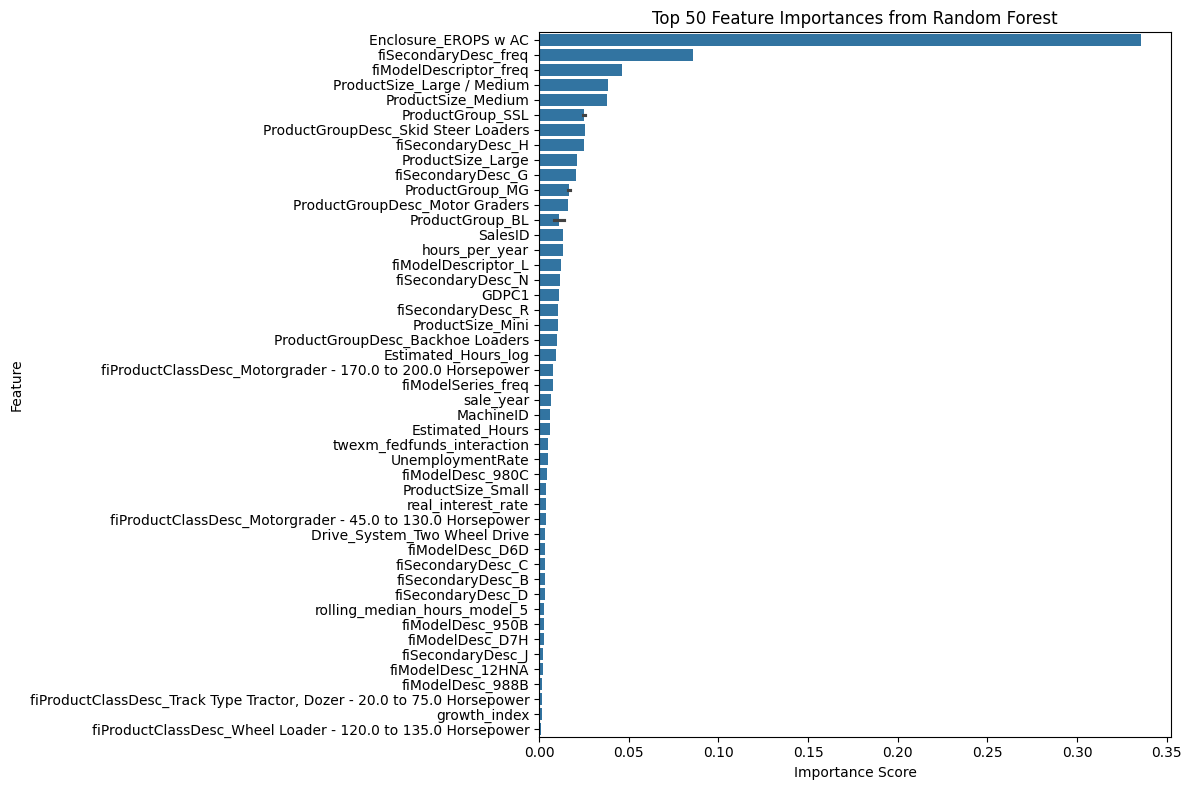

In [ ]:
top_n = 50
print(f"Top {top_n} Feature Importances:")
print(sorted_feature_importances.head(top_n))


plt.figure(figsize=(12, 8))
sns.barplot(x=sorted_feature_importances.head(top_n), y=sorted_feature_importances.head(top_n).index)
plt.title(f'Top {top_n} Feature Importances from Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [ ]:
# Removed more highly correlated features:

train_df_55 = train_df_54.drop(columns=[
    'GDPC1',
    'twexm_fedfunds_interaction',
    'real_interest_rate',
    'WPU101',
    'PCOPPUSDM',
    'avg_building_permits_val',
    'TWEXM'
])

train_df_55.shape
train_df_55.to_csv('train_df_55_SEVEN_MORE_highly_correlated_feats_removed.csv', index=False)

In [ ]:
train_df_54.shape

(469663, 249)

In [ ]:
train_df_55.shape

(469663, 242)

In [ ]:
# TAKE 3 find out which features are most important for modeling

X = train_df_55.drop('SalePrice', axis=1)
y = train_df_55['SalePrice']

categorical_cols = X.select_dtypes(include='object').columns
X = pd.get_dummies(X, columns=categorical_cols, dummy_na=False)

rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1, verbose=1)
rf.fit(X, y)

feature_importances = pd.Series(rf.feature_importances_, index=X.columns)
sorted_feature_importances = feature_importances.sort_values(ascending=False)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed: 12.5min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 35.5min finished


Top 50 Feature Importances:
Enclosure_EROPS w AC                                                      0.335868
fiSecondaryDesc_freq                                                      0.085554
fiModelDescriptor_freq                                                    0.045707
ProductSize_Large / Medium                                                0.038244
ProductSize_Medium                                                        0.037864
ProductGroup_SSL                                                          0.029335
ProductGroupDesc_Skid Steer Loaders                                       0.027892
fiSecondaryDesc_H                                                         0.025022
ProductSize_Large                                                         0.021371
fiSecondaryDesc_G                                                         0.020891
sale_year                                                                 0.020750
ProductGroup_SSL                                           

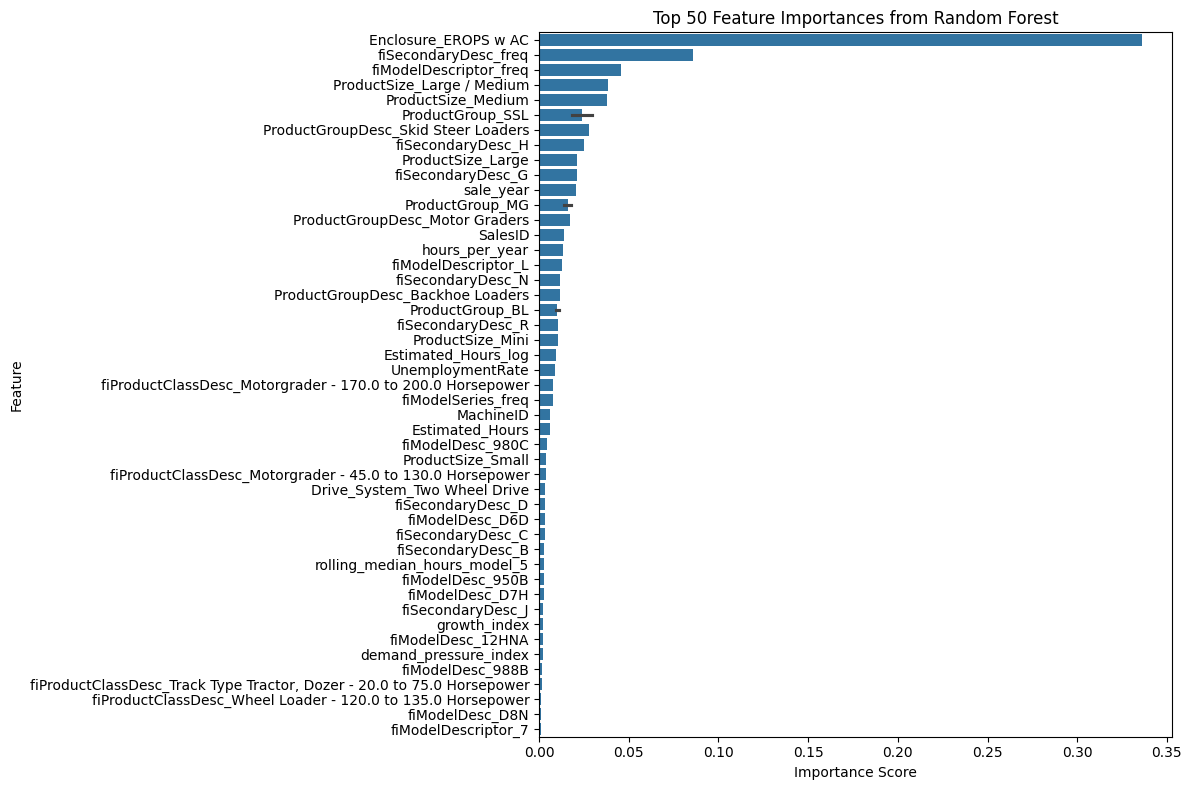

In [ ]:
top_n = 50
print(f"Top {top_n} Feature Importances:")
print(sorted_feature_importances.head(top_n))


plt.figure(figsize=(12, 8))
sns.barplot(x=sorted_feature_importances.head(top_n), y=sorted_feature_importances.head(top_n).index)
plt.title(f'Top {top_n} Feature Importances from Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [ ]:
train_df_55 = pd.read_csv('/content/train_df_55_SEVEN_MORE_highly_correlated_feats_removed.csv', low_memory=False)

In [ ]:
train_df_55.shape

(469663, 242)

In [ ]:
# dropping super low importance features

columns_to_drop = [
    'fiModelDesc_988B',
    'fiProductClassDesc_Track Type Tractor, Dozer - 20.0 to 75.0 Horsepower',
    'fiProductClassDesc_Wheel Loader - 120.0 to 135.0 Horsepower',
    'fiModelDesc_D8N',
    'fiModelDescriptor_7',
    'fiModelDesc_12HNA',
    'demand_pressure_index',
    'growth_index',
    'fiSecondaryDesc_J',
    'fiModelDesc_D7H',
    'fiModelDesc_950B',
    'rolling_median_hours_model_5',
    'fiSecondaryDesc_B',
    'fiSecondaryDesc_C',
    'fiModelDesc_D6D',
    'fiSecondaryDesc_D',
    'Drive_System_Two Wheel Drive',
    'fiProductClassDesc_Motorgrader - 45.0 to 130.0 Horsepower',
    'ProductSize_Small',
    'fiModelDesc_980C',
    'Estimated_Hours',
    'MachineID',
    'fiModelSeries_freq',
    'fiProductClassDesc_Motorgrader - 170.0 to 200.0 Horsepower',
    # Other kinda high correlation columns
    'Estmiated_Hours',
    'hours_per_year'
]

columns_to_drop_existing = [col for col in columns_to_drop if col in train_df_55.columns]

train_df_56 = train_df_55.drop(columns=columns_to_drop_existing)

train_df_56.to_csv('train_df_56_low_feats_removed.csv', index=False)

In [ ]:
train_df_55.shape

(469663, 242)

In [ ]:
train_df_56.shape

(469663, 233)

In [ ]:
# TAKE 4 find out which features are most important for modeling

X = train_df_56.drop('SalePrice', axis=1)
y = train_df_56['SalePrice']

categorical_cols = X.select_dtypes(include='object').columns
X = pd.get_dummies(X, columns=categorical_cols, dummy_na=False)

rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1, verbose=1)
rf.fit(X, y)

feature_importances = pd.Series(rf.feature_importances_, index=X.columns)
sorted_feature_importances = feature_importances.sort_values(ascending=False)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 33.7min finished


Top 50 Feature Importances:
Enclosure_EROPS w AC                                                      0.337972
fiSecondaryDesc_freq                                                      0.082879
fiModelDescriptor_freq                                                    0.046446
ProductSize_Medium                                                        0.040599
ProductSize_Large / Medium                                                0.039564
ProductGroup_SSL                                                          0.033663
Estimated_Hours_log                                                       0.026783
fiSecondaryDesc_H                                                         0.025417
ProductGroupDesc_Skid Steer Loaders                                       0.024821
ProductSize_Large                                                         0.021514
sale_year                                                                 0.020868
fiSecondaryDesc_G                                          

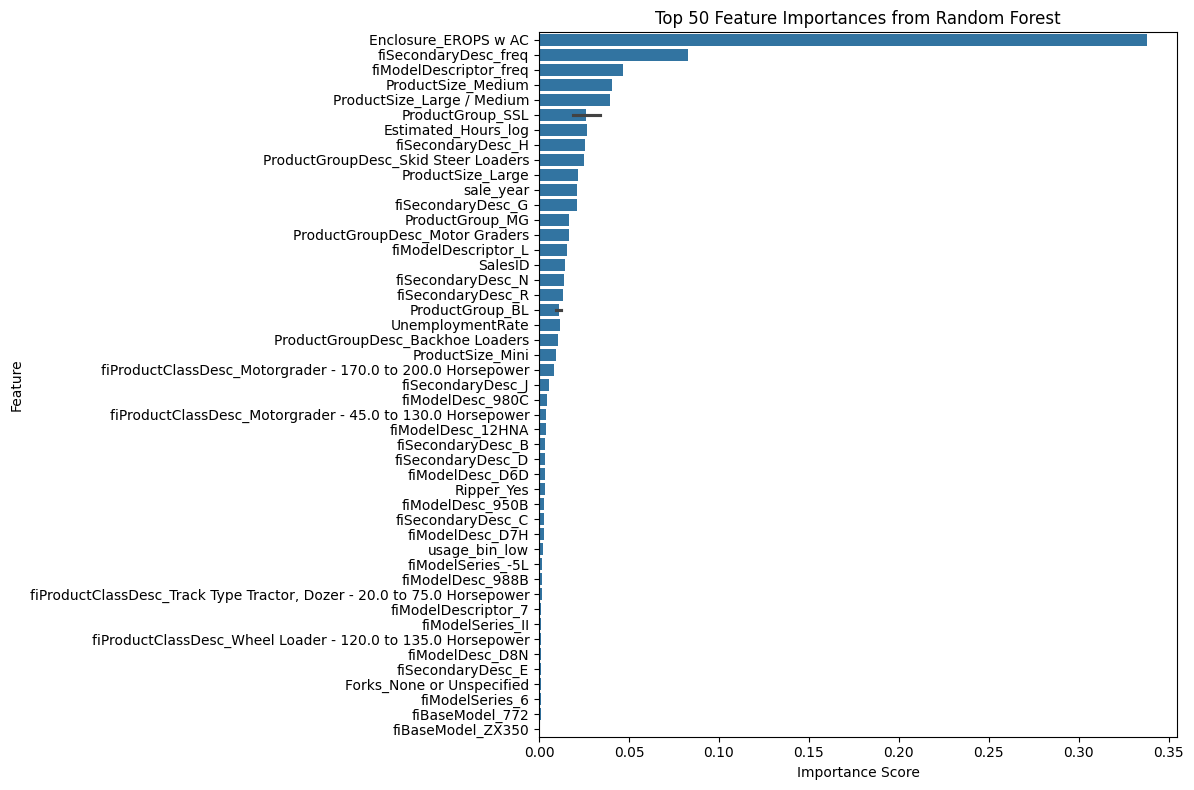

In [ ]:
top_n = 50
print(f"Top {top_n} Feature Importances:")
print(sorted_feature_importances.head(top_n))


plt.figure(figsize=(12, 8))
sns.barplot(x=sorted_feature_importances.head(top_n), y=sorted_feature_importances.head(top_n).index)
plt.title(f'Top {top_n} Feature Importances from Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [ ]:
train_df_56.shape

(469663, 233)

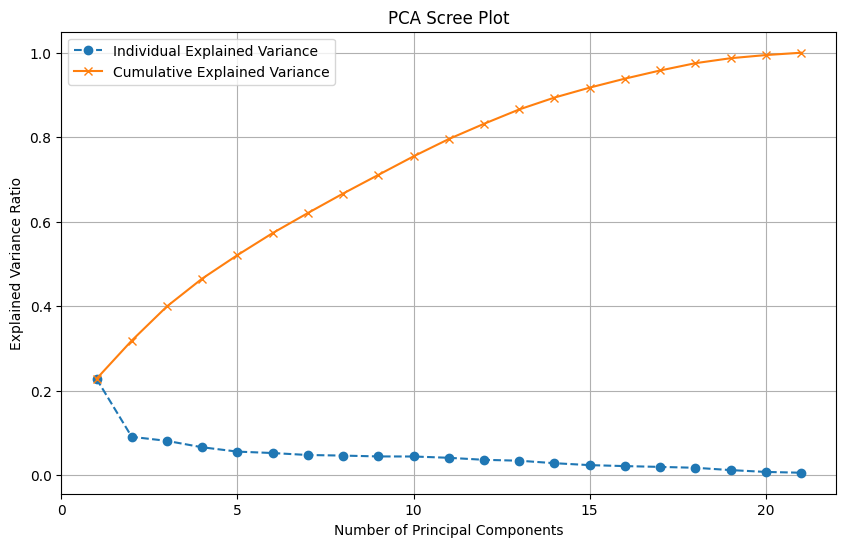


Explained Variance Ratio per Principal Component:
   Explained Variance Ratio  Cumulative Explained Variance
0                  0.227875                       0.227875
1                  0.090560                       0.318435
2                  0.080962                       0.399397
3                  0.065832                       0.465229
4                  0.055534                       0.520763

Cumulative Explained Variance for the first 15 components:
[0.22787549 0.31843501 0.39939697 0.46522911 0.52076281 0.57294468
 0.6204503  0.6665805  0.71070744 0.75467111 0.79558668 0.83170321
 0.86571464 0.89382112 0.91738066]


In [ ]:
# pca scree plot

numerical_cols_56 = train_df_56.select_dtypes(include=np.number).columns.tolist()
features_for_pca = [col for col in numerical_cols_56 if col != 'SalePrice']
X = train_df_56[features_for_pca].copy()

for col in features_for_pca:
    if X[col].isna().sum() > 0:
        median_val = X[col].median()
        X[col] = X[col].fillna(median_val)

scaler_pca = StandardScaler()
X_scaled = scaler_pca.fit_transform(X)
pca = PCA()
pca.fit(X_scaled)

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='--')
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_explained_variance, marker='x', linestyle='-')
plt.title('PCA Scree Plot')
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.xticks(np.arange(0, len(explained_variance_ratio) + 1, 5))
plt.grid(True)
plt.legend(['Individual Explained Variance', 'Cumulative Explained Variance'])
plt.show()

print("\nExplained Variance Ratio per Principal Component:")
print(pd.DataFrame({'Explained Variance Ratio': explained_variance_ratio, 'Cumulative Explained Variance': cumulative_explained_variance}).head())

print("\nCumulative Explained Variance for the first 15 components:")
print(cumulative_explained_variance[:15])

In [ ]:
# VIF for multicolliniearity

numerical_cols_56 = train_df_56.select_dtypes(include=np.number).columns.tolist()


features_for_vif = [col for col in numerical_cols_56 if col != 'SalePrice']

X = train_df_56[features_for_vif].copy()
for col in features_for_vif:
    if X[col].isna().sum() > 0:
        median_val = X[col].median()
        X[col] = X[col].fillna(median_val)

vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
try:
    vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
except Exception as e:
    print(f"Could not calculate VIF for all features due to collinearity or other issues: {e}")
    print("Falling back to calculation on potentially reduced set or investigating the issue...")

vif_data = vif_data.sort_values(by='VIF', ascending=False)

# Listing features with VIF > 5
high_vif_features = vif_data[vif_data['VIF'] > 5]

print("\nFeatures with VIF > 5:")
if high_vif_features.empty:
    print("No features with VIF > 5 found.")
else:
    display(Markdown(high_vif_features.to_markdown(index=False)))

print("\nAll Features and their VIF Scores (Sorted Descending):")
display(Markdown(vif_data.to_markdown(index=False)))


Features with VIF > 5:


| Feature                |         VIF |
|:-----------------------|------------:|
| sale_year              | 15115.4     |
| Price per $100         |  9645.38    |
| OECD                   |  5459.27    |
| U33CTI                 |    65.3265  |
| commodity_pressure     |    23.7964  |
| UnemploymentRate       |    21.727   |
| DCOILWTICO             |    16.6387  |
| SalesID                |     8.3082  |
| fiModelDescriptor_freq |     6.12365 |
| sale_month             |     5.39603 |


All Features and their VIF Scores (Sorted Descending):


| Feature                |         VIF |
|:-----------------------|------------:|
| sale_year              | 15115.4     |
| Price per $100         |  9645.38    |
| OECD                   |  5459.27    |
| U33CTI                 |    65.3265  |
| commodity_pressure     |    23.7964  |
| UnemploymentRate       |    21.727   |
| DCOILWTICO             |    16.6387  |
| SalesID                |     8.3082  |
| fiModelDescriptor_freq |     6.12365 |
| sale_month             |     5.39603 |
| Hours_Available        |     4.9616  |
| sale_day               |     4.91493 |
| sale_dayofweek         |     4.91151 |
| Estimated_Hours_log    |     3.6599  |
| auctioneer_sale_count  |     3.61918 |
| Hours_Value_scaled     |     3.33638 |
| fiSecondaryDesc_freq   |     2.67664 |
| lag1_volume_state      |     2.25232 |
| auctioneerID_missing   |     1.40657 |
| auctioneerID           |     1.35949 |
| lag1_hours_machine     |     1.23202 |

In [ ]:
# sparsity check for all columns

def check_sparsity(df: pd.DataFrame) -> pd.DataFrame:
  sparsity_check = pd.DataFrame({
      'Column': df.columns,
      'Non-Zero Percentage': (df != 0).mean().values * 100
  })
  return sparsity_check

sparsity_summary = check_sparsity(train_df_56)

print("Sparsity Check for train_df_56 (Percentage of Non-Zero Values):")
display(sparsity_summary.sort_values(by='Non-Zero Percentage', ascending=True).to_markdown(index=False))

Sparsity Check for train_df_56 (Percentage of Non-Zero Values):


'| Column                                |   Non-Zero Percentage |\n|:--------------------------------------|----------------------:|\n| Steering_Controls_No                  |           0.000212919 |\n| Grouser_Type_Single                   |           0.000425837 |\n| Enclosure_None or Unspecified         |           0.000425837 |\n| state_Washington DC                   |           0.000425837 |\n| Enclosure_NO ROPS                     |           0.000638756 |\n| Differential_Type_Locking             |           0.000638756 |\n| Tire_Size_10 inch                     |           0.000851674 |\n| Hydraulics_None or Unspecified        |           0.00212919  |\n| Travel_Controls_1 Speed               |           0.0023421   |\n| Tire_Size_10"                         |           0.00255502  |\n| Blade_Type_Coal                       |           0.00276794  |\n| Steering_Controls_Wheel               |           0.00361962  |\n| Enclosure_EROPS AC                    |           0.0040454

In [ ]:
numerical_cols_56 = train_df_56.select_dtypes(include=np.number).columns.tolist()

sparsity_data = []

for col in numerical_cols_56:
  non_zero_count = (train_df_56[col] != 0).sum()
  non_zero_non_nan_count = train_df_56[col][train_df_56[col].notna() & (train_df_56[col] != 0)].count()
  total_count = len(train_df_56)
  non_missing_count = train_df_56[col].count()

  if non_missing_count > 0:
      sparsity = (non_zero_non_nan_count / non_missing_count) * 100
      zero_percentage = ((non_missing_count - non_zero_non_nan_count) / non_missing_count) * 100
  else:
      sparsity = 0
      zero_percentage = 0 # Or 100, depending on definition if all are missing

  sparsity_data.append({
      'Column Name': col,
      'Total Rows': total_count,
      'Non-Missing Rows': non_missing_count,
      'Non-Zero Non-NaN Count': non_zero_non_nan_count,
      'Percentage Non-Zero': f"{sparsity:.2f}%",
      'Percentage Zeros (of non-missing)': f"{zero_percentage:.2f}%"
  })

sparsity_df = pd.DataFrame(sparsity_data)
sparsity_df = sparsity_df.sort_values(by='Percentage Non-Zero', ascending=False)

print("\nSparsity Check for Numerical Columns:")
display(Markdown(sparsity_df.to_markdown(index=False)))


Sparsity Check for Numerical Columns:


| Column Name            |   Total Rows |   Non-Missing Rows |   Non-Zero Non-NaN Count | Percentage Non-Zero   | Percentage Zeros (of non-missing)   |
|:-----------------------|-------------:|-------------------:|-------------------------:|:----------------------|:------------------------------------|
| lag1_volume_state      |       469663 |             469663 |                   469610 | 99.99%                | 0.01%                               |
| auctioneerID           |       469663 |             469663 |                   469138 | 99.89%                | 0.11%                               |
| sale_dayofweek         |       469663 |             469663 |                   429007 | 91.34%                | 8.66%                               |
| auctioneerID_missing   |       469663 |             469663 |                    23560 | 5.02%                 | 94.98%                              |
| Hours_Available        |       469663 |             469663 |                   177102 | 37.71%                | 62.29%                              |
| Estimated_Hours_log    |       469663 |             469658 |                   176246 | 37.53%                | 62.47%                              |
| SalesID                |       469663 |             469663 |                   469663 | 100.00%               | 0.00%                               |
| DCOILWTICO             |       469663 |             469663 |                   469663 | 100.00%               | 0.00%                               |
| commodity_pressure     |       469663 |             469663 |                   469663 | 100.00%               | 0.00%                               |
| sale_day               |       469663 |             469663 |                   469663 | 100.00%               | 0.00%                               |
| sale_year              |       469663 |             469663 |                   469663 | 100.00%               | 0.00%                               |
| UnemploymentRate       |       469663 |             469663 |                   469663 | 100.00%               | 0.00%                               |
| OECD                   |       469663 |             469633 |                   469633 | 100.00%               | 0.00%                               |
| U33CTI                 |       469663 |             469663 |                   469663 | 100.00%               | 0.00%                               |
| SalePrice              |       469663 |             469663 |                   469663 | 100.00%               | 0.00%                               |
| Price per $100         |       469663 |             219137 |                   219137 | 100.00%               | 0.00%                               |
| sale_month             |       469663 |             469663 |                   469663 | 100.00%               | 0.00%                               |
| Hours_Value_scaled     |       469663 |             469663 |                   469663 | 100.00%               | 0.00%                               |
| fiModelDescriptor_freq |       469663 |             469663 |                   469663 | 100.00%               | 0.00%                               |
| fiSecondaryDesc_freq   |       469663 |             469663 |                   469663 | 100.00%               | 0.00%                               |
| auctioneer_sale_count  |       469663 |             469663 |                   469663 | 100.00%               | 0.00%                               |
| lag1_hours_machine     |       469663 |             469663 |                    47546 | 10.12%                | 89.88%                              |

In [ ]:
# drop more columns. removed sparse, collinear, VIF identified, etc..

train_df_57 = train_df_56.drop(columns=[
    'sale_year',
    'Price per $100',
    'Enclosure_None or Unspecified',
    'Enclosure_NO ROPS',
    'Steering_Controls_Wheel',
    'Travel_Controls_1 Speed',
    'state_Washington DC',
    'Blade_Type_Coal',
    'Differential_Type_Locking',
    'Hydraulics_None or Unspecified',
    'Grouser_Type_Single',
    'OECD',
    'Tire_Size_10 inch',
    'Steering_Controls_No',
    'Tire_Size_10 inch'
])

train_df_57.to_csv('train_df_57.csv', index=False)
train_df_57.shape

(469663, 219)

In [ ]:
# TAKE 5 find out which features are most important for modeling

X = train_df_57.drop('SalePrice', axis=1)
y = train_df_57['SalePrice']

categorical_cols = X.select_dtypes(include='object').columns
X = pd.get_dummies(X, columns=categorical_cols, dummy_na=False)

rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1, verbose=1)
rf.fit(X, y)

feature_importances = pd.Series(rf.feature_importances_, index=X.columns)
sorted_feature_importances = feature_importances.sort_values(ascending=False)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed: 11.9min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 33.7min finished


Top 50 Feature Importances:
Enclosure_EROPS w AC                                                        0.338354
fiSecondaryDesc_freq                                                        0.083177
fiModelDescriptor_freq                                                      0.046488
ProductSize_Medium                                                          0.040602
ProductSize_Large / Medium                                                  0.039621
ProductGroup_SSL                                                            0.030701
Estimated_Hours_log                                                         0.028484
fiSecondaryDesc_H                                                           0.025451
ProductGroup_SSL                                                            0.024053
ProductGroupDesc_Skid Steer Loaders                                         0.022537
ProductSize_Large                                                           0.021517
fiSecondaryDesc_G                    

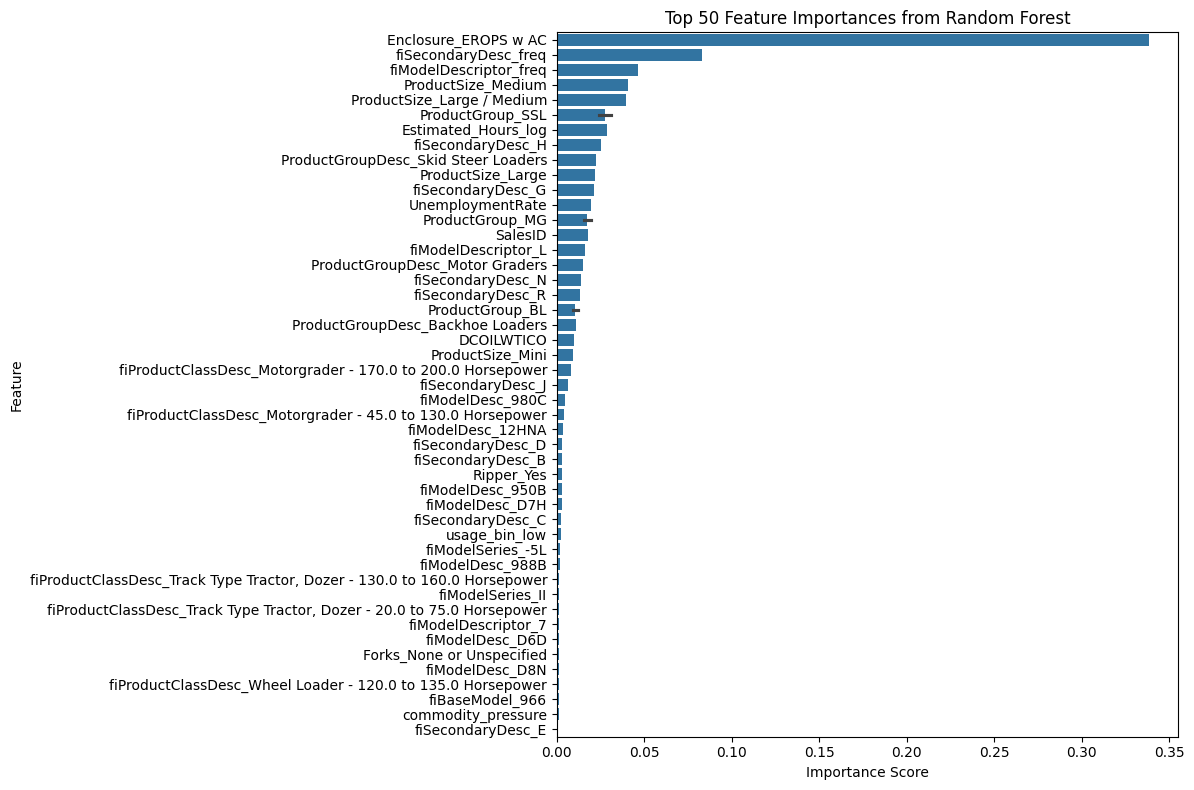

In [ ]:
top_n = 50
print(f"Top {top_n} Feature Importances:")
print(sorted_feature_importances.head(top_n))


plt.figure(figsize=(12, 8))
sns.barplot(x=sorted_feature_importances.head(top_n), y=sorted_feature_importances.head(top_n).index)
plt.title(f'Top {top_n} Feature Importances from Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

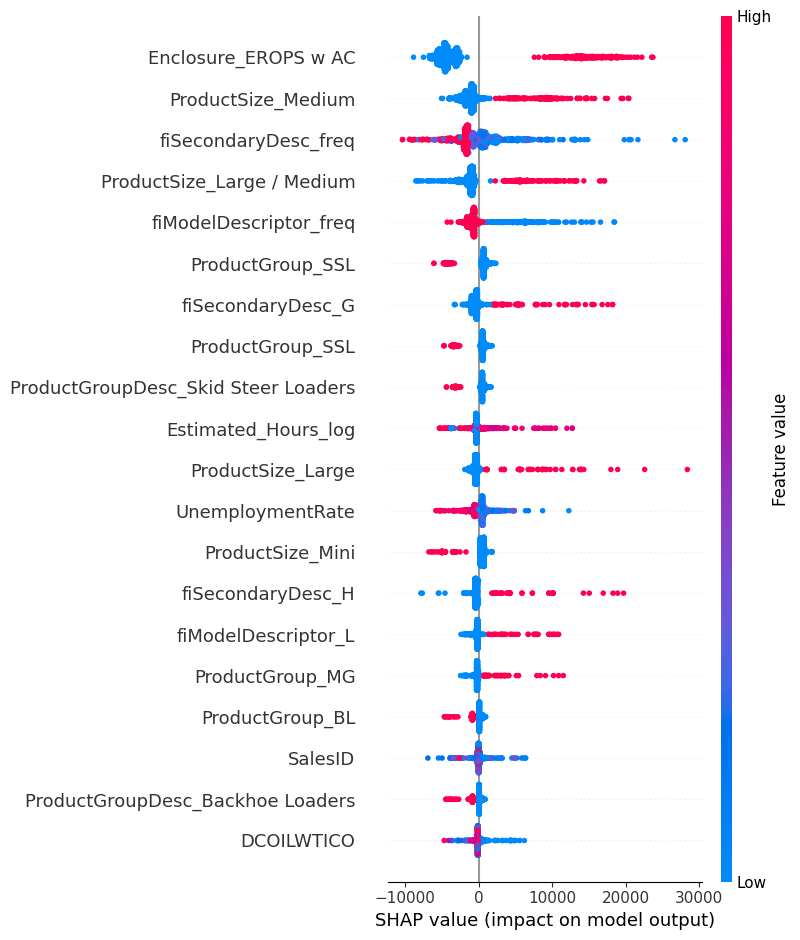

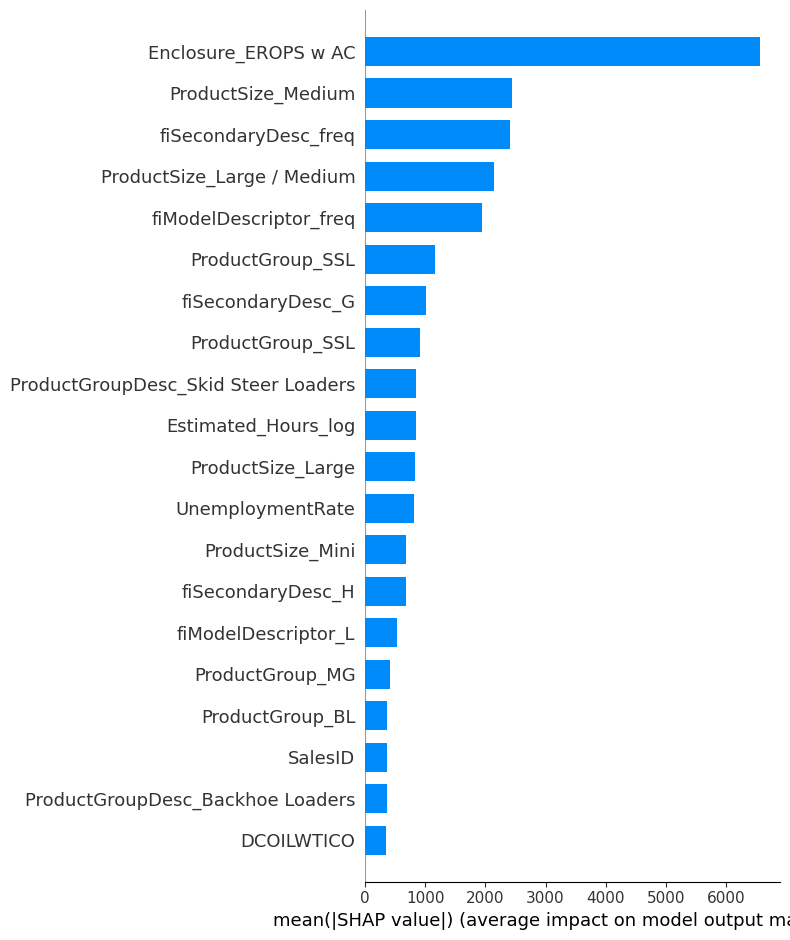

In [ ]:
# running SHAP

X_sample = X.sample(n=min(1000, X.shape[0]), random_state=42)

explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_sample)
shap.summary_plot(shap_values, X_sample)

shap.summary_plot(shap_values, X_sample, plot_type="bar")

In [ ]:
# table of top 20 shap features

shap_importance = pd.DataFrame(
    {'Feature': X_sample.columns, 'SHAP_Importance': np.abs(shap_values).mean(axis=0)}
)
shap_importance = shap_importance.sort_values(by='SHAP_Importance', ascending=False)

top_20_shap_features = shap_importance.head(20)

print("Top 20 SHAP Features (Mean Absolute SHAP Value):")
display(Markdown(top_20_shap_features.to_markdown(index=False)))


Top 20 SHAP Features (Mean Absolute SHAP Value):


| Feature                             |   SHAP_Importance |
|:------------------------------------|------------------:|
| Enclosure_EROPS w AC                |          6573.2   |
| ProductSize_Medium                  |          2447.48  |
| fiSecondaryDesc_freq                |          2405.29  |
| ProductSize_Large / Medium          |          2145.38  |
| fiModelDescriptor_freq              |          1936.17  |
| ProductGroup_SSL                    |          1158.4   |
| fiSecondaryDesc_G                   |          1015.89  |
| ProductGroup_SSL                    |           907.237 |
| ProductGroupDesc_Skid Steer Loaders |           852.715 |
| Estimated_Hours_log                 |           842.618 |
| ProductSize_Large                   |           835.386 |
| UnemploymentRate                    |           815.163 |
| ProductSize_Mini                    |           682.479 |
| fiSecondaryDesc_H                   |           679.962 |
| fiModelDescriptor_L                 |           532.796 |
| ProductGroup_MG                     |           418.846 |
| ProductGroup_BL                     |           368.114 |
| SalesID                             |           354.399 |
| ProductGroupDesc_Backhoe Loaders    |           354.141 |
| DCOILWTICO                          |           351.172 |

In [ ]:
# dropping inactive SHAP values

train_df_58 = train_df_57.drop(columns=[
    'SalesID',
    'DCOILWTICO',
    'ProductGroup_BL',
    'ProductGroup_MG',
    'ProductSize_Mini'
])

train_df_58.to_csv('train_df_58.csv', index=False)
train_df_58.shape
train_df_57.shape

(469663, 219)

In [ ]:
# TAKE 6 find out which features are most important for modeling

X = train_df_58.drop('SalePrice', axis=1)
y = train_df_58['SalePrice']

categorical_cols = X.select_dtypes(include='object').columns
X = pd.get_dummies(X, columns=categorical_cols, dummy_na=False)

rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1, verbose=1)
rf.fit(X, y)

feature_importances = pd.Series(rf.feature_importances_, index=X.columns)
sorted_feature_importances = feature_importances.sort_values(ascending=False)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed: 12.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 34.2min finished


Top 50 Feature Importances:
Enclosure_EROPS w AC                                                       0.341443
fiSecondaryDesc_freq                                                       0.086190
fiModelDescriptor_freq                                                     0.047139
ProductSize_Medium                                                         0.041006
ProductSize_Large / Medium                                                 0.039984
ProductGroupDesc_Skid Steer Loaders                                        0.033077
Estimated_Hours_log                                                        0.029622
ProductGroup_MG                                                            0.026306
fiSecondaryDesc_H                                                          0.025685
ProductGroup_SSL                                                           0.024393
ProductGroupDesc_Motor Graders                                             0.024142
UnemploymentRate                                

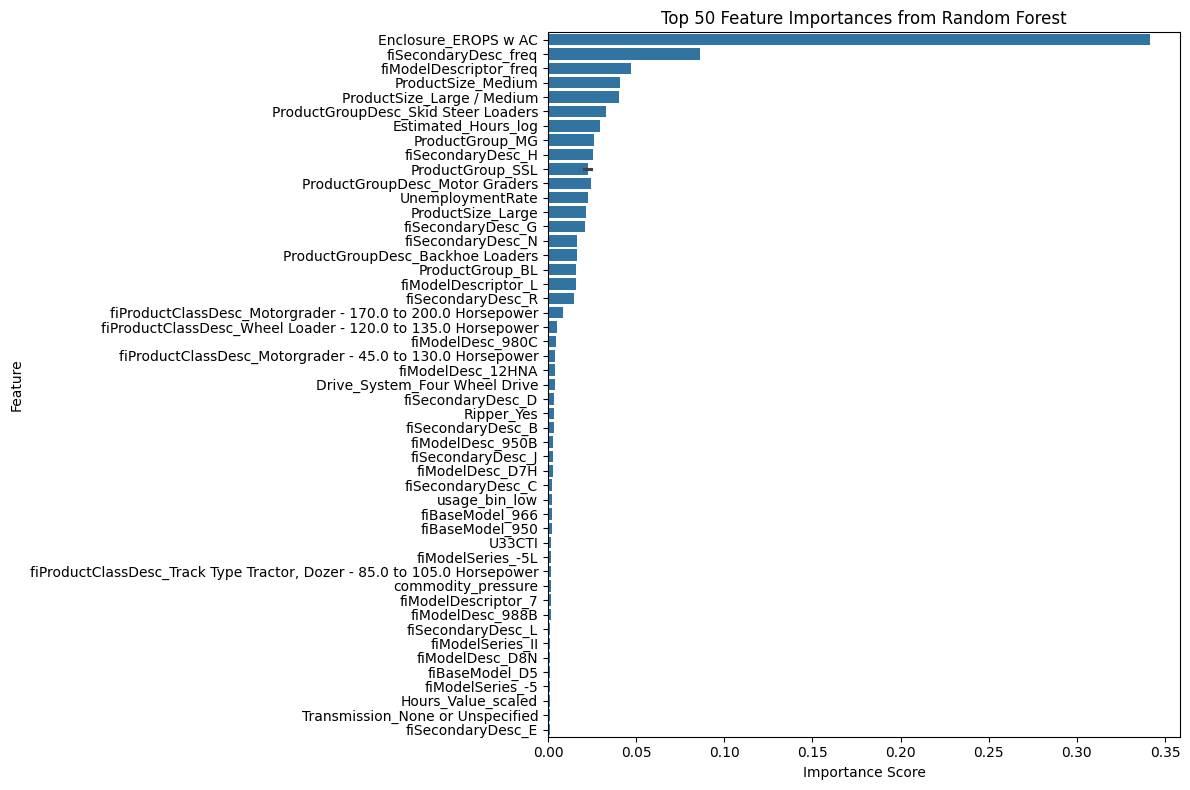

In [ ]:
top_n = 50
print(f"Top {top_n} Feature Importances:")
print(sorted_feature_importances.head(top_n))


plt.figure(figsize=(12, 8))
sns.barplot(x=sorted_feature_importances.head(top_n), y=sorted_feature_importances.head(top_n).index)
plt.title(f'Top {top_n} Feature Importances from Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [ ]:
train_df_58 = pd.read_csv('/content/train_df_58.csv', low_memory=False)

In [ ]:
display(Markdown(train_df_58.columns.to_frame(name='Column Name').to_markdown()))

|                                       | Column Name                           |
|:--------------------------------------|:--------------------------------------|
| SalePrice                             | SalePrice                             |
| auctioneerID                          | auctioneerID                          |
| saledate                              | saledate                              |
| fiModelDesc                           | fiModelDesc                           |
| fiBaseModel                           | fiBaseModel                           |
| fiSecondaryDesc                       | fiSecondaryDesc                       |
| fiModelSeries                         | fiModelSeries                         |
| fiModelDescriptor                     | fiModelDescriptor                     |
| fiProductClassDesc                    | fiProductClassDesc                    |
| ProductGroupDesc                      | ProductGroupDesc                      |
| Engine_Horsepower                     | Engine_Horsepower                     |
| Track_Type                            | Track_Type                            |
| Undercarriage_Pad_Width               | Undercarriage_Pad_Width               |
| Stick_Length                          | Stick_Length                          |
| Hours_Available                       | Hours_Available                       |
| Estimated_Hours_log                   | Estimated_Hours_log                   |
| Pad_Type_Grouser                      | Pad_Type_Grouser                      |
| Pad_Type_None or Unspecified          | Pad_Type_None or Unspecified          |
| Pad_Type_Reversible                   | Pad_Type_Reversible                   |
| Pad_Type_Street                       | Pad_Type_Street                       |
| Stick_Extended                        | Stick_Extended                        |
| Stick_Standard                        | Stick_Standard                        |
| Ride_Control_No                       | Ride_Control_No                       |
| Ride_Control_None or Unspecified      | Ride_Control_None or Unspecified      |
| Ride_Control_Yes                      | Ride_Control_Yes                      |
| Transmission_AutoShift                | Transmission_AutoShift                |
| Transmission_Autoshift                | Transmission_Autoshift                |
| Transmission_Direct Drive             | Transmission_Direct Drive             |
| Transmission_Hydrostatic              | Transmission_Hydrostatic              |
| Transmission_None or Unspecified      | Transmission_None or Unspecified      |
| Transmission_Powershift               | Transmission_Powershift               |
| Transmission_Powershuttle             | Transmission_Powershuttle             |
| Transmission_Standard                 | Transmission_Standard                 |
| Turbocharged_None or Unspecified      | Turbocharged_None or Unspecified      |
| Turbocharged_Yes                      | Turbocharged_Yes                      |
| Blade_Extension_None or Unspecified   | Blade_Extension_None or Unspecified   |
| Blade_Extension_Yes                   | Blade_Extension_Yes                   |
| Blade_Width_12'                       | Blade_Width_12'                       |
| Blade_Width_13'                       | Blade_Width_13'                       |
| Blade_Width_14'                       | Blade_Width_14'                       |
| Blade_Width_16'                       | Blade_Width_16'                       |
| Blade_Width_<12'                      | Blade_Width_<12'                      |
| Blade_Width_None or Unspecified       | Blade_Width_None or Unspecified       |
| Tip_Control_None or Unspecified       | Tip_Control_None or Unspecified       |
| Tip_Control_Sideshift & Tip           | Tip_Control_Sideshift & Tip           |
| Tip_Control_Tip                       | Tip_Control_Tip                       |
| Pushblock_None or Unspecified         | Pushblock_None or Unspecified         |
| Pushblock_Yes                         | Pushblock_Yes                         |
| Ripper_Multi Shank                    | Ripper_Multi Shank                    |
| Ripper_None or Unspecified            | Ripper_None or Unspecified            |
| Ripper_Single Shank                   | Ripper_Single Shank                   |
| Ripper_Yes                            | Ripper_Yes                            |
| Scarifier_None or Unspecified         | Scarifier_None or Unspecified         |
| Scarifier_Yes                         | Scarifier_Yes                         |
| Coupler_Hydraulic                     | Coupler_Hydraulic                     |
| Coupler_Manual                        | Coupler_Manual                        |
| Coupler_System_None or Unspecified    | Coupler_System_None or Unspecified    |
| Coupler_System_Yes                    | Coupler_System_Yes                    |
| Grouser_Tracks_None or Unspecified    | Grouser_Tracks_None or Unspecified    |
| Grouser_Tracks_Yes                    | Grouser_Tracks_Yes                    |
| Grouser_Type_Double                   | Grouser_Type_Double                   |
| Grouser_Type_Triple                   | Grouser_Type_Triple                   |
| Hydraulics_2 Valve                    | Hydraulics_2 Valve                    |
| Hydraulics_3 Valve                    | Hydraulics_3 Valve                    |
| Hydraulics_4 Valve                    | Hydraulics_4 Valve                    |
| Hydraulics_Auxiliary                  | Hydraulics_Auxiliary                  |
| Hydraulics_Base + 1 Function          | Hydraulics_Base + 1 Function          |
| Hydraulics_Base + 2 Function          | Hydraulics_Base + 2 Function          |
| Hydraulics_Base + 3 Function          | Hydraulics_Base + 3 Function          |
| Hydraulics_Base + 4 Function          | Hydraulics_Base + 4 Function          |
| Hydraulics_Base + 5 Function          | Hydraulics_Base + 5 Function          |
| Hydraulics_Base + 6 Function          | Hydraulics_Base + 6 Function          |
| Hydraulics_Flow_High Flow             | Hydraulics_Flow_High Flow             |
| Hydraulics_Flow_None or Unspecified   | Hydraulics_Flow_None or Unspecified   |
| Hydraulics_Flow_Standard              | Hydraulics_Flow_Standard              |
| Thumb_Hydraulic                       | Thumb_Hydraulic                       |
| Thumb_Manual                          | Thumb_Manual                          |
| Thumb_None or Unspecified             | Thumb_None or Unspecified             |
| Pattern_Changer_No                    | Pattern_Changer_No                    |
| Pattern_Changer_None or Unspecified   | Pattern_Changer_None or Unspecified   |
| Pattern_Changer_Yes                   | Pattern_Changer_Yes                   |
| Backhoe_Mounting_None or Unspecified  | Backhoe_Mounting_None or Unspecified  |
| Backhoe_Mounting_Yes                  | Backhoe_Mounting_Yes                  |
| Blade_Type_Angle                      | Blade_Type_Angle                      |
| Blade_Type_Landfill                   | Blade_Type_Landfill                   |
| Blade_Type_No                         | Blade_Type_No                         |
| Blade_Type_None or Unspecified        | Blade_Type_None or Unspecified        |
| Blade_Type_PAT                        | Blade_Type_PAT                        |
| Blade_Type_Semi U                     | Blade_Type_Semi U                     |
| Blade_Type_Straight                   | Blade_Type_Straight                   |
| Blade_Type_U                          | Blade_Type_U                          |
| Blade_Type_VPAT                       | Blade_Type_VPAT                       |
| Travel_Controls_2 Pedal               | Travel_Controls_2 Pedal               |
| Travel_Controls_Differential Steer    | Travel_Controls_Differential Steer    |
| Travel_Controls_Finger Tip            | Travel_Controls_Finger Tip            |
| Travel_Controls_Lever                 | Travel_Controls_Lever                 |
| Travel_Controls_None or Unspecified   | Travel_Controls_None or Unspecified   |
| Travel_Controls_Pedal                 | Travel_Controls_Pedal                 |
| Differential_Type_Limited Slip        | Differential_Type_Limited Slip        |
| Differential_Type_No Spin             | Differential_Type_No Spin             |
| Differential_Type_Standard            | Differential_Type_Standard            |
| Steering_Controls_Command Control     | Steering_Controls_Command Control     |
| Steering_Controls_Conventional        | Steering_Controls_Conventional        |
| Steering_Controls_Four Wheel Standard | Steering_Controls_Four Wheel Standard |
| ProductGroup_SSL                      | ProductGroup_SSL                      |
| ProductGroup_TEX                      | ProductGroup_TEX                      |
| ProductGroup_TTT                      | ProductGroup_TTT                      |
| ProductGroup_WL                       | ProductGroup_WL                       |
| ProductSize_Compact                   | ProductSize_Compact                   |
| ProductSize_Large                     | ProductSize_Large                     |
| ProductSize_Large / Medium            | ProductSize_Large / Medium            |
| ProductSize_Medium                    | ProductSize_Medium                    |
| Enclosure_EROPS                       | Enclosure_EROPS                       |
| Enclosure_EROPS AC                    | Enclosure_EROPS AC                    |
| Enclosure_EROPS w AC                  | Enclosure_EROPS w AC                  |
| Enclosure_OROPS                       | Enclosure_OROPS                       |
| Enclosure_Type_High Profile           | Enclosure_Type_High Profile           |
| Enclosure_Type_Low Profile            | Enclosure_Type_Low Profile            |
| Enclosure_Type_None or Unspecified    | Enclosure_Type_None or Unspecified    |
| Drive_System_All Wheel Drive          | Drive_System_All Wheel Drive          |
| Drive_System_Four Wheel Drive         | Drive_System_Four Wheel Drive         |
| Drive_System_No                       | Drive_System_No                       |
| Forks_None or Unspecified             | Forks_None or Unspecified             |
| Forks_Yes                             | Forks_Yes                             |
| Tire_Size_10"                         | Tire_Size_10"                         |
| Tire_Size_13"                         | Tire_Size_13"                         |
| Tire_Size_14"                         | Tire_Size_14"                         |
| Tire_Size_15.5                        | Tire_Size_15.5                        |
| Tire_Size_15.5"                       | Tire_Size_15.5"                       |
| Tire_Size_17.5                        | Tire_Size_17.5                        |
| Tire_Size_17.5"                       | Tire_Size_17.5"                       |
| Tire_Size_20.5                        | Tire_Size_20.5                        |
| Tire_Size_20.5"                       | Tire_Size_20.5"                       |
| Tire_Size_23.1"                       | Tire_Size_23.1"                       |
| Tire_Size_23.5                        | Tire_Size_23.5                        |
| Tire_Size_23.5"                       | Tire_Size_23.5"                       |
| Tire_Size_26.5                        | Tire_Size_26.5                        |
| Tire_Size_29.5                        | Tire_Size_29.5                        |
| Tire_Size_7.0"                        | Tire_Size_7.0"                        |
| Tire_Size_None or Unspecified         | Tire_Size_None or Unspecified         |
| state_Alabama                         | state_Alabama                         |
| state_Alaska                          | state_Alaska                          |
| state_Arizona                         | state_Arizona                         |
| state_Arkansas                        | state_Arkansas                        |
| state_California                      | state_California                      |
| state_Colorado                        | state_Colorado                        |
| state_Connecticut                     | state_Connecticut                     |
| state_Delaware                        | state_Delaware                        |
| state_Florida                         | state_Florida                         |
| state_Georgia                         | state_Georgia                         |
| state_Hawaii                          | state_Hawaii                          |
| state_Idaho                           | state_Idaho                           |
| state_Illinois                        | state_Illinois                        |
| state_Indiana                         | state_Indiana                         |
| state_Iowa                            | state_Iowa                            |
| state_Kansas                          | state_Kansas                          |
| state_Kentucky                        | state_Kentucky                        |
| state_Louisiana                       | state_Louisiana                       |
| state_Maine                           | state_Maine                           |
| state_Maryland                        | state_Maryland                        |
| state_Massachusetts                   | state_Massachusetts                   |
| state_Michigan                        | state_Michigan                        |
| state_Minnesota                       | state_Minnesota                       |
| state_Mississippi                     | state_Mississippi                     |
| state_Missouri                        | state_Missouri                        |
| state_Montana                         | state_Montana                         |
| state_Nebraska                        | state_Nebraska                        |
| state_Nevada                          | state_Nevada                          |
| state_New Hampshire                   | state_New Hampshire                   |
| state_New Jersey                      | state_New Jersey                      |
| state_New Mexico                      | state_New Mexico                      |
| state_New York                        | state_New York                        |
| state_North Carolina                  | state_North Carolina                  |
| state_North Dakota                    | state_North Dakota                    |
| state_Ohio                            | state_Ohio                            |
| state_Oklahoma                        | state_Oklahoma                        |
| state_Oregon                          | state_Oregon                          |
| state_Pennsylvania                    | state_Pennsylvania                    |
| state_Puerto Rico                     | state_Puerto Rico                     |
| state_Rhode Island                    | state_Rhode Island                    |
| state_South Carolina                  | state_South Carolina                  |
| state_South Dakota                    | state_South Dakota                    |
| state_Tennessee                       | state_Tennessee                       |
| state_Texas                           | state_Texas                           |
| state_Unspecified                     | state_Unspecified                     |
| state_Utah                            | state_Utah                            |
| state_Vermont                         | state_Vermont                         |
| state_Virginia                        | state_Virginia                        |
| state_Washington                      | state_Washington                      |
| state_West Virginia                   | state_West Virginia                   |
| state_Wisconsin                       | state_Wisconsin                       |
| UsageBand_High                        | UsageBand_High                        |
| UsageBand_Low                         | UsageBand_Low                         |
| UsageBand_Medium                      | UsageBand_Medium                      |
| fiSecondaryDesc_freq                  | fiSecondaryDesc_freq                  |
| fiModelDescriptor_freq                | fiModelDescriptor_freq                |
| Hours_Value_scaled                    | Hours_Value_scaled                    |
| auctioneerID_missing                  | auctioneerID_missing                  |
| sale_month                            | sale_month                            |
| Maturity Date                         | Maturity Date                         |
| U33CTI                                | U33CTI                                |
| UnemploymentRate                      | UnemploymentRate                      |
| sale_day                              | sale_day                              |
| sale_dayofweek                        | sale_dayofweek                        |
| is_q4                                 | is_q4                                 |
| is_year_end                           | is_year_end                           |
| is_fiscal_season                      | is_fiscal_season                      |
| usage_bin                             | usage_bin                             |
| commodity_pressure                    | commodity_pressure                    |
| state                                 | state                                 |
| lag1_volume_state                     | lag1_volume_state                     |
| lag1_hours_machine                    | lag1_hours_machine                    |
| auctioneer_sale_count                 | auctioneer_sale_count                 |
| ProductGroup                          | ProductGroup                          |

#### lite

In [ ]:
# reducing for lite version of project.

columns_to_keep = [
    'SalePrice',
    'Enclosure_EROPS w AC',
    'fiSecondaryDesc_freq',
    'fiModelDescriptor_freq',
    'ProductSize_Medium',
    'ProductSize_Large / Medium',
    'ProductGroupDesc_Skid Steer Loaders',
    'Estimated_Hours_log',
    'fiSecondaryDesc_H',
    'ProductGroup_SSL',
    'ProductGroupDesc_Motor Graders',
    'UnemploymentRate',
    'ProductSize_Large',
    'fiSecondaryDesc_G',
    'fiSecondaryDesc_N',
    'ProductGroupDesc_Backhoe Loaders',
    'fiModelDescriptor_L',
    'fiSecondaryDesc_R',
    'Drive_System_Four Wheel Drive',
    'fiSecondaryDesc_D',
    'Ripper_Yes',
    'usage_bin_low',
    'fiBaseModel_966',
    'fiBaseModel_950',
    'SalesID'
]

columns_to_keep_filtered = [col for col in set(columns_to_keep) if col in train_df_58.columns]

train_df_59 = train_df_58[columns_to_keep_filtered].copy()

train_df_59.shape

(421246, 12)

In [ ]:
train_df_59.to_csv('train_df_lite_withsolution.csv', index=False)

In [ ]:
X = train_df_59.drop('SalePrice', axis=1)
y = train_df_59['SalePrice']

categorical_cols = X.select_dtypes(include='object').columns
X = pd.get_dummies(X, columns=categorical_cols, dummy_na=False)

rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1, verbose=1)
rf.fit(X, y)

feature_importances = pd.Series(rf.feature_importances_, index=X.columns)
sorted_feature_importances = feature_importances.sort_values(ascending=False)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   48.3s finished


Top 15 Feature Importances:
Enclosure_EROPS w AC             0.321181
fiSecondaryDesc_freq             0.235186
ProductGroup_SSL                 0.083365
fiModelDescriptor_freq           0.082914
Estimated_Hours_log              0.054511
ProductSize_Medium               0.048451
ProductSize_Large / Medium       0.046881
UnemploymentRate                 0.042685
ProductSize_Large                0.040327
Ripper_Yes                       0.038175
Drive_System_Four Wheel Drive    0.006323
dtype: float64


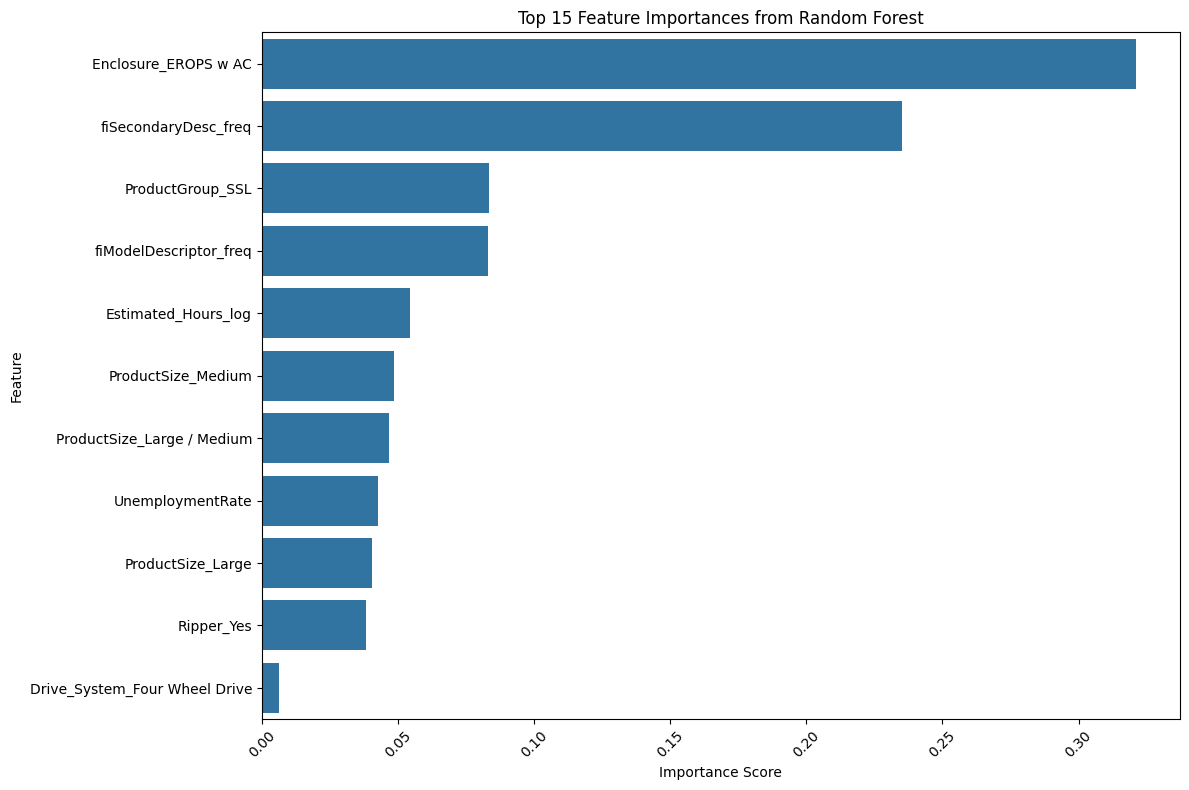

In [ ]:
top_n = 15
print(f"Top {top_n} Feature Importances:")
print(sorted_feature_importances.head(top_n))


plt.figure(figsize=(12, 8))
sns.barplot(x=sorted_feature_importances.head(top_n), y=sorted_feature_importances.head(top_n).index)
plt.title(f'Top {top_n} Feature Importances from Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

### Test and Valid dataframe cleanup and feature creation

| Step | Task Description |
|------|------------------|
| 1. Clean Up Workspace | - Rename and isolate the final training dataframe (`train_df_final`) <br> - Drop all non-final columns (retain only selected features and `SalePrice`) <br> - Save the final feature list as `.pkl` or `.txt` for reproducibility |
| 2. Prepare Validation & Test Sets | - Load `valid_df` and `test_df` <br> - Apply the same feature engineering steps: missing value handling, encoding, scaling, datetime conversion, etc. <br> - Ensure same column order and dtypes as `train_df_final` <br> - Add any derived features used in training (e.g., `Estimated_Hours_log`, `sale_dayofweek`) <br> - Confirm alignment with SHAP/Permutation-required features |
| 3. Confirm Dataset Integrity | - Use `.info()` and `.isnull().sum()` to check for nulls and data type mismatches <br> - Confirm `saledate` is properly converted to datetime (if included) |
| 4. Model Training & Evaluation | - Train `RandomForestRegressor` or other model on `train_df_final` <br> - Perform k-fold cross-validation (e.g., 5-fold) to validate performance <br> - Save trained model using `joblib` or `pickle` |
| 5. Interpretability & Feature Re-ranking | - Run permutation importance on updated model <br> - Generate SHAP summary plots with final features only <br> - Optionally trim underperforming borderline features |
| 6. Final Evaluation & Prediction | - Run model on `valid_df` and compute MAE, RMSE, R² <br> - Predict on `test_df` and format output for submission <br> - Analyze errors and outliers for insights |


Step 2 feature engineering

| Substep | Task Description |
|---------|------------------|
| 2.1 Load Raw Data DONE | - Load the original `valid_df` and `test_df` from source files (CSV, pickle, etc.) |
| 2.2 Handle Missing Values | - Apply the same imputation strategy as the training set: <br> &nbsp;&nbsp;• Fill missing categorical features with `"None"` or `"Unknown"` <br> &nbsp;&nbsp;• Fill numeric features with median or mean used in training <br> &nbsp;&nbsp;• If you used `SimpleImputer` or similar in training, load and apply it here |
| 2.3 Apply Encodings | - Apply same label encoding or one-hot encoding as training <br> &nbsp;&nbsp;• Ensure dummy variables match the structure (e.g., use `train_df.columns` as a reference) <br> &nbsp;&nbsp;• Use `fit_transform` on training and only `transform` on validation/test to prevent data leakage <br> &nbsp;&nbsp;• Drop extra/unmatched one-hot columns in test/valid, or add missing ones with value 0 |
| 2.4 Recreate Derived Features | - Recreate all manually engineered features that were used in `train_df_final`, such as: <br> &nbsp;&nbsp;• `Estimated_Hours_log` = log1p of `Hours_Available` or similar <br> &nbsp;&nbsp;• `sale_dayofweek`, `sale_month`, `is_year_end`, `is_q4`, etc. from `saledate` <br> &nbsp;&nbsp;• `usage_bin`, `Hours_Value_scaled`, `auctioneer_sale_count`, etc. |
| 2.5 Scale Features (if applicable) | - Apply same scaler (e.g., MinMaxScaler, StandardScaler) used in training <br> &nbsp;&nbsp;• Load trained scaler object (via `joblib.load`) and run `transform` on valid/test sets only |
| 2.6 Align Column Order | - Ensure `valid_df` and `test_df` have the **same columns and order** as `train_df_final.drop(columns='SalePrice')` <br> &nbsp;&nbsp;• Use: `valid_df = valid_df[train_df_final.drop(columns='SalePrice').columns]` |
| 2.7 Data Type Check | - Ensure data types match between training and validation/test sets <br> &nbsp;&nbsp;• Use `.dtypes` and cast if needed |


In [ ]:
train_df_final = train_df_58.copy()
train_df_final.to_csv('train_df_final.csv', index=False)

In [ ]:
import pickle

final_features = train_df_final.columns.tolist()
with open('final_features.pkl', 'wb') as f:
  pickle.dump(final_features, f)

len(final_features)

214

for the sake of time, I ran this in another notebook with the same steps but condensed. loading the final dataframes

In [ ]:
test_df = pd.read_csv('/content/test_df_final.csv', low_memory=False)
test_df.shape

(16088, 203)

In [ ]:
valid_df = pd.read_csv('/content/valid_df_final.csv', low_memory=False)

In [ ]:
valid_df.columns

Index(['auctioneerID', 'saledate', 'fiModelDesc', 'fiBaseModel',
       'fiSecondaryDesc', 'fiModelSeries', 'fiModelDescriptor',
       'fiProductClassDesc', 'ProductGroupDesc', 'Engine_Horsepower',
       ...
       'lag1_price_model', 'state', 'lag1_volume_state', 'lag1_hours_machine',
       'rolling_mean_price_model_3', 'rolling_std_price_model_3',
       'auctioneer_avg_price', 'auctioneer_sale_count', 'auctioneer_price_std',
       'ProductGroup'],
      dtype='object', length=214)

In [ ]:
# creating no solution copy
valid_nosolution = valid_df.drop(columns=['SalePrice']).copy()
valid_nosolution.to_csv('valid_nosolution.csv', index=False)

In [ ]:
# matching the columns btwn sets

train_cols = set(train_df_final.columns)
valid_cols = set(valid_df.columns)
valid_nosolution_cols = set(valid_nosolution.columns)
test_cols = set(test_df.columns)

valid_unique_to_valid = list(valid_cols - train_cols)
print("Columns unique to valid_df compared to train_df_final:")
print(valid_unique_to_valid)

valid_nosolution_unique_to_valid_nosolution = list(valid_nosolution_cols - train_cols)
print("\nColumns unique to valid_nosolution compared to train_df_final:")
print(valid_nosolution_unique_to_valid_nosolution)

test_unique_to_test = list(test_cols - train_cols)
print("\nColumns unique to test_df compared to train_df_final:")
test_unique_to_test

Columns unique to valid_df compared to train_df_final:
['auctioneer_price_std', 'SalePrice_log', 'rolling_mean_price_model_3', 'Travel_Controls_1 Speed', 'rolling_std_price_model_3', 'Usage', 'SalePrice_scaled', 'lag1_price_model', 'auctioneer_avg_price']

Columns unique to valid_nosolution compared to train_df_final:
['auctioneer_price_std', 'SalePrice_log', 'rolling_mean_price_model_3', 'Travel_Controls_1 Speed', 'rolling_std_price_model_3', 'Usage', 'SalePrice_scaled', 'lag1_price_model', 'auctioneer_avg_price']

Columns unique to test_df compared to train_df_final:


['auctioneer_popularity_score']

In [ ]:
test_df_MR = test_df.copy()
test_df_MR = test_df_MR.drop(columns=['auctioneer_popularity_score'])
test_df_MR.to_csv('test_df_MR.csv', index=False)
test_df_MR.shape

valid_df_MR = valid_df.copy()
valid_df_MR = valid_df_MR.drop(columns=['auctioneer_price_std', 'SalePrice_log', 'rolling_mean_price_model_3', 'Travel_Controls_1 Speed', 'rolling_std_price_model_3', 'Usage', 'SalePrice_scaled', 'lag1_price_model', 'auctioneer_avg_price'])
valid_df_MR.to_csv('valid_df_MR.csv', index=False)
valid_df_MR.shape

valid_nosolution_MR = valid_nosolution.copy()
valid_nosolution_MR = valid_nosolution_MR.drop(columns=['auctioneer_price_std', 'SalePrice_log', 'rolling_mean_price_model_3', 'Travel_Controls_1 Speed', 'rolling_std_price_model_3', 'Usage', 'SalePrice_scaled', 'lag1_price_model', 'auctioneer_avg_price'])
valid_nosolution_MR.to_csv('valid_nosolution_MR.csv', index=False)
valid_nosolution_MR.shape

(15486, 204)

In [ ]:
# matching the columns btwn sets again

train_cols = set(train_df_final.columns)
valid_cols = set(valid_df_MR.columns)
valid_nosolution_cols = set(valid_nosolution_MR.columns)
test_cols = set(test_df_MR.columns)

valid_unique_to_valid = list(valid_cols - train_cols)
print("Columns unique to valid_df compared to train_df_final:")
print(valid_unique_to_valid)

valid_nosolution_unique_to_valid_nosolution = list(valid_nosolution_cols - train_cols)
print("\nColumns unique to valid_nosolution compared to train_df_final:")
print(valid_nosolution_unique_to_valid_nosolution)

test_unique_to_test = list(test_cols - train_cols)
print("\nColumns unique to test_df compared to train_df_final:")
test_unique_to_test

Columns unique to valid_df compared to train_df_final:
[]

Columns unique to valid_nosolution compared to train_df_final:
[]

Columns unique to test_df compared to train_df_final:


[]

In [ ]:
# what are the MR datasets missing from train_df_final?

train_cols = set(train_df_final.columns)
valid_cols = set(valid_df_MR.columns)
valid_nosolution_cols = set(valid_nosolution_MR.columns)
test_cols = set(test_df_MR.columns)

missing_in_test_from_train = list(train_cols - test_cols)

print("Columns in train_df_final that are missing from test_df_MR:")
print(missing_in_test_from_train)

missing_in_valid_from_train = list(train_cols - valid_cols)

print("Columns in train_df_final that are missing from valid_df_MR:")
missing_in_valid_from_train

missing_in_valid_nosolution_from_train = list(train_cols - valid_nosolution_cols)

print("Columns in train_df_final that are missing from valid_nosolution_MR:")
missing_in_valid_nosolution_from_train

Columns in train_df_final that are missing from test_df_MR:
['Tire_Size_10"', 'Blade_Type_Landfill', 'state_Delaware', 'SalePrice', 'Tire_Size_23.1"', 'Enclosure_EROPS AC', 'Backhoe_Mounting_Yes', 'auctioneerID_missing', 'Pattern_Changer_No', 'state_Unspecified', 'Tire_Size_7.0"', 'Transmission_AutoShift']
Columns in train_df_final that are missing from valid_df_MR:
Columns in train_df_final that are missing from valid_nosolution_MR:


['Tire_Size_23.1"',
 'SalePrice',
 'state_Alaska',
 'Backhoe_Mounting_Yes',
 'auctioneerID_missing',
 'state_Unspecified',
 'Transmission_AutoShift',
 'state_Vermont',
 'state_Hawaii',
 'Blade_Type_No']

In [ ]:
train_df_MR_nosolution = train_df_final.copy()

columns_to_remove = [
 'Tire_Size_23.1"',
 'SalePrice',
 'state_Alaska',
 'Backhoe_Mounting_Yes',
 'auctioneerID_missing',
 'state_Unspecified',
 'Transmission_AutoShift',
 'state_Vermont',
 'state_Hawaii',
 'Blade_Type_No'
]

columns_to_drop_from_final = [col for col in columns_to_remove if col in train_df_final.columns]
train_df_final = train_df_final.drop(columns=columns_to_drop_from_final)

train_df_MR.to_csv('train_df_MR_nosolution.csv', index=False)
train_df_MR.shape

(469663, 204)

In [ ]:
valid_nosolution_MR.shape

(15486, 204)

In [ ]:
valid_df_MR.shape

(15486, 205)

In [ ]:
test_df_MR.shape

(16088, 202)

In [ ]:
train_df_final.shape

(469663, 204)

In [ ]:
train_df_MR.shape

(469663, 204)

In [ ]:
train_df_MR_withsolution = train_df_58.copy()
columns_to_remove = [
 'Tire_Size_23.1"',
 'state_Alaska',
 'Backhoe_Mounting_Yes',
 'auctioneerID_missing',
 'state_Unspecified',
 'Transmission_AutoShift',
 'state_Vermont',
 'state_Hawaii',
 'Blade_Type_No'
]

columns_to_drop_from_final = [col for col in columns_to_remove if col in train_df_MR_withsolution.columns]
train_df_MR_withsolution = train_df_MR_withsolution.drop(columns=columns_to_drop_from_final)
train_df_MR_withsolution.shape
train_df_MR_withsolution.to_csv('train_df_MR_withsolution.csv', index=False)

In [ ]:
train_df_MR_withsolution.shape

(469663, 205)

In [ ]:
train_df_MR_nosolution.shape

(469663, 204)

In [ ]:
train_df_MR_nosolution.to_csv('train_df_MR_nosolution.csv', index=False)

In [ ]:
print(train_df_MR_withsolution.columns.tolist())

['SalePrice', 'auctioneerID', 'saledate', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc', 'fiModelSeries', 'fiModelDescriptor', 'fiProductClassDesc', 'ProductGroupDesc', 'Engine_Horsepower', 'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Hours_Available', 'Estimated_Hours_log', 'Pad_Type_Grouser', 'Pad_Type_None or Unspecified', 'Pad_Type_Reversible', 'Pad_Type_Street', 'Stick_Extended', 'Stick_Standard', 'Ride_Control_No', 'Ride_Control_None or Unspecified', 'Ride_Control_Yes', 'Transmission_Autoshift', 'Transmission_Direct Drive', 'Transmission_Hydrostatic', 'Transmission_None or Unspecified', 'Transmission_Powershift', 'Transmission_Powershuttle', 'Transmission_Standard', 'Turbocharged_None or Unspecified', 'Turbocharged_Yes', 'Blade_Extension_None or Unspecified', 'Blade_Extension_Yes', "Blade_Width_12'", "Blade_Width_13'", "Blade_Width_14'", "Blade_Width_16'", "Blade_Width_<12'", 'Blade_Width_None or Unspecified', 'Tip_Control_None or Unspecified', 'Tip_Control_Sideshi

#### lite



In [ ]:
train_df = pd.read_csv('/content/Train.csv', low_memory=False)

In [ ]:
# Identifying which columns need to be engineered for test, valid, validsol
# Engineer these

train_df_original_cols = set(train_df.columns)
train_df_59_cols = set(train_df_59.columns)

new_cols_in_train_df_59 = list(train_df_59_cols - train_df_original_cols)

new_cols_in_train_df_59

['fiModelDescriptor_freq',
 'ProductSize_Large / Medium',
 'ProductGroup_SSL',
 'Ripper_Yes',
 'ProductSize_Medium',
 'ProductSize_Large',
 'Enclosure_EROPS w AC',
 'UnemploymentRate',
 'Drive_System_Four Wheel Drive',
 'fiSecondaryDesc_freq',
 'Estimated_Hours_log']

    'SalePrice',
    'Enclosure_EROPS w AC',
    'fiSecondaryDesc_freq',
    'fiModelDescriptor_freq',
    'ProductSize_Medium',
    'ProductSize_Large / Medium',
    'ProductGroupDesc_Skid Steer Loaders',
    'Estimated_Hours_log',
    'fiSecondaryDesc_H',
    'ProductGroup_SSL',
    'ProductGroupDesc_Motor Graders',
    'UnemploymentRate',
    'ProductSize_Large',
    'fiSecondaryDesc_G',
    'fiSecondaryDesc_N',
    'ProductGroupDesc_Backhoe Loaders',
    'fiModelDescriptor_L',
    'fiSecondaryDesc_R',
    'Drive_System_Four Wheel Drive',
    'fiSecondaryDesc_D',
    'Ripper_Yes',
    'usage_bin_low',
    'fiBaseModel_966',
    'fiBaseModel_950'

In [ ]:
test_df = pd.read_csv('/content/Test.csv', low_memory=False)
valid_df = pd.read_csv('/content/Valid.csv', low_memory=False)
valid_solution = pd.read_csv('/content/ValidSolution.csv', low_memory=False)

In [ ]:
valid_df.columns

Index(['SalesID', 'MachineID', 'ModelID', 'datasource', 'auctioneerID',
       'YearMade', 'MachineHoursCurrentMeter', 'UsageBand', 'saledate',
       'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc', 'fiModelSeries',
       'fiModelDescriptor', 'ProductSize', 'fiProductClassDesc', 'state',
       'ProductGroup', 'ProductGroupDesc', 'Drive_System', 'Enclosure',
       'Forks', 'Pad_Type', 'Ride_Control', 'Stick', 'Transmission',
       'Turbocharged', 'Blade_Extension', 'Blade_Width', 'Enclosure_Type',
       'Engine_Horsepower', 'Hydraulics', 'Pushblock', 'Ripper', 'Scarifier',
       'Tip_Control', 'Tire_Size', 'Coupler', 'Coupler_System',
       'Grouser_Tracks', 'Hydraulics_Flow', 'Track_Type',
       'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb', 'Pattern_Changer',
       'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type', 'Travel_Controls',
       'Differential_Type', 'Steering_Controls'],
      dtype='object')

In [ ]:
valid_solution.columns

Index(['SalesID', 'SalePrice', 'Usage'], dtype='object')

In [ ]:
valid_df_combined = pd.merge(valid_df, valid_solution, on='SalesID', how='left')
valid_df_combined.shape

(11573, 54)

In [ ]:
valid_df_combined.columns

Index(['SalesID', 'MachineID', 'ModelID', 'datasource', 'auctioneerID',
       'YearMade', 'MachineHoursCurrentMeter', 'UsageBand', 'saledate',
       'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc', 'fiModelSeries',
       'fiModelDescriptor', 'ProductSize', 'fiProductClassDesc', 'state',
       'ProductGroup', 'ProductGroupDesc', 'Drive_System', 'Enclosure',
       'Forks', 'Pad_Type', 'Ride_Control', 'Stick', 'Transmission',
       'Turbocharged', 'Blade_Extension', 'Blade_Width', 'Enclosure_Type',
       'Engine_Horsepower', 'Hydraulics', 'Pushblock', 'Ripper', 'Scarifier',
       'Tip_Control', 'Tire_Size', 'Coupler', 'Coupler_System',
       'Grouser_Tracks', 'Hydraulics_Flow', 'Track_Type',
       'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb', 'Pattern_Changer',
       'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type', 'Travel_Controls',
       'Differential_Type', 'Steering_Controls', 'SalePrice', 'Usage'],
      dtype='object')

In [ ]:
cols_to_check = [
    'SalePrice',
    'Enclosure_EROPS w AC',
    'fiSecondaryDesc_freq',
    'fiModelDescriptor_freq',
    'ProductSize_Medium',
    'ProductSize_Large / Medium',
    'ProductGroupDesc_Skid Steer Loaders',
    'Estimated_Hours_log',
    'fiSecondaryDesc_H',
    'ProductGroup_SSL',
    'ProductGroupDesc_Motor Graders',
    'UnemploymentRate',
    'ProductSize_Large',
    'fiSecondaryDesc_G',
    'fiSecondaryDesc_N',
    'ProductGroupDesc_Backhoe Loaders',
    'fiModelDescriptor_L',
    'fiSecondaryDesc_R',
    'Drive_System_Four Wheel Drive',
    'fiSecondaryDesc_D',
    'Ripper_Yes',
    'usage_bin_low',
    'fiBaseModel_966',
    'fiBaseModel_950'
]

train_df_to_check = train_df_59

print("Columns present in train_df:")
for col in cols_to_check:
  if col in train_df_to_check.columns:
    print(f"- {col}")
  else:
    print(f"- {col} (NOT found)")

Columns present in train_df:
- SalePrice
- Enclosure_EROPS w AC
- fiSecondaryDesc_freq
- fiModelDescriptor_freq
- ProductSize_Medium
- ProductSize_Large / Medium
- ProductGroupDesc_Skid Steer Loaders (NOT found)
- Estimated_Hours_log
- fiSecondaryDesc_H (NOT found)
- ProductGroup_SSL
- ProductGroupDesc_Motor Graders (NOT found)
- UnemploymentRate
- ProductSize_Large
- fiSecondaryDesc_G (NOT found)
- fiSecondaryDesc_N (NOT found)
- ProductGroupDesc_Backhoe Loaders (NOT found)
- fiModelDescriptor_L (NOT found)
- fiSecondaryDesc_R (NOT found)
- Drive_System_Four Wheel Drive
- fiSecondaryDesc_D (NOT found)
- Ripper_Yes
- usage_bin_low (NOT found)
- fiBaseModel_966 (NOT found)
- fiBaseModel_950 (NOT found)


##### test.csv

In [ ]:
test_df.shape

(12457, 52)

In [ ]:
# 'fiModelDescriptor_freq'

test_df_1_frequency = test_df.copy()

frequency_cols = ['fiModelDescriptor']

for col in frequency_cols:
    if col in test_df_1_frequency.columns:
        freq_map = test_df_1_frequency[col].value_counts(dropna=False)
        test_df_1_frequency[f'{col}_freq'] = test_df_1_frequency[col].map(freq_map)
    else:
        print(f"Column '{col}' not found in the DataFrame.")
test_df_1_frequency.shape

(12457, 53)

In [ ]:
# ProductSize_Large / Medium column
test_df_2 = test_df_1_frequency.copy()
test_df_2['ProductSize_Large / Medium'] = test_df_2['ProductSize'].apply(lambda x: 1 if x in ['Large', 'Medium'] else 0)

Verification of ProductSize_Large / Medium column:
ProductSize     ProductSize_Large / Medium
NaN             0                             6409
Medium          1                             2030
Large / Medium  0                             1695
Mini            0                              997
Small           0                              724
Large           1                              444
Compact         0                              158
Name: count, dtype: int64


In [ ]:
# ProductGroup_SSL
test_df_3 = test_df_2.copy()
test_df_3['ProductGroup_SSL'] = (test_df_3['ProductGroup'] == 'SSL').astype(int)
print(test_df_3[['ProductGroup', 'ProductGroup_SSL']].value_counts(dropna=False))
print("\nShape of test_df_3:", test_df_3.shape)

ProductGroup  ProductGroup_SSL
TEX           0                   3417
WL            0                   2140
BL            0                   2119
SSL           1                   2067
TTT           0                   2062
MG            0                    652
Name: count, dtype: int64

Shape of test_df_3: (12457, 55)


In [ ]:
# Ripper_Yes
def create_ripper_yes_feature(df: pd.DataFrame) -> pd.DataFrame:
  df_copy = df.copy()
  if 'Ripper' in df_copy.columns:
    df_copy['Ripper_Yes'] = (df_copy['Ripper'] == 'Yes').astype(int)
  else:
    print("Warning: 'Ripper' column not found. Cannot create 'Ripper_Yes'.")
    df_copy['Ripper_Yes'] = 0
  return df_copy

test_df_4 = create_ripper_yes_feature(test_df_3)
test_df_4.shape

(12457, 56)

In [ ]:
# ProductSize_Medium

def create_product_size_medium_feature(df: pd.DataFrame) -> pd.DataFrame:
  df_copy = df.copy()
  if 'ProductSize' in df_copy.columns:
    df_copy['ProductSize_Medium'] = (df_copy['ProductSize'] == 'Medium').astype(int)
  else:
    print("Warning: 'ProductSize' column not found. Cannot create 'ProductSize_Medium'.")
    df_copy['ProductSize_Medium'] = 0
  return df_copy

test_df_5 = create_product_size_medium_feature(test_df_4)
test_df_5.shape

(12457, 57)

In [ ]:
# ProductSize_Large

def create_product_size_large_feature(df: pd.DataFrame) -> pd.DataFrame:
  df_copy = df.copy()
  if 'ProductSize' in df_copy.columns:
    df_copy['ProductSize_Large'] = (df_copy['ProductSize'] == 'Large').astype(int)
  else:
    print("Warning: 'ProductSize' column not found. Cannot create 'ProductSize_Large'.")
    df_copy['ProductSize_Large'] = 0
  return df_copy

test_df_6 = create_product_size_large_feature(test_df_5)
test_df_6.shape

(12457, 58)

In [ ]:
# Enclosure_EROPS w AC

def create_enclosure_erops_ac_feature(df: pd.DataFrame) -> pd.DataFrame:
  df_copy = df.copy()
  if 'Enclosure' in df_copy.columns:
    df_copy['Enclosure_EROPS w AC'] = (df_copy['Enclosure'] == 'EROPS w AC').astype(int)
  else:
    print("Warning: 'Enclosure' column not found. Cannot create 'Enclosure_EROPS w AC'.")
    df_copy['Enclosure_EROPS w AC'] = 0
  return df_copy

test_df_7 = create_enclosure_erops_ac_feature(test_df_6)
test_df_7.shape

(12457, 59)

In [ ]:
unemployment_rate_df_1 = pd.read_csv('/content/unemployment_rate_df_1.csv', low_memory=False)
unemployment_rate_df_1.shape

(929, 2)

In [ ]:
unemployment_rate_df_1.columns

Index(['DATE', 'UnemploymentRate'], dtype='object')

In [ ]:
# UnemploymentRate

test_df_8 = test_df_7.copy()

unemployment_rate_df_1['DATE'] = pd.to_datetime(unemployment_rate_df_1['DATE'])
test_df_8['saledate'] = pd.to_datetime(test_df_8['saledate'])

test_df_8 = pd.merge_asof(
    test_df_8.sort_values('saledate'),
    unemployment_rate_df_1.sort_values('DATE')[['DATE', 'UnemploymentRate']],
    left_on='saledate',
    right_on='DATE',
    direction='backward'
)
test_df_8 = test_df_8.drop(columns=['DATE']).sort_values('SalesID')

test_df_8.shape

(12457, 60)

In [ ]:
train_df_60 = train_df_59.drop(columns=['Drive_System_Four Wheel Drive'])
print(f"Shape of train_df_59: {train_df_59.shape}")
print(f"Shape of train_df_60: {train_df_60.shape}")

Shape of train_df_59: (421246, 12)
Shape of train_df_60: (421246, 11)


In [ ]:
# fiSecondaryDesc_freq

test_df_9 = test_df_8.copy()

if 'fiSecondaryDesc' in test_df_9.columns:
  freq_map = test_df_9['fiSecondaryDesc'].value_counts(dropna=False)
  test_df_9['fiSecondaryDesc_freq'] = test_df_9['fiSecondaryDesc'].map(freq_map)
else:
  print("Warning: 'fiSecondaryDesc' column not found. Cannot create 'fiSecondaryDesc_freq'.")
  test_df_9['fiSecondaryDesc_freq'] = 0

test_df_9.shape

(12457, 61)

In [ ]:
# Estimated_Hours feature

def create_estimated_hours_feature(df: pd.DataFrame, annual_usage_rates_df: pd.DataFrame) -> pd.DataFrame:
  df_copy = df.copy()

  if 'saledate' not in df_copy.columns:
      print("Error: 'saledate' column not found.")
      return df_copy
  df_copy['saledate'] = pd.to_datetime(df_copy['saledate'])

  if 'YearMade' not in df_copy.columns:
      print("Error: 'YearMade' column not found.")
      df_copy['YearMade'] = pd.NA

  if 'Equipment_Age' not in df_copy.columns:
      df_copy['Equipment_Age'] = df_copy['saledate'].dt.year - df_copy['YearMade']
      df_copy.loc[(df_copy['YearMade'] > df_copy['saledate'].dt.year) | (df_copy['YearMade'] < 1000), 'Equipment_Age'] = pd.NA

  df_copy['Hours_Available'] = df_copy['MachineHoursCurrentMeter'].apply(lambda x: 1 if pd.notna(x) and x > 0 else 0)
  df_copy['Hours_Value'] = df_copy['MachineHoursCurrentMeter'].fillna(0) # Use fillna(0) to represent zero hours when missing
  df_copy['Estimated_Hours'] = np.where(df_copy['Hours_Available'] == 1, df_copy['Hours_Value'], pd.NA)

  if annual_usage_rates_df is not None and 'Annual_Hours' in annual_usage_rates_df.columns:
      overall_median_annual_hours = annual_usage_rates_df['Annual_Hours'].median()
      mask_needs_age_imputation = (df_copy['Hours_Available'] == 0) & (df_copy['Equipment_Age'].notna()) & (df_copy['Equipment_Age'] > 0)
      df_copy.loc[mask_needs_age_imputation, 'Estimated_Hours'] = overall_median_annual_hours * df_copy.loc[mask_needs_age_imputation, 'Equipment_Age']
  else:
      print("Warning: Annual usage rates dataframe or 'Annual_Hours' column not found. Skipping age-based imputation.")

  median_estimated_hours = df_copy['Estimated_Hours'].median()
  df_copy['Estimated_Hours'] = df_copy['Estimated_Hours'].fillna(median_estimated_hours if pd.notna(median_estimated_hours) else 0) # Fill with 0 if median is still NaN

  df_copy['Estimated_Hours_log'] = np.log1p(df_copy['Estimated_Hours'])

  scaler = StandardScaler()
  df_copy['Estimated_Hours_scaled'] = scaler.fit_transform(df_copy[['Estimated_Hours_log']]) # In real use, use scaler.transform()

  df_copy['hours_per_year'] = df_copy.apply(
      lambda row: row['Estimated_Hours'] / row['Equipment_Age'] if pd.notna(row['Equipment_Age']) and row['Equipment_Age'] > 0 else 0,
      axis=1
  )
  bins = [0, 500, 2000, 5000, np.inf]
  labels = ['low', 'medium', 'high', 'very_high']
  df_copy['usage_bin'] = pd.cut(df_copy['hours_per_year'], bins=bins, labels=labels, right=True, include_lowest=True, duplicates='drop') # Added duplicates='drop'

  df_copy['has_usage_data'] = (df_copy['Hours_Available'] == 1).astype(int)

  return df_copy

test_df_10 = pd.DataFrame(test_df_9)


annual_usage_rates = pd.DataFrame({'ProductGroup': ['TEX', 'BL', 'SSL'], 'Annual_Hours': [300, 400, 250]})


test_df_10 = create_estimated_hours_feature(test_df_10, annual_usage_rates)

test_df_10.shape

/tmp/ipython-input-52-2419903424.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_copy['Estimated_Hours'] = df_copy['Estimated_Hours'].fillna(median_estimated_hours if pd.notna(median_estimated_hours) else 0) # Fill with 0 if median is still NaN


(12457, 70)

In [ ]:
test_df_10.to_csv('test_df_10.csv', index=False)

In [ ]:
test_cols = set(test_df_10.columns)
train_cols = set(train_df_60.columns)

cols_in_test_not_in_train = list(test_cols - train_cols)
print("Columns in test_df_10 that are not in train_df_60:")
cols_in_test_not_in_train

Columns in test_df_10 that are not in train_df_60:


['YearMade',
 'ProductSize',
 'Undercarriage_Pad_Width',
 'fiProductClassDesc',
 'Stick_Length',
 'Enclosure',
 'Hydraulics',
 'Coupler',
 'MachineID',
 'UsageBand',
 'Turbocharged',
 'Enclosure_Type',
 'Hours_Available',
 'fiModelDesc',
 'Estimated_Hours',
 'Blade_Type',
 'datasource',
 'Travel_Controls',
 'Pushblock',
 'Backhoe_Mounting',
 'Hydraulics_Flow',
 'Grouser_Type',
 'Transmission',
 'Blade_Width',
 'Pad_Type',
 'state',
 'fiBaseModel',
 'Coupler_System',
 'Ride_Control',
 'Ripper',
 'fiModelSeries',
 'Stick',
 'Scarifier',
 'ProductGroupDesc',
 'MachineHoursCurrentMeter',
 'Grouser_Tracks',
 'Blade_Extension',
 'fiSecondaryDesc',
 'Steering_Controls',
 'ProductGroup',
 'Hours_Value',
 'auctioneerID',
 'Estimated_Hours_scaled',
 'Equipment_Age',
 'Tip_Control',
 'Engine_Horsepower',
 'hours_per_year',
 'has_usage_data',
 'Tire_Size',
 'SalesID',
 'Differential_Type',
 'ModelID',
 'Forks',
 'Track_Type',
 'Thumb',
 'saledate',
 'fiModelDescriptor',
 'Pattern_Changer',
 'Drive

In [ ]:
test_df_11 = test_df_10.drop(columns=cols_in_test_not_in_train)
test_df_11.shape

(12457, 10)

In [ ]:
train_cols = set(train_df_60.columns)
test_cols = set(test_df_11.columns)

columns_in_train_not_in_test = list(train_cols - test_cols)

print("Columns in train_df_60 that are not in test_df_11:")
columns_in_train_not_in_test

Columns in train_df_60 that are not in test_df_11:


['SalePrice']

In [ ]:
test_df_11.to_csv('test_df_MR_lite.csv', index=False)

In [ ]:
train_df_60.to_csv('train_df_MR_lite.csv', index=False)

##### valid.csv

In [ ]:
valid_df.shape

(11573, 52)

I copy/pasted the same code from test. using the same names for now so that i finish this quicker (it's 1am 6/23/25)

In [ ]:
test_df = valid_df.copy()

In [ ]:
# 'fiModelDescriptor_freq'

test_df_1_frequency = valid_df.copy()

frequency_cols = ['fiModelDescriptor']

for col in frequency_cols:
    if col in test_df_1_frequency.columns:
        freq_map = test_df_1_frequency[col].value_counts(dropna=False)
        test_df_1_frequency[f'{col}_freq'] = test_df_1_frequency[col].map(freq_map)
    else:
        print(f"Column '{col}' not found in the DataFrame.")
test_df_1_frequency.shape

(11573, 53)

In [ ]:
# ProductSize_Large / Medium column
test_df_2 = test_df_1_frequency.copy()
test_df_2['ProductSize_Large / Medium'] = test_df_2['ProductSize'].apply(lambda x: 1 if x in ['Large', 'Medium'] else 0)

In [ ]:
# ProductGroup_SSL
test_df_3 = test_df_2.copy()
test_df_3['ProductGroup_SSL'] = (test_df_3['ProductGroup'] == 'SSL').astype(int)
print(test_df_3[['ProductGroup', 'ProductGroup_SSL']].value_counts(dropna=False))
print("\nShape of test_df_3:", test_df_3.shape)

ProductGroup  ProductGroup_SSL
TEX           0                   3063
WL            0                   2170
TTT           0                   2062
BL            0                   1986
SSL           1                   1523
MG            0                    769
Name: count, dtype: int64

Shape of test_df_3: (11573, 55)


In [ ]:
# Ripper_Yes
def create_ripper_yes_feature(df: pd.DataFrame) -> pd.DataFrame:
  df_copy = df.copy()
  if 'Ripper' in df_copy.columns:
    df_copy['Ripper_Yes'] = (df_copy['Ripper'] == 'Yes').astype(int)
  else:
    print("Warning: 'Ripper' column not found. Cannot create 'Ripper_Yes'.")
    df_copy['Ripper_Yes'] = 0
  return df_copy

test_df_4 = create_ripper_yes_feature(test_df_3)
test_df_4.shape

(11573, 56)

In [ ]:
# ProductSize_Medium

def create_product_size_medium_feature(df: pd.DataFrame) -> pd.DataFrame:
  df_copy = df.copy()
  if 'ProductSize' in df_copy.columns:
    df_copy['ProductSize_Medium'] = (df_copy['ProductSize'] == 'Medium').astype(int)
  else:
    print("Warning: 'ProductSize' column not found. Cannot create 'ProductSize_Medium'.")
    df_copy['ProductSize_Medium'] = 0
  return df_copy

test_df_5 = create_product_size_medium_feature(test_df_4)
test_df_5.shape

(11573, 57)

In [ ]:
# ProductSize_Large

def create_product_size_large_feature(df: pd.DataFrame) -> pd.DataFrame:
  df_copy = df.copy()
  if 'ProductSize' in df_copy.columns:
    df_copy['ProductSize_Large'] = (df_copy['ProductSize'] == 'Large').astype(int)
  else:
    print("Warning: 'ProductSize' column not found. Cannot create 'ProductSize_Large'.")
    df_copy['ProductSize_Large'] = 0
  return df_copy

test_df_6 = create_product_size_large_feature(test_df_5)
test_df_6.shape

(11573, 58)

In [ ]:
# Enclosure_EROPS w AC

def create_enclosure_erops_ac_feature(df: pd.DataFrame) -> pd.DataFrame:
  df_copy = df.copy()
  if 'Enclosure' in df_copy.columns:
    df_copy['Enclosure_EROPS w AC'] = (df_copy['Enclosure'] == 'EROPS w AC').astype(int)
  else:
    print("Warning: 'Enclosure' column not found. Cannot create 'Enclosure_EROPS w AC'.")
    df_copy['Enclosure_EROPS w AC'] = 0
  return df_copy

test_df_7 = create_enclosure_erops_ac_feature(test_df_6)
test_df_7.shape

(11573, 59)

In [ ]:
unemployment_rate_df_1 = pd.read_csv('/content/unemployment_rate_df_1.csv', low_memory=False)
unemployment_rate_df_1.shape

(929, 2)

In [ ]:
unemployment_rate_df_1.columns

Index(['DATE', 'UnemploymentRate'], dtype='object')

In [ ]:
# UnemploymentRate

test_df_8 = test_df_7.copy()

unemployment_rate_df_1['DATE'] = pd.to_datetime(unemployment_rate_df_1['DATE'])
test_df_8['saledate'] = pd.to_datetime(test_df_8['saledate'])

test_df_8 = pd.merge_asof(
    test_df_8.sort_values('saledate'),
    unemployment_rate_df_1.sort_values('DATE')[['DATE', 'UnemploymentRate']],
    left_on='saledate',
    right_on='DATE',
    direction='backward'
)
test_df_8 = test_df_8.drop(columns=['DATE']).sort_values('SalesID')

test_df_8.shape

(11573, 60)

In [ ]:
train_df_60 = train_df_59.drop(columns=['Drive_System_Four Wheel Drive'])
print(f"Shape of train_df_59: {train_df_59.shape}")
print(f"Shape of train_df_60: {train_df_60.shape}")

Shape of train_df_59: (421246, 12)
Shape of train_df_60: (421246, 11)


In [ ]:
# fiSecondaryDesc_freq

test_df_9 = test_df_8.copy()

if 'fiSecondaryDesc' in test_df_9.columns:
  freq_map = test_df_9['fiSecondaryDesc'].value_counts(dropna=False)
  test_df_9['fiSecondaryDesc_freq'] = test_df_9['fiSecondaryDesc'].map(freq_map)
else:
  print("Warning: 'fiSecondaryDesc' column not found. Cannot create 'fiSecondaryDesc_freq'.")
  test_df_9['fiSecondaryDesc_freq'] = 0

test_df_9.shape

(11573, 61)

In [ ]:
# Estimated_Hours feature

def create_estimated_hours_feature(df: pd.DataFrame, annual_usage_rates_df: pd.DataFrame) -> pd.DataFrame:
  df_copy = df.copy()

  if 'saledate' not in df_copy.columns:
      print("Error: 'saledate' column not found.")
      return df_copy
  df_copy['saledate'] = pd.to_datetime(df_copy['saledate'])

  if 'YearMade' not in df_copy.columns:
      print("Error: 'YearMade' column not found.")
      df_copy['YearMade'] = pd.NA

  if 'Equipment_Age' not in df_copy.columns:
      df_copy['Equipment_Age'] = df_copy['saledate'].dt.year - df_copy['YearMade']
      df_copy.loc[(df_copy['YearMade'] > df_copy['saledate'].dt.year) | (df_copy['YearMade'] < 1000), 'Equipment_Age'] = pd.NA

  df_copy['Hours_Available'] = df_copy['MachineHoursCurrentMeter'].apply(lambda x: 1 if pd.notna(x) and x > 0 else 0)
  df_copy['Hours_Value'] = df_copy['MachineHoursCurrentMeter'].fillna(0) # Use fillna(0) to represent zero hours when missing
  df_copy['Estimated_Hours'] = np.where(df_copy['Hours_Available'] == 1, df_copy['Hours_Value'], pd.NA)

  if annual_usage_rates_df is not None and 'Annual_Hours' in annual_usage_rates_df.columns:
      overall_median_annual_hours = annual_usage_rates_df['Annual_Hours'].median()
      mask_needs_age_imputation = (df_copy['Hours_Available'] == 0) & (df_copy['Equipment_Age'].notna()) & (df_copy['Equipment_Age'] > 0)
      df_copy.loc[mask_needs_age_imputation, 'Estimated_Hours'] = overall_median_annual_hours * df_copy.loc[mask_needs_age_imputation, 'Equipment_Age']
  else:
      print("Warning: Annual usage rates dataframe or 'Annual_Hours' column not found. Skipping age-based imputation.")

  median_estimated_hours = df_copy['Estimated_Hours'].median()
  df_copy['Estimated_Hours'] = df_copy['Estimated_Hours'].fillna(median_estimated_hours if pd.notna(median_estimated_hours) else 0) # Fill with 0 if median is still NaN

  df_copy['Estimated_Hours_log'] = np.log1p(df_copy['Estimated_Hours'])

  scaler = StandardScaler()
  df_copy['Estimated_Hours_scaled'] = scaler.fit_transform(df_copy[['Estimated_Hours_log']]) # In real use, use scaler.transform()

  df_copy['hours_per_year'] = df_copy.apply(
      lambda row: row['Estimated_Hours'] / row['Equipment_Age'] if pd.notna(row['Equipment_Age']) and row['Equipment_Age'] > 0 else 0,
      axis=1
  )
  bins = [0, 500, 2000, 5000, np.inf]
  labels = ['low', 'medium', 'high', 'very_high']
  df_copy['usage_bin'] = pd.cut(df_copy['hours_per_year'], bins=bins, labels=labels, right=True, include_lowest=True, duplicates='drop') # Added duplicates='drop'

  df_copy['has_usage_data'] = (df_copy['Hours_Available'] == 1).astype(int)

  return df_copy

test_df_10 = pd.DataFrame(test_df_9)


annual_usage_rates = pd.DataFrame({'ProductGroup': ['TEX', 'BL', 'SSL'], 'Annual_Hours': [300, 400, 250]})


test_df_10 = create_estimated_hours_feature(test_df_10, annual_usage_rates)

test_df_10.shape

/tmp/ipython-input-156-1523335853.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_copy['Estimated_Hours'] = df_copy['Estimated_Hours'].fillna(median_estimated_hours if pd.notna(median_estimated_hours) else 0) # Fill with 0 if median is still NaN


(11573, 70)

In [ ]:
train_df_60 = pd.read_csv('train_df_MR_lite.csv', low_memory=False)
test_df_10 = pd.read_csv('test_df_MR_lite.csv', low_memory=False)
valid_df_1 = pd.read_csv('valid_df_MR_lite.csv', low_memory=False)

In [ ]:
def get_column_names_table(df1, df2, df3):
    cols1 = df1.columns.tolist()
    cols2 = df2.columns.tolist()
    cols3 = df3.columns.tolist()
    max_len = max(len(cols1), len(cols2), len(cols3))
    cols1 += [None] * (max_len - len(cols1))
    cols2 += [None] * (max_len - len(cols2))
    cols3 += [None] * (max_len - len(cols3))

    data = {'train_df_60 Columns': cols1, 'test_df_10 Columns': cols2, 'valid_df_1 Columns': cols3}
    result_df = pd.DataFrame(data)

    return result_df

if 'train_df_60' in locals() and 'test_df_11' in locals() and 'valid_df_1' in locals():
    column_comparison_table = get_column_names_table(train_df_60, test_df_11, valid_df_1)
    display(Markdown(column_comparison_table.to_markdown(index=False)))
else:
    print("One or more of the dataframes (train_df_60, test_df_10, valid_df_1) are not defined.")

| train_df_60 Columns        | test_df_10 Columns         | valid_df_1 Columns         |
|:---------------------------|:---------------------------|:---------------------------|
| fiModelDescriptor_freq     | SalesID                    | fiModelDescriptor_freq     |
| ProductGroup_SSL           | fiModelDescriptor_freq     | ProductSize_Large / Medium |
| ProductSize_Large          | ProductSize_Large / Medium | ProductGroup_SSL           |
| Enclosure_EROPS w AC       | ProductGroup_SSL           | Ripper_Yes                 |
| UnemploymentRate           | Ripper_Yes                 | ProductSize_Medium         |
| ProductSize_Large / Medium | ProductSize_Medium         | ProductSize_Large          |
| SalePrice                  | ProductSize_Large          | Enclosure_EROPS w AC       |
| fiSecondaryDesc_freq       | Enclosure_EROPS w AC       | UnemploymentRate           |
| Estimated_Hours_log        | UnemploymentRate           | fiSecondaryDesc_freq       |
| Ripper_Yes                 | fiSecondaryDesc_freq       | Estimated_Hours_log        |
| ProductSize_Medium         | Estimated_Hours_log        |                            |
|                            | SalePrice                  |                            |

In [ ]:
test_cols = set(test_df_10.columns)
train_cols = set(train_df_60.columns)

cols_in_test_not_in_train = list(test_cols - train_cols)
print("Columns in test_df_10 that are not in train_df_60:")
cols_in_test_not_in_train

Columns in test_df_10 that are not in train_df_60:


['YearMade',
 'ProductSize',
 'Undercarriage_Pad_Width',
 'fiProductClassDesc',
 'Stick_Length',
 'Enclosure',
 'Hydraulics',
 'Coupler',
 'MachineID',
 'UsageBand',
 'Turbocharged',
 'Enclosure_Type',
 'Hours_Available',
 'fiModelDesc',
 'Estimated_Hours',
 'Blade_Type',
 'datasource',
 'Travel_Controls',
 'Pushblock',
 'Backhoe_Mounting',
 'Hydraulics_Flow',
 'Grouser_Type',
 'Transmission',
 'Blade_Width',
 'Pad_Type',
 'state',
 'fiBaseModel',
 'Coupler_System',
 'Ride_Control',
 'Ripper',
 'fiModelSeries',
 'Stick',
 'Scarifier',
 'ProductGroupDesc',
 'MachineHoursCurrentMeter',
 'Grouser_Tracks',
 'Blade_Extension',
 'fiSecondaryDesc',
 'Steering_Controls',
 'ProductGroup',
 'Hours_Value',
 'auctioneerID',
 'Estimated_Hours_scaled',
 'Equipment_Age',
 'Tip_Control',
 'Engine_Horsepower',
 'hours_per_year',
 'has_usage_data',
 'Tire_Size',
 'SalesID',
 'Differential_Type',
 'ModelID',
 'Forks',
 'Track_Type',
 'Thumb',
 'saledate',
 'fiModelDescriptor',
 'Pattern_Changer',
 'Drive

In [ ]:
cols_in_test_not_in_train.remove('SalesID')

In [ ]:
test_df_11 = test_df_10.drop(columns=cols_in_test_not_in_train)
test_df_11.shape

(11573, 11)

In [ ]:
train_cols = set(train_df_60.columns)
test_cols = set(test_df_11.columns)

columns_in_train_not_in_test = list(train_cols - test_cols)

print("Columns in train_df_60 that are not in test_df_11:")
columns_in_train_not_in_test

Columns in train_df_60 that are not in test_df_11:


['SalePrice']

In [ ]:
test_df_11.to_csv('valid_df_MR_lite.csv', index=False)

##### validsolution.csv

In [ ]:
valid_solution.columns

Index(['SalesID', 'SalePrice', 'Usage'], dtype='object')

In [ ]:
test_df_11.columns

Index(['SalesID', 'fiModelDescriptor_freq', 'ProductSize_Large / Medium',
       'ProductGroup_SSL', 'Ripper_Yes', 'ProductSize_Medium',
       'ProductSize_Large', 'Enclosure_EROPS w AC', 'UnemploymentRate',
       'fiSecondaryDesc_freq', 'Estimated_Hours_log'],
      dtype='object')

In [ ]:
test_df_11 = pd.merge(test_df_11, valid_solution[['SalesID', 'SalePrice']], on='SalesID', how='left')
test_df_11.shape

(11573, 12)

In [ ]:
test_df_11.to_csv('valid_with_solution_MR.csv', index=False)

## Modeling

Here's what I plan to run and why.

|Model|Why|
|---|---|
|XGBoost Regressor| Can model nonlinearities and complex feature interactions|
|LightGBM Regressor| Can deal well with hundreds of features including sparse and high-cardinality features|
|Catboost Regressor| Category heavy-friendly|



#### XGBoost

In [ ]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from typing import Dict, Any
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor
from IPython.display import Markdown
!pip install shap -q
import shap

!pip install xgboost shap optuna

import xgboost as xgb
import shap
import optuna
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 26.8 MB/s eta 0:00:00


In [ ]:
# Load data
train_df = pd.read_csv('/content/train_df_MR_withsolution.csv', low_memory=False)
valid_df = pd.read_csv('/content/valid_df_MR.csv', low_memory=False)
test_df = pd.read_csv('/content/test_df_MR.csv', low_memory=False)
valid_nosolution = pd.read_csv('/content/valid_nosolution_MR.csv', low_memory=False)

for df in [train_df, valid_df, test_df, valid_nosolution]:
    df['saledate'] = pd.to_datetime(df['saledate'])

X_train = train_df.drop(columns=['SalePrice'])
y_train = train_df['SalePrice']
X_valid = valid_nosolution.copy()
y_valid = valid_df['SalePrice']
X_test = test_df.copy()

for df in [X_train, X_valid, X_test]:
    if 'saledate' in df.columns:
        df.drop(columns=['saledate'], inplace=True)

categorical_cols = X_train.select_dtypes(include='object').columns
X_train = pd.get_dummies(X_train, columns=categorical_cols)
X_valid = pd.get_dummies(X_valid, columns=categorical_cols)
X_test = pd.get_dummies(X_test, columns=categorical_cols)

X_train = X_train.loc[:, ~X_train.columns.duplicated()]
X_valid = X_valid.loc[:, ~X_valid.columns.duplicated()]
X_test = X_test.loc[:, ~X_test.columns.duplicated()]

X_valid = X_valid.reindex(columns=X_train.columns, fill_value=0)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

X_train = X_train.astype(np.float32)
X_valid = X_valid.astype(np.float32)
X_test = X_test.astype(np.float32)

sample_n = 50000 # update

X_train_sample = X_train.sample(n=sample_n, random_state=42)
y_train_sample = y_train.loc[X_train_sample.index]

def clean_column_names(df):
    df.columns = df.columns.astype(str)
    df.columns = df.columns.str.replace('[', '(', regex=False)
    df.columns = df.columns.str.replace(']', ')', regex=False)
    df.columns = df.columns.str.replace('<', 'less_than_', regex=False)
    return df

X_train_sample = clean_column_names(X_train_sample)
X_valid = clean_column_names(X_valid)

def preprocess_date_features(df):
    df = df.copy()
    if 'saledate' in df.columns:
        df['SaleYear'] = df['saledate'].dt.year
        df['SaleMonth'] = df['saledate'].dt.month
        df['SaleDay'] = df['saledate'].dt.day
        df['SaleDayOfWeek'] = df['saledate'].dt.dayofweek
        df.drop(columns=['saledate'], inplace=True)
    return df

X_train_sample = preprocess_date_features(X_train_sample)
X_valid_proc = preprocess_date_features(X_valid.copy())

In [ ]:
for df in [train_df, valid_df, test_df, valid_nosolution]:
    df['saledate'] = pd.to_datetime(df['saledate'])

X_train = train_df.drop(columns=['SalePrice'])
y_train = train_df['SalePrice']
X_valid = valid_nosolution.copy()
y_valid = valid_df['SalePrice']
X_test = test_df.copy()

for df in [X_train, X_valid, X_test]:
    if 'saledate' in df.columns:
        df.drop(columns=['saledate'], inplace=True)

categorical_cols = X_train.select_dtypes(include='object').columns
X_train = pd.get_dummies(X_train, columns=categorical_cols)
X_valid = pd.get_dummies(X_valid, columns=categorical_cols)
X_test = pd.get_dummies(X_test, columns=categorical_cols)

X_train = X_train.loc[:, ~X_train.columns.duplicated()]
X_valid = X_valid.loc[:, ~X_valid.columns.duplicated()]
X_test = X_test.loc[:, ~X_test.columns.duplicated()]

X_valid = X_valid.reindex(columns=X_train.columns, fill_value=0)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

X_train = X_train.astype(np.float32)
X_valid = X_valid.astype(np.float32)
X_test = X_test.astype(np.float32)

sample_n = 50000 # update

X_train_sample = X_train.sample(n=sample_n, random_state=42)
y_train_sample = y_train.loc[X_train_sample.index]

def clean_column_names(df):
    df.columns = df.columns.astype(str)
    df.columns = df.columns.str.replace('[', '(', regex=False)
    df.columns = df.columns.str.replace(']', ')', regex=False)
    df.columns = df.columns.str.replace('<', 'less_than_', regex=False)
    return df

X_train_sample = clean_column_names(X_train_sample)
X_valid = clean_column_names(X_valid)

def preprocess_date_features(df):
    df = df.copy()
    if 'saledate' in df.columns:
        df['SaleYear'] = df['saledate'].dt.year
        df['SaleMonth'] = df['saledate'].dt.month
        df['SaleDay'] = df['saledate'].dt.day
        df['SaleDayOfWeek'] = df['saledate'].dt.dayofweek
        df.drop(columns=['saledate'], inplace=True)
    return df

X_train_sample = preprocess_date_features(X_train_sample)
X_valid_proc = preprocess_date_features(X_valid.copy())

def objective(trial):
    param = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 0.5),
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'seed': 35,
        'tree_method': 'gpu_hist',
        'predictor': 'gpu_predictor'
    }

    dtrain = xgb.DMatrix(X_train_sample, label=y_train_sample)
    dvalid = xgb.DMatrix(X_valid_proc, label=y_valid)

    model = xgb.train(
        param,
        dtrain,
        num_boost_round=1000,
        evals=[(dtrain, 'train'), (dvalid, 'eval')],
        early_stopping_rounds=50,
        verbose_eval=False
    )

    preds = model.predict(dvalid)
    rmse = np.sqrt(mean_squared_error(y_valid, preds))
    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20) # reducing this further bc of time

best_params = study.best_params
best_params.update({
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'seed': 42,
    'tree_method': 'gpu_hist',
    'predictor': 'gpu_predictor'
})

dtrain_final = xgb.DMatrix(X_train_sample, label=y_train_sample)
dvalid_final = xgb.DMatrix(X_valid_proc, label=y_valid)

final_model = xgb.train(
    best_params,
    dtrain_final,
    num_boost_round= 1000,
    evals=[(dtrain_final, 'train'), (dvalid_final, 'eval')],
    early_stopping_rounds=50,
    verbose_eval=True
)

final_model.save_model('xgboost_regressor_model.json')
print("XGBoost model training complete and saved.")

[I 2025-06-22 21:39:15,205] A new study created in memory with name: no-name-9dd7258e-d265-4b4f-9d84-76e647aa97e5
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:39:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:39:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:40:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2025-06

[0]	train-rmse:22336.41763	eval-rmse:26239.83301
[1]	train-rmse:21653.50562	eval-rmse:25657.61183
[2]	train-rmse:21090.23184	eval-rmse:25872.05772
[3]	train-rmse:20586.35735	eval-rmse:25637.61521
[4]	train-rmse:20070.34120	eval-rmse:25295.21738
[5]	train-rmse:19581.79748	eval-rmse:24937.61080
[6]	train-rmse:19172.39196	eval-rmse:24386.82408
[7]	train-rmse:18857.89324	eval-rmse:24122.44584
[8]	train-rmse:18509.37432	eval-rmse:23706.76922
[9]	train-rmse:18164.34094	eval-rmse:23331.85586
[10]	train-rmse:17863.89891	eval-rmse:22995.14782
[11]	train-rmse:17554.69986	eval-rmse:23371.07107
[12]	train-rmse:17271.75150	eval-rmse:23044.03520
[13]	train-rmse:17083.73442	eval-rmse:22818.15048
[14]	train-rmse:16900.16731	eval-rmse:22569.46496
[15]	train-rmse:16699.71147	eval-rmse:22432.37807
[16]	train-rmse:16531.95360	eval-rmse:22323.36705
[17]	train-rmse:16382.69241	eval-rmse:22156.64787
[18]	train-rmse:16221.34662	eval-rmse:22110.02835
[19]	train-rmse:16110.50368	eval-rmse:21960.36624
[20]	train

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:58:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


In [ ]:
for df in [train_df, valid_df, test_df, valid_nosolution]:
    df['saledate'] = pd.to_datetime(df['saledate'])

X_train = train_df.drop(columns=['SalePrice'])
y_train = train_df['SalePrice']
X_valid = valid_nosolution.copy()
y_valid = valid_df['SalePrice']
X_test = test_df.copy()

for df in [X_train, X_valid, X_test]:
    if 'saledate' in df.columns:
        df.drop(columns=['saledate'], inplace=True)

categorical_cols = X_train.select_dtypes(include='object').columns
X_train = pd.get_dummies(X_train, columns=categorical_cols)
X_valid = pd.get_dummies(X_valid, columns=categorical_cols)
X_test = pd.get_dummies(X_test, columns=categorical_cols)

X_train = X_train.loc[:, ~X_train.columns.duplicated()]
X_valid = X_valid.loc[:, ~X_valid.columns.duplicated()]
X_test = X_test.loc[:, ~X_test.columns.duplicated()]

X_valid = X_valid.reindex(columns=X_train.columns, fill_value=0)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

X_train = X_train.astype(np.float32)
X_valid = X_valid.astype(np.float32)
X_test = X_test.astype(np.float32)

sample_n = 50000 # update

X_train_sample = X_train.sample(n=sample_n, random_state=42)
y_train_sample = y_train.loc[X_train_sample.index]

def clean_column_names(df):
    df.columns = df.columns.astype(str)
    df.columns = df.columns.str.replace('[', '(', regex=False)
    df.columns = df.columns.str.replace(']', ')', regex=False)
    df.columns = df.columns.str.replace('<', 'less_than_', regex=False)
    return df

X_train_sample = clean_column_names(X_train_sample)
X_valid = clean_column_names(X_valid)

def preprocess_date_features(df):
    df = df.copy()
    if 'saledate' in df.columns:
        df['SaleYear'] = df['saledate'].dt.year
        df['SaleMonth'] = df['saledate'].dt.month
        df['SaleDay'] = df['saledate'].dt.day
        df['SaleDayOfWeek'] = df['saledate'].dt.dayofweek
        df.drop(columns=['saledate'], inplace=True)
    return df

X_train_sample = preprocess_date_features(X_train_sample)
X_valid_proc = preprocess_date_features(X_valid.copy())

def objective(trial):
    param = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 0.5),
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'seed': 35,
        'tree_method': 'gpu_hist',
        'predictor': 'gpu_predictor'
    }

    dtrain = xgb.DMatrix(X_train_sample, label=y_train_sample)
    dvalid = xgb.DMatrix(X_valid_proc, label=y_valid)

    model = xgb.train(
        param,
        dtrain,
        num_boost_round=1000,
        evals=[(dtrain, 'train'), (dvalid, 'eval')],
        early_stopping_rounds=50,
        verbose_eval=False
    )

    preds = model.predict(dvalid)
    rmse = np.sqrt(mean_squared_error(y_valid, preds))
    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20) # reducing this further bc of time

best_params = study.best_params
best_params.update({
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'seed': 42,
    'tree_method': 'gpu_hist',
    'predictor': 'gpu_predictor'
})

dtrain_final = xgb.DMatrix(X_train_sample, label=y_train_sample)
dvalid_final = xgb.DMatrix(X_valid_proc, label=y_valid)

final_model = xgb.train(
    best_params,
    dtrain_final,
    num_boost_round= 1000,
    evals=[(dtrain_final, 'train'), (dvalid_final, 'eval')],
    early_stopping_rounds=50,
    verbose_eval=True
)

final_model.save_model('xgboost_regressor_model.json')
print("XGBoost model training complete and saved.")

[I 2025-06-22 23:18:33,970] A new study created in memory with name: no-name-249a51b6-e9f3-4699-b7e1-aa4b9506169f
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:18:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:18:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:19:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2025-06

[0]	train-rmse:21391.30959	eval-rmse:25164.25231
[1]	train-rmse:19985.12957	eval-rmse:24971.21663
[2]	train-rmse:18854.15631	eval-rmse:26409.66267
[3]	train-rmse:18111.83480	eval-rmse:25380.04613
[4]	train-rmse:17321.88105	eval-rmse:24555.64819
[5]	train-rmse:16758.33927	eval-rmse:24129.83497
[6]	train-rmse:16347.94572	eval-rmse:23882.00959
[7]	train-rmse:15891.99303	eval-rmse:23430.28655
[8]	train-rmse:15637.02741	eval-rmse:23037.40930
[9]	train-rmse:15407.23743	eval-rmse:22683.05428
[10]	train-rmse:15227.82024	eval-rmse:22477.30672
[11]	train-rmse:15014.02665	eval-rmse:22253.78039
[12]	train-rmse:14814.31789	eval-rmse:21900.24978
[13]	train-rmse:14703.46967	eval-rmse:21807.90113
[14]	train-rmse:14569.82286	eval-rmse:21635.00626
[15]	train-rmse:14401.29702	eval-rmse:21487.32991
[16]	train-rmse:14275.20221	eval-rmse:21317.78737
[17]	train-rmse:14193.86927	eval-rmse:21229.79672
[18]	train-rmse:14128.98776	eval-rmse:21112.75007
[19]	train-rmse:14048.24491	eval-rmse:21006.90313
[20]	train

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:35:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


### Final Model Selection

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

# Evaluation
dvalid = xgb.DMatrix(X_valid)
preds_valid = final_model.predict(dvalid)

rmse_valid = np.sqrt(mean_squared_error(y_valid, preds_valid))
r2_valid = r2_score(y_valid, preds_valid)

print(f"\nFinal Model Evaluation on Validation Set:")
print(f"RMSE: {rmse_valid}")
print(f"R2 Score: {r2_valid}")


Final Model Evaluation on Validation Set:
RMSE: 14286.654531631588
R2 Score: 0.7132165131097092


In [ ]:
import xgboost as xgb
final_model = xgb.Booster()
final_model.load_model("xgboost_regressor_model.json")

In [ ]:
def clean_column_names(df):
    df.columns = (
        df.columns
        .str.replace(r'\[|\]|<', '', regex=True)
        .str.replace(' ', '_')
    )
    return df

In [ ]:
X_train = clean_column_names(X_train)

In [ ]:
for col in X_train.select_dtypes(include=['object', 'category']).columns:
    X_train[col] = pd.to_numeric(X_train[col], errors='coerce')

In [ ]:
X_train_sample = clean_column_names(X_train_sample.copy())

In [ ]:
with open('best_params_xgboost.pkl', 'rb') as f:
    best_params = pickle.load(f)
best_params

{'eta': 0.20191977986253243,
 'max_depth': 4,
 'subsample': 0.7414449505900206,
 'colsample_bytree': 0.6642635610632431,
 'gamma': 0.3065344636553283,
 'lambda': 0.00166091397052469,
 'alpha': 1.2845641084633664e-06,
 'min_child_weight': 7,
 'objective': 'reg:squarederror',
 'eval_metric': 'rmse',
 'seed': 42,
 'tree_method': 'hist',
 'predictor': 'gpu_predictor',
 'device': 'cuda'}

In [ ]:
full_columns = pd.get_dummies(X_train).columns

In [ ]:
# ---testing one fold---

import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np

X_train_fold = pd.read_csv("fold_data/X_train_fold_0.csv")
X_val_fold   = pd.read_csv("fold_data/X_val_fold_0.csv")
y_train_fold = pd.read_csv("fold_data/y_train_fold_0.csv").squeeze()
y_val_fold   = pd.read_csv("fold_data/y_val_fold_0.csv").squeeze()

dtrain_fold = xgb.DMatrix(X_train_fold, label=y_train_fold)
dval_fold   = xgb.DMatrix(X_val_fold, label=y_val_fold)

best_params.update({
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'seed': 42,
    'tree_method': 'hist',
    'device': 'cuda'
})

model_fold = xgb.train(
    best_params,
    dtrain_fold,
    num_boost_round=1000,
    evals=[(dtrain_fold, 'train'), (dval_fold, 'eval')],
    early_stopping_rounds=50,
    verbose_eval=True
)

preds = model_fold.predict(dval_fold)
rmse  = np.sqrt(mean_squared_error(y_val_fold, preds))
print(f"Fold 1 RMSE: {rmse:,.2f}")

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:00:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:23000.10542	eval-rmse:23090.28439
[1]	train-rmse:21652.86388	eval-rmse:21748.27921
[2]	train-rmse:20436.76119	eval-rmse:20529.09167
[3]	train-rmse:19646.56310	eval-rmse:19746.00091
[4]	train-rmse:19111.57391	eval-rmse:19205.43175
[5]	train-rmse:18687.64484	eval-rmse:18774.91814
[6]	train-rmse:18125.32060	eval-rmse:18239.49930
[7]	train-rmse:17444.04010	eval-rmse:17574.12792
[8]	train-rmse:17206.45930	eval-rmse:17332.72512
[9]	train-rmse:16864.14407	eval-rmse:16992.53453
[10]	train-rmse:16542.48581	eval-rmse:16685.84542
[11]	train-rmse:16236.29787	eval-rmse:16387.61256
[12]	train-rmse:15939.16377	eval-rmse:16088.42021
[13]	train-rmse:15782.71375	eval-rmse:15941.27910
[14]	train-rmse:15651.17451	eval-rmse:15804.67967
[15]	train-rmse:15544.32726	eval-rmse:15700.50565
[16]	train-rmse:15391.66816	eval-rmse:15558.82467
[17]	train-rmse:15289.81075	eval-rmse:15456.83694
[18]	train-rmse:15201.29029	eval-rmse:15378.91390
[19]	train-rmse:15024.25411	eval-rmse:15216.46392
[20]	train

In [ ]:
import os
os.makedirs("fold_data", exist_ok=True)
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)

full_columns = pd.get_dummies(X_train).columns

for fold, (train_index, val_index) in enumerate(kf.split(X_train, y_train)):
    print(f"Saving Fold {fold+1}/5")

    X_train_fold = X_train.iloc[train_index].copy()
    X_val_fold = X_train.iloc[val_index].copy()
    y_train_fold = y_train.iloc[train_index].copy()
    y_val_fold = y_train.iloc[val_index].copy()

    X_train_fold = pd.get_dummies(X_train_fold)
    X_val_fold = pd.get_dummies(X_val_fold)

    X_train_fold = X_train_fold.reindex(columns=full_columns, fill_value=0)
    X_val_fold = X_val_fold.reindex(columns=full_columns, fill_value=0)

    train_mask = ~X_train_fold.isnull().any(axis=1)
    val_mask = ~X_val_fold.isnull().any(axis=1)
    X_train_fold, y_train_fold = X_train_fold[train_mask], y_train_fold[train_mask]
    X_val_fold, y_val_fold = X_val_fold[val_mask], y_val_fold[val_mask]

    X_train_fold.to_csv(f"fold_data/X_train_fold_{fold}.csv", index=False)
    X_val_fold.to_csv(f"fold_data/X_val_fold_{fold}.csv", index=False)
    y_train_fold.to_csv(f"fold_data/y_train_fold_{fold}.csv", index=False)
    y_val_fold.to_csv(f"fold_data/y_val_fold_{fold}.csv", index=False)

    if fold == 0:
        break

Saving Fold 1/5


In [ ]:
import os
from sklearn.model_selection import KFold

os.makedirs("fold_data", exist_ok=True)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Regenerate all splits, but only save fold 1 this time
for fold, (train_index, val_index) in enumerate(kf.split(X_train, y_train)):
    if fold != 1:
        continue  # Skip until fold 1
    print(f"Saving Fold {fold+1}/5")

    X_train_fold = X_train.iloc[train_index].copy()
    X_val_fold = X_train.iloc[val_index].copy()
    y_train_fold = y_train.iloc[train_index].copy()
    y_val_fold = y_train.iloc[val_index].copy()

    X_train_fold = X_train_fold.apply(pd.to_numeric, errors='coerce')
    X_val_fold = X_val_fold.apply(pd.to_numeric, errors='coerce')
    X_train_fold = X_train_fold.dropna(axis=1, how='any')
    X_val_fold = X_val_fold[X_train_fold.columns]

    train_mask = ~X_train_fold.isnull().any(axis=1)
    val_mask = ~X_val_fold.isnull().any(axis=1)
    X_train_fold, y_train_fold = X_train_fold[train_mask], y_train_fold[train_mask]
    X_val_fold, y_val_fold = X_val_fold[val_mask], y_val_fold[val_mask]

    X_train_fold.to_csv("fold_data/X_train_fold_2.csv", index=False)
    X_val_fold.to_csv("fold_data/X_val_fold_2.csv", index=False)
    y_train_fold.to_csv("fold_data/y_train_fold_2.csv", index=False)
    y_val_fold.to_csv("fold_data/y_val_fold_2.csv", index=False)

Saving Fold 2/5


In [ ]:
import os
from sklearn.model_selection import KFold

# Ensure the folder exists
os.makedirs("fold_data", exist_ok=True)

# Set up your KFold again
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Regenerate all splits, but only save fold 1 this time
for fold, (train_index, val_index) in enumerate(kf.split(X_train, y_train)):
    if fold != 2:
        continue  # Skip until fold 2
    print(f"Saving Fold {fold+1}/5")

    X_train_fold = X_train.iloc[train_index].copy()
    X_val_fold = X_train.iloc[val_index].copy()
    y_train_fold = y_train.iloc[train_index].copy()
    y_val_fold = y_train.iloc[val_index].copy()

    X_train_fold = X_train_fold.apply(pd.to_numeric, errors='coerce')
    X_val_fold = X_val_fold.apply(pd.to_numeric, errors='coerce')
    X_train_fold = X_train_fold.dropna(axis=1, how='any')
    X_val_fold = X_val_fold[X_train_fold.columns]

    train_mask = ~X_train_fold.isnull().any(axis=1)
    val_mask = ~X_val_fold.isnull().any(axis=1)
    X_train_fold, y_train_fold = X_train_fold[train_mask], y_train_fold[train_mask]
    X_val_fold, y_val_fold = X_val_fold[val_mask], y_val_fold[val_mask]

    X_train_fold.to_csv("fold_data/X_train_fold_3.csv", index=False)
    X_val_fold.to_csv("fold_data/X_val_fold_3.csv", index=False)
    y_train_fold.to_csv("fold_data/y_train_fold_3.csv", index=False)
    y_val_fold.to_csv("fold_data/y_val_fold_3.csv", index=False)

Saving Fold 3/5


In [ ]:
import os
from sklearn.model_selection import KFold

# Ensure the folder exists
os.makedirs("fold_data", exist_ok=True)

# Set up your KFold again
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Regenerate all splits, but only save fold 1 this time
for fold, (train_index, val_index) in enumerate(kf.split(X_train, y_train)):
    if fold != 3:
        continue  # Skip until fold 3
    print(f"Saving Fold {fold+1}/5")

    X_train_fold = X_train.iloc[train_index].copy()
    X_val_fold = X_train.iloc[val_index].copy()
    y_train_fold = y_train.iloc[train_index].copy()
    y_val_fold = y_train.iloc[val_index].copy()

    X_train_fold = X_train_fold.apply(pd.to_numeric, errors='coerce')
    X_val_fold = X_val_fold.apply(pd.to_numeric, errors='coerce')
    X_train_fold = X_train_fold.dropna(axis=1, how='any')
    X_val_fold = X_val_fold[X_train_fold.columns]

    train_mask = ~X_train_fold.isnull().any(axis=1)
    val_mask = ~X_val_fold.isnull().any(axis=1)
    X_train_fold, y_train_fold = X_train_fold[train_mask], y_train_fold[train_mask]
    X_val_fold, y_val_fold = X_val_fold[val_mask], y_val_fold[val_mask]

    X_train_fold.to_csv("fold_data/X_train_fold_4.csv", index=False)
    X_val_fold.to_csv("fold_data/X_val_fold_4.csv", index=False)
    y_train_fold.to_csv("fold_data/y_train_fold_4.csv", index=False)
    y_val_fold.to_csv("fold_data/y_val_fold_4.csv", index=False)

Saving Fold 4/5


In [ ]:
import os
from sklearn.model_selection import KFold

# Ensure the folder exists
os.makedirs("fold_data", exist_ok=True)

# Set up your KFold again
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Regenerate all splits, but only save fold 1 this time
for fold, (train_index, val_index) in enumerate(kf.split(X_train, y_train)):
    if fold != 4:
        continue  # Skip until fold 4
    print(f"Saving Fold {fold+1}/5")

    X_train_fold = X_train.iloc[train_index].copy()
    X_val_fold = X_train.iloc[val_index].copy()
    y_train_fold = y_train.iloc[train_index].copy()
    y_val_fold = y_train.iloc[val_index].copy()

    X_train_fold = X_train_fold.apply(pd.to_numeric, errors='coerce')
    X_val_fold = X_val_fold.apply(pd.to_numeric, errors='coerce')
    X_train_fold = X_train_fold.dropna(axis=1, how='any')
    X_val_fold = X_val_fold[X_train_fold.columns]

    train_mask = ~X_train_fold.isnull().any(axis=1)
    val_mask = ~X_val_fold.isnull().any(axis=1)
    X_train_fold, y_train_fold = X_train_fold[train_mask], y_train_fold[train_mask]
    X_val_fold, y_val_fold = X_val_fold[val_mask], y_val_fold[val_mask]

    X_train_fold.to_csv("fold_data/X_train_fold_5.csv", index=False)
    X_val_fold.to_csv("fold_data/X_val_fold_5.csv", index=False)
    y_train_fold.to_csv("fold_data/y_train_fold_5.csv", index=False)
    y_val_fold.to_csv("fold_data/y_val_fold_5.csv", index=False)

Saving Fold 5/5


In [ ]:
from glob import glob

# Gather all fold X_train files
all_cols = set()

for path in glob("fold_data/X_train_fold_*.csv"):
    df = pd.read_csv(path)
    all_cols.update(df.columns)

# Convert to sorted list to ensure consistency
master_cols = sorted(all_cols)

In [ ]:
for fold in range(5):
    print(f"Fixing Fold {fold+1}/5")

    X_train_fold = pd.read_csv(f"fold_data/X_train_fold_{fold}.csv")
    X_val_fold   = pd.read_csv(f"fold_data/X_val_fold_{fold}.csv")

    for col in master_cols:
        if col not in X_train_fold:
            X_train_fold[col] = 0
        if col not in X_val_fold:
            X_val_fold[col] = 0

    X_train_fold = X_train_fold[master_cols]
    X_val_fold   = X_val_fold[master_cols]

    X_train_fold.to_csv(f"fold_data/X_train_fold_{fold}.csv", index=False)
    X_val_fold.to_csv(f"fold_data/X_val_fold_{fold}.csv", index=False)

Fixing Fold 1/5
Fixing Fold 2/5
Fixing Fold 3/5
Fixing Fold 4/5
Fixing Fold 5/5


In [ ]:
from google.colab import files

# Zip the fold_data directory
!zip -r fold_data.zip fold_data/

# Download the zip file
files.download('fold_data.zip')

  adding: fold_data/ (stored 0%)
  adding: fold_data/X_val_fold_4.csv (deflated 99%)
  adding: fold_data/y_train_fold_3.csv (deflated 79%)
  adding: fold_data/y_train_fold_5.csv (deflated 80%)
  adding: fold_data/y_val_fold_2.csv (deflated 78%)
  adding: fold_data/X_train_fold_0.csv (deflated 99%)
  adding: fold_data/y_train_fold_4.csv (deflated 80%)
  adding: fold_data/y_val_fold_5.csv (deflated 78%)
  adding: fold_data/master.csv (deflated 99%)
  adding: fold_data/X_train_fold_1.csv (deflated 99%)
  adding: fold_data/y_train_fold_1.csv (deflated 80%)
  adding: fold_data/y_val_fold_0.csv (deflated 78%)
  adding: fold_data/y_val_fold_3.csv (deflated 78%)
  adding: fold_data/X_train_fold_3.csv (deflated 99%)
  adding: fold_data/y_val_fold_4.csv (deflated 78%)
  adding: fold_data/X_train_fold_2.csv (deflated 99%)
  adding: fold_data/X_val_fold_0.csv (deflated 99%)
  adding: fold_data/X_val_fold_3.csv (deflated 99%)
  adding: fold_data/X_train_fold_5.csv (deflated 99%)
  adding: fold_data

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error

cv_rmse_scores = []

best_params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'seed': 42,
    'tree_method': 'hist',
    'device': 'cuda'
}

for fold in range(5):
    print(f"\nReloading and Running Fold {fold+1}/5")

    X_train_fold = pd.read_csv(f"fold_data/X_train_fold_{fold}.csv")
    X_val_fold   = pd.read_csv(f"fold_data/X_val_fold_{fold}.csv")
    y_train_fold = pd.read_csv(f"fold_data/y_train_fold_{fold}.csv").squeeze()
    y_val_fold   = pd.read_csv(f"fold_data/y_val_fold_{fold}.csv").squeeze()
    dtrain_fold = xgb.DMatrix(X_train_fold, label=y_train_fold)
    dval_fold   = xgb.DMatrix(X_val_fold, label=y_val_fold)

    model_fold = xgb.train(
        best_params,
        dtrain_fold,
        num_boost_round=1000,
        evals=[(dtrain_fold, 'train'), (dval_fold, 'eval')],
        early_stopping_rounds=50,
        verbose_eval=False
    )

    preds_fold = model_fold.predict(dval_fold)
    rmse_fold = np.sqrt(mean_squared_error(y_val_fold, preds_fold))
    cv_rmse_scores.append(rmse_fold)
    print(f"Fold {fold+1} RMSE: {rmse_fold:,.2f}")


print("Cross-Validation Complete")
print(f"Average CV RMSE: {np.mean(cv_rmse_scores):,.2f}")
print(f"All Fold RMSEs: {cv_rmse_scores}")


Reloading and Running Fold 1/5
Fold 1 RMSE: 9,316.34

Reloading and Running Fold 2/5
Fold 2 RMSE: 9,815.13

Reloading and Running Fold 3/5
Fold 3 RMSE: 12,478.59

Reloading and Running Fold 4/5
Fold 4 RMSE: 12,264.07

Reloading and Running Fold 5/5
Fold 5 RMSE: 9,815.13
Cross-Validation Complete
Average CV RMSE: 10,737.85
All Fold RMSEs: [np.float64(9316.341771317753), np.float64(9815.134028631499), np.float64(12478.58581731119), np.float64(12264.067188335197), np.float64(9815.134028631499)]


## Advanced Modeling

## Multi-Level Forecasting

In [ ]:
# Running model on test.csv

final_model = xgb.Booster()
final_model.load_model("xgboost_regressor_model.json")

test_df = pd.read_csv('/content/test_df_MR.csv', low_memory=False)
test_df.reset_index(drop=True, inplace=True)

test_df['saledate'] = pd.to_datetime(test_df['saledate'])
X_test_raw = test_df.copy()
if 'saledate' in X_test_raw.columns:
   X_test_raw.drop(columns=['saledate'], inplace=True)
   categorical_cols_test = X_test_raw.select_dtypes(include='object').columns
   X_test_processed = pd.get_dummies(X_test_raw, columns=categorical_cols_test)

train_df_check = pd.read_csv('/content/train_df_MR_withsolution.csv', low_memory=False)
X_train_check = train_df_check.drop(columns=['SalePrice', 'saledate'])
categorical_cols_check = X_train_check.select_dtypes(include='object').columns
X_train_processed_cols = pd.get_dummies(X_train_check, columns=categorical_cols_check).columns



ValueError: cannot reindex on an axis with duplicate labels

In [ ]:
X_test_processed = X_test_processed.reindex(columns=X_train_processed_cols, fill_value=0)
X_test_processed = X_test_processed.astype(np.float32)
X_test_processed = clean_column_names(X_test_processed)

dtest = xgb.DMatrix(X_valid_proc)
preds_test = final_model.predict(dtest)

rmse_test = np.sqrt(mean_squared_error(y_valid, preds_test))
r2_test = r2_score(y_valid, preds_test)

print(f"\nModel Evaluation on Test Dataset:")
print(f"RMSE: {rmse_test}")
print(f"R2 Score: {r2_test}")

In [ ]:
duplicated_columns = X_train_processed_cols.columns[X_train_processed_cols.columns.duplicated()]
print(f"Number of duplicated columns in X_train_processed_cols: {len(duplicated_columns)}")

AttributeError: 'Index' object has no attribute 'columns'

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
plt.bar(range(1, len(cv_rmse_scores) + 1), cv_rmse_scores, color='skyblue')
plt.xlabel('Fold Number')
plt.ylabel('RMSE')
plt.title('Cross-Validation RMSE per Fold')
plt.xticks(range(1, len(cv_rmse_scores) + 1))
plt.grid(axis='y')
plt.show()

residuals = y_val_fold - preds_fold

plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=50)
plt.title('Distribution of Prediction Errors (Residuals) - Last Fold')
plt.xlabel('Error (True SalePrice - Predicted SalePrice)')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()

error_df = pd.DataFrame({'Error': residuals, 'Fold': 'Last Fold'})

plt.figure(figsize=(8, 6))
sns.violinplot(x='Fold', y='Error', data=error_df, inner='quartile')
plt.title('Distribution of Prediction Errors (Residuals) - Last Fold')
plt.ylabel('Error (True SalePrice - Predicted SalePrice)')
plt.grid(axis='y')
plt.show()

NameError: name 'cv_rmse_scores' is not defined

<Figure size 1000x600 with 0 Axes>

# Objective #2: Optimize Equipment Pricing

# Objective #3: Improve Dealer Profit Margins

# Objective #4: Promote Service Growth